In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 0")
    device_num = 0
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NRS.nii.gz')))

num_folds = 15

num_classes = 3

net_dims = 2
net_in_channels = 4

num_workers_tr = 1
batch_size_tr = 16
num_workers_vl = 1
batch_size_vl = 4

num_slices = 32
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-StdDevExtended-ExtrudedRP"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 0
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.extruded-overlay-NRS.nii.gz


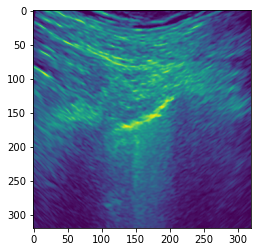

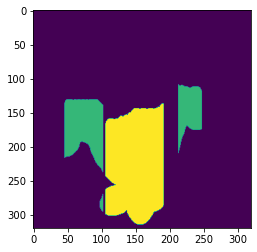

In [4]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[0,0,1],
            roi_end=[320,320,61],
            keys=["image", "label"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:01<00:00,  3.25it/s]


torch.Size([4, 4, 320, 320])
torch.Size([4, 320, 320])
image shape: torch.Size([4, 320, 320]), label shape: torch.Size([1, 320, 320])


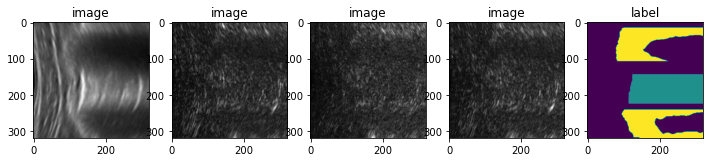

tensor(0.) tensor(2.)


In [7]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 5, 1)
plt.title("image")
plt.imshow(image[0, :, :], cmap="gray")
plt.subplot(1, 5, 2)
plt.title("image")
plt.imshow(image[1, :, :], cmap="gray")
plt.subplot(1, 5, 3)
plt.title("image")
plt.imshow(image[2, :, :], cmap="gray")
plt.subplot(1, 5, 4)
plt.title("image")
plt.imshow(image[3, :, :], cmap="gray")
plt.subplot(1, 5, 5)
plt.title("label")
plt.imshow(label[0, :, :])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))

max_epochs = 500
net_channels=(32, 64, 128)
net_strides=(2, 2)

In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [10]:
for i in range(device_num,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/500
1/0, train_loss: 0.7626
2/0, train_loss: 0.7587
3/0, train_loss: 0.7454
4/0, train_loss: 0.7468
0 epoch 1 average loss: 0.7534
----------
0: epoch 2/500
1/0, train_loss: 0.7464
2/0, train_loss: 0.7385
3/0, train_loss: 0.7313
4/0, train_loss: 0.7222
0 epoch 2 average loss: 0.7346
current epoch: 2 current mean dice: 0.1886
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/500
1/0, train_loss: 0.7313
2/0, train_loss: 0.7175
3/0, train_loss: 0.7163
4/0, train_loss: 0.7305
0 epoch 3 average loss: 0.7239
----------
0: epoch 4/500
1/0, train_loss: 0.7056
2/0, train_loss: 0.7152
3/0, train_loss: 0.7087
4/0, train_loss: 0.7056
0 epoch 4 average loss: 0.7088
current epoch: 4 current mean dice: 0.2135
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 5/500
1/0, train_loss: 0.6996
2/0, train_loss: 0.7023
3/0, train_loss: 0.7077
4/0, train_loss: 0.7195
0 epoch 5 average loss: 0.7073
----------
0: epoch 6/500
1/0, train_loss: 0.7039
2/0, train_loss: 0.6857
3

1/0, train_loss: 0.5967
2/0, train_loss: 0.5756
3/0, train_loss: 0.6031
4/0, train_loss: 0.5751
0 epoch 43 average loss: 0.5876
----------
0: epoch 44/500
1/0, train_loss: 0.5755
2/0, train_loss: 0.5958
3/0, train_loss: 0.5769
4/0, train_loss: 0.6209
0 epoch 44 average loss: 0.5923
current epoch: 44 current mean dice: 0.5267
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 45/500
1/0, train_loss: 0.5822
2/0, train_loss: 0.6001
3/0, train_loss: 0.5701
4/0, train_loss: 0.6324
0 epoch 45 average loss: 0.5962
----------
0: epoch 46/500
1/0, train_loss: 0.5708
2/0, train_loss: 0.5825
3/0, train_loss: 0.6216
4/0, train_loss: 0.5661
0 epoch 46 average loss: 0.5853
current epoch: 46 current mean dice: 0.4977
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 47/500
1/0, train_loss: 0.5877
2/0, train_loss: 0.5804
3/0, train_loss: 0.5864
4/0, train_loss: 0.6283
0 epoch 47 average loss: 0.5957
----------
0: epoch 48/500
1/0, train_loss: 0.5605
2/0, train_loss: 0.5995
3/0, train_loss

1/0, train_loss: 0.5231
2/0, train_loss: 0.5127
3/0, train_loss: 0.5627
4/0, train_loss: 0.5438
0 epoch 85 average loss: 0.5356
----------
0: epoch 86/500
1/0, train_loss: 0.5477
2/0, train_loss: 0.5348
3/0, train_loss: 0.5356
4/0, train_loss: 0.5149
0 epoch 86 average loss: 0.5333
current epoch: 86 current mean dice: 0.5359
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 87/500
1/0, train_loss: 0.5294
2/0, train_loss: 0.5655
3/0, train_loss: 0.5251
4/0, train_loss: 0.5157
0 epoch 87 average loss: 0.5339
----------
0: epoch 88/500
1/0, train_loss: 0.5065
2/0, train_loss: 0.5721
3/0, train_loss: 0.5257
4/0, train_loss: 0.5126
0 epoch 88 average loss: 0.5292
current epoch: 88 current mean dice: 0.5854
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 89/500
1/0, train_loss: 0.5506
2/0, train_loss: 0.5198
3/0, train_loss: 0.5332
4/0, train_loss: 0.5015
0 epoch 89 average loss: 0.5263
----------
0: epoch 90/500
1/0, train_loss: 0.5399
2/0, train_loss: 0.5295
3/0, train_loss

3/0, train_loss: 0.5029
4/0, train_loss: 0.4878
0 epoch 126 average loss: 0.4956
saved new best metric model
current epoch: 126 current mean dice: 0.5791
best mean dice: 0.5791 at epoch: 126
----------
0: epoch 127/500
1/0, train_loss: 0.5127
2/0, train_loss: 0.5000
3/0, train_loss: 0.4832
4/0, train_loss: 0.4715
0 epoch 127 average loss: 0.4918
----------
0: epoch 128/500
1/0, train_loss: 0.5299
2/0, train_loss: 0.4768
3/0, train_loss: 0.4918
4/0, train_loss: 0.4785
0 epoch 128 average loss: 0.4943
current epoch: 128 current mean dice: 0.5656
best mean dice: 0.5791 at epoch: 126
----------
0: epoch 129/500
1/0, train_loss: 0.5342
2/0, train_loss: 0.4664
3/0, train_loss: 0.4929
4/0, train_loss: 0.5207
0 epoch 129 average loss: 0.5036
----------
0: epoch 130/500
1/0, train_loss: 0.4953
2/0, train_loss: 0.5162
3/0, train_loss: 0.4677
4/0, train_loss: 0.4698
0 epoch 130 average loss: 0.4873
current epoch: 130 current mean dice: 0.5402
best mean dice: 0.5791 at epoch: 126
----------
0: epo

1/0, train_loss: 0.4933
2/0, train_loss: 0.4662
3/0, train_loss: 0.4389
4/0, train_loss: 0.4470
0 epoch 167 average loss: 0.4613
----------
0: epoch 168/500
1/0, train_loss: 0.4762
2/0, train_loss: 0.4162
3/0, train_loss: 0.4710
4/0, train_loss: 0.4839
0 epoch 168 average loss: 0.4618
current epoch: 168 current mean dice: 0.5576
best mean dice: 0.6076 at epoch: 148
----------
0: epoch 169/500
1/0, train_loss: 0.4512
2/0, train_loss: 0.5105
3/0, train_loss: 0.4345
4/0, train_loss: 0.4827
0 epoch 169 average loss: 0.4697
----------
0: epoch 170/500
1/0, train_loss: 0.4715
2/0, train_loss: 0.4590
3/0, train_loss: 0.4574
4/0, train_loss: 0.4180
0 epoch 170 average loss: 0.4515
current epoch: 170 current mean dice: 0.5637
best mean dice: 0.6076 at epoch: 148
----------
0: epoch 171/500
1/0, train_loss: 0.4334
2/0, train_loss: 0.4867
3/0, train_loss: 0.4758
4/0, train_loss: 0.4064
0 epoch 171 average loss: 0.4506
----------
0: epoch 172/500
1/0, train_loss: 0.4628
2/0, train_loss: 0.4555
3/0

0 epoch 208 average loss: 0.4223
current epoch: 208 current mean dice: 0.5581
best mean dice: 0.6165 at epoch: 204
----------
0: epoch 209/500
1/0, train_loss: 0.4469
2/0, train_loss: 0.4127
3/0, train_loss: 0.4389
4/0, train_loss: 0.4267
0 epoch 209 average loss: 0.4313
----------
0: epoch 210/500
1/0, train_loss: 0.4293
2/0, train_loss: 0.4399
3/0, train_loss: 0.4286
4/0, train_loss: 0.4313
0 epoch 210 average loss: 0.4323
current epoch: 210 current mean dice: 0.5845
best mean dice: 0.6165 at epoch: 204
----------
0: epoch 211/500
1/0, train_loss: 0.4549
2/0, train_loss: 0.4336
3/0, train_loss: 0.4000
4/0, train_loss: 0.4676
0 epoch 211 average loss: 0.4390
----------
0: epoch 212/500
1/0, train_loss: 0.4583
2/0, train_loss: 0.3892
3/0, train_loss: 0.4315
4/0, train_loss: 0.4642
0 epoch 212 average loss: 0.4358
current epoch: 212 current mean dice: 0.5778
best mean dice: 0.6165 at epoch: 204
----------
0: epoch 213/500
1/0, train_loss: 0.4288
2/0, train_loss: 0.4168
3/0, train_loss: 

1/0, train_loss: 0.3774
2/0, train_loss: 0.4015
3/0, train_loss: 0.4160
4/0, train_loss: 0.4878
0 epoch 250 average loss: 0.4207
current epoch: 250 current mean dice: 0.6085
best mean dice: 0.6165 at epoch: 204
----------
0: epoch 251/500
1/0, train_loss: 0.3974
2/0, train_loss: 0.4277
3/0, train_loss: 0.3789
4/0, train_loss: 0.4089
0 epoch 251 average loss: 0.4032
----------
0: epoch 252/500
1/0, train_loss: 0.4255
2/0, train_loss: 0.4159
3/0, train_loss: 0.3652
4/0, train_loss: 0.4325
0 epoch 252 average loss: 0.4098
current epoch: 252 current mean dice: 0.5663
best mean dice: 0.6165 at epoch: 204
----------
0: epoch 253/500
1/0, train_loss: 0.3948
2/0, train_loss: 0.4154
3/0, train_loss: 0.3984
4/0, train_loss: 0.4225
0 epoch 253 average loss: 0.4078
----------
0: epoch 254/500
1/0, train_loss: 0.4053
2/0, train_loss: 0.4115
3/0, train_loss: 0.4096
4/0, train_loss: 0.3692
0 epoch 254 average loss: 0.3989
current epoch: 254 current mean dice: 0.5794
best mean dice: 0.6165 at epoch: 2

2/0, train_loss: 0.4003
3/0, train_loss: 0.3682
4/0, train_loss: 0.3884
0 epoch 291 average loss: 0.3887
----------
0: epoch 292/500
1/0, train_loss: 0.4017
2/0, train_loss: 0.3705
3/0, train_loss: 0.3689
4/0, train_loss: 0.3904
0 epoch 292 average loss: 0.3829
current epoch: 292 current mean dice: 0.6200
best mean dice: 0.6276 at epoch: 272
----------
0: epoch 293/500
1/0, train_loss: 0.3965
2/0, train_loss: 0.3530
3/0, train_loss: 0.3962
4/0, train_loss: 0.3664
0 epoch 293 average loss: 0.3780
----------
0: epoch 294/500
1/0, train_loss: 0.3813
2/0, train_loss: 0.3969
3/0, train_loss: 0.3859
4/0, train_loss: 0.3588
0 epoch 294 average loss: 0.3807
current epoch: 294 current mean dice: 0.5766
best mean dice: 0.6276 at epoch: 272
----------
0: epoch 295/500
1/0, train_loss: 0.3912
2/0, train_loss: 0.3897
3/0, train_loss: 0.3832
4/0, train_loss: 0.3643
0 epoch 295 average loss: 0.3821
----------
0: epoch 296/500
1/0, train_loss: 0.3868
2/0, train_loss: 0.3836
3/0, train_loss: 0.3858
4/0

current epoch: 332 current mean dice: 0.5973
best mean dice: 0.6419 at epoch: 316
----------
0: epoch 333/500
1/0, train_loss: 0.3532
2/0, train_loss: 0.3729
3/0, train_loss: 0.3704
4/0, train_loss: 0.3187
0 epoch 333 average loss: 0.3538
----------
0: epoch 334/500
1/0, train_loss: 0.3758
2/0, train_loss: 0.3398
3/0, train_loss: 0.3479
4/0, train_loss: 0.4481
0 epoch 334 average loss: 0.3779
current epoch: 334 current mean dice: 0.5851
best mean dice: 0.6419 at epoch: 316
----------
0: epoch 335/500
1/0, train_loss: 0.3384
2/0, train_loss: 0.3839
3/0, train_loss: 0.3716
4/0, train_loss: 0.3778
0 epoch 335 average loss: 0.3679
----------
0: epoch 336/500
1/0, train_loss: 0.3633
2/0, train_loss: 0.3567
3/0, train_loss: 0.3937
4/0, train_loss: 0.3277
0 epoch 336 average loss: 0.3603
current epoch: 336 current mean dice: 0.5646
best mean dice: 0.6419 at epoch: 316
----------
0: epoch 337/500
1/0, train_loss: 0.3878
2/0, train_loss: 0.3484
3/0, train_loss: 0.3502
4/0, train_loss: 0.3621
0 

2/0, train_loss: 0.3170
3/0, train_loss: 0.3310
4/0, train_loss: 0.3776
0 epoch 374 average loss: 0.3521
saved new best metric model
current epoch: 374 current mean dice: 0.6457
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 375/500
1/0, train_loss: 0.3596
2/0, train_loss: 0.3309
3/0, train_loss: 0.3586
4/0, train_loss: 0.3264
0 epoch 375 average loss: 0.3439
----------
0: epoch 376/500
1/0, train_loss: 0.3738
2/0, train_loss: 0.3453
3/0, train_loss: 0.3357
4/0, train_loss: 0.3025
0 epoch 376 average loss: 0.3393
current epoch: 376 current mean dice: 0.6298
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 377/500
1/0, train_loss: 0.3609
2/0, train_loss: 0.3147
3/0, train_loss: 0.3639
4/0, train_loss: 0.3120
0 epoch 377 average loss: 0.3379
----------
0: epoch 378/500
1/0, train_loss: 0.3543
2/0, train_loss: 0.3230
3/0, train_loss: 0.3589
4/0, train_loss: 0.3753
0 epoch 378 average loss: 0.3529
current epoch: 378 current mean dice: 0.6296
best mean dice: 0.6457 at epoc

3/0, train_loss: 0.3202
4/0, train_loss: 0.3060
0 epoch 415 average loss: 0.3341
----------
0: epoch 416/500
1/0, train_loss: 0.3350
2/0, train_loss: 0.3232
3/0, train_loss: 0.3209
4/0, train_loss: 0.3680
0 epoch 416 average loss: 0.3368
current epoch: 416 current mean dice: 0.5974
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 417/500
1/0, train_loss: 0.3016
2/0, train_loss: 0.3348
3/0, train_loss: 0.3333
4/0, train_loss: 0.4182
0 epoch 417 average loss: 0.3470
----------
0: epoch 418/500
1/0, train_loss: 0.3330
2/0, train_loss: 0.3540
3/0, train_loss: 0.3443
4/0, train_loss: 0.2885
0 epoch 418 average loss: 0.3299
current epoch: 418 current mean dice: 0.5958
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 419/500
1/0, train_loss: 0.3418
2/0, train_loss: 0.3134
3/0, train_loss: 0.3301
4/0, train_loss: 0.4430
0 epoch 419 average loss: 0.3571
----------
0: epoch 420/500
1/0, train_loss: 0.3388
2/0, train_loss: 0.3455
3/0, train_loss: 0.3083
4/0, train_loss: 0.4180
0 e

1/0, train_loss: 0.3317
2/0, train_loss: 0.2898
3/0, train_loss: 0.3202
4/0, train_loss: 0.4128
0 epoch 457 average loss: 0.3386
----------
0: epoch 458/500
1/0, train_loss: 0.3381
2/0, train_loss: 0.2924
3/0, train_loss: 0.3461
4/0, train_loss: 0.2971
0 epoch 458 average loss: 0.3184
current epoch: 458 current mean dice: 0.5969
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 459/500
1/0, train_loss: 0.3404
2/0, train_loss: 0.3132
3/0, train_loss: 0.3103
4/0, train_loss: 0.3182
0 epoch 459 average loss: 0.3205
----------
0: epoch 460/500
1/0, train_loss: 0.2987
2/0, train_loss: 0.3340
3/0, train_loss: 0.3399
4/0, train_loss: 0.3829
0 epoch 460 average loss: 0.3389
current epoch: 460 current mean dice: 0.6126
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 461/500
1/0, train_loss: 0.3228
2/0, train_loss: 0.3323
3/0, train_loss: 0.3177
4/0, train_loss: 0.2778
0 epoch 461 average loss: 0.3127
----------
0: epoch 462/500
1/0, train_loss: 0.3213
2/0, train_loss: 0.3270
3/0

current epoch: 498 current mean dice: 0.5858
best mean dice: 0.6457 at epoch: 374
----------
0: epoch 499/500
1/0, train_loss: 0.2970
2/0, train_loss: 0.2959
3/0, train_loss: 0.3680
4/0, train_loss: 0.3432
0 epoch 499 average loss: 0.3260
----------
0: epoch 500/500
1/0, train_loss: 0.3228
2/0, train_loss: 0.3050
3/0, train_loss: 0.3545
4/0, train_loss: 0.2697
0 epoch 500 average loss: 0.3130
current epoch: 500 current mean dice: 0.5940
best mean dice: 0.6457 at epoch: 374
----------
1: epoch 1/500
1/0, train_loss: 0.7188
2/0, train_loss: 0.7232
3/0, train_loss: 0.7101
4/0, train_loss: 0.7019
1 epoch 1 average loss: 0.7135
----------
1: epoch 2/500
1/0, train_loss: 0.7031
2/0, train_loss: 0.7110
3/0, train_loss: 0.6923
4/0, train_loss: 0.7063
1 epoch 2 average loss: 0.7032
current epoch: 2 current mean dice: 0.0052
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 3/500
1/0, train_loss: 0.7014
2/0, train_loss: 0.6960
3/0, train_loss: 0.6974
4/0, train_loss: 0.7037
1 epoch 3 aver

current epoch: 40 current mean dice: 0.2810
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 41/500
1/0, train_loss: 0.6147
2/0, train_loss: 0.5727
3/0, train_loss: 0.5977
4/0, train_loss: 0.5986
1 epoch 41 average loss: 0.5959
----------
1: epoch 42/500
1/0, train_loss: 0.6058
2/0, train_loss: 0.5884
3/0, train_loss: 0.5982
4/0, train_loss: 0.5434
1 epoch 42 average loss: 0.5840
current epoch: 42 current mean dice: 0.2675
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 43/500
1/0, train_loss: 0.6087
2/0, train_loss: 0.5828
3/0, train_loss: 0.5803
4/0, train_loss: 0.6051
1 epoch 43 average loss: 0.5942
----------
1: epoch 44/500
1/0, train_loss: 0.6109
2/0, train_loss: 0.5894
3/0, train_loss: 0.5716
4/0, train_loss: 0.5782
1 epoch 44 average loss: 0.5875
current epoch: 44 current mean dice: 0.2655
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 45/500
1/0, train_loss: 0.5866
2/0, train_loss: 0.5969
3/0, train_loss: 0.5740
4/0, train_loss: 0.5975
1 epoch 45 ave

current epoch: 82 current mean dice: 0.2369
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 83/500
1/0, train_loss: 0.5492
2/0, train_loss: 0.5356
3/0, train_loss: 0.5251
4/0, train_loss: 0.5434
1 epoch 83 average loss: 0.5383
----------
1: epoch 84/500
1/0, train_loss: 0.5270
2/0, train_loss: 0.5387
3/0, train_loss: 0.5309
4/0, train_loss: 0.5897
1 epoch 84 average loss: 0.5466
current epoch: 84 current mean dice: 0.2980
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 85/500
1/0, train_loss: 0.5333
2/0, train_loss: 0.5479
3/0, train_loss: 0.5160
4/0, train_loss: 0.5391
1 epoch 85 average loss: 0.5341
----------
1: epoch 86/500
1/0, train_loss: 0.5165
2/0, train_loss: 0.5206
3/0, train_loss: 0.5185
4/0, train_loss: 0.6087
1 epoch 86 average loss: 0.5411
current epoch: 86 current mean dice: 0.2980
best mean dice: -1.0000 at epoch: -1
----------
1: epoch 87/500
1/0, train_loss: 0.5339
2/0, train_loss: 0.5371
3/0, train_loss: 0.5331
4/0, train_loss: 0.5055
1 epoch 87 ave

1/0, train_loss: 0.4630
2/0, train_loss: 0.4858
3/0, train_loss: 0.4863
4/0, train_loss: 0.4651
1 epoch 124 average loss: 0.4751
current epoch: 124 current mean dice: 0.3270
best mean dice: 0.3320 at epoch: 106
----------
1: epoch 125/500
1/0, train_loss: 0.4772
2/0, train_loss: 0.4805
3/0, train_loss: 0.4559
4/0, train_loss: 0.5320
1 epoch 125 average loss: 0.4864
----------
1: epoch 126/500
1/0, train_loss: 0.4687
2/0, train_loss: 0.4678
3/0, train_loss: 0.4888
4/0, train_loss: 0.4267
1 epoch 126 average loss: 0.4630
current epoch: 126 current mean dice: 0.3310
best mean dice: 0.3320 at epoch: 106
----------
1: epoch 127/500
1/0, train_loss: 0.4977
2/0, train_loss: 0.4496
3/0, train_loss: 0.4694
4/0, train_loss: 0.4943
1 epoch 127 average loss: 0.4778
----------
1: epoch 128/500
1/0, train_loss: 0.4381
2/0, train_loss: 0.4717
3/0, train_loss: 0.5029
4/0, train_loss: 0.5080
1 epoch 128 average loss: 0.4802
current epoch: 128 current mean dice: 0.3196
best mean dice: 0.3320 at epoch: 1

1/0, train_loss: 0.4240
2/0, train_loss: 0.4729
3/0, train_loss: 0.4273
4/0, train_loss: 0.3929
1 epoch 165 average loss: 0.4293
----------
1: epoch 166/500
1/0, train_loss: 0.4094
2/0, train_loss: 0.4457
3/0, train_loss: 0.4642
4/0, train_loss: 0.4370
1 epoch 166 average loss: 0.4391
current epoch: 166 current mean dice: 0.3225
best mean dice: 0.3505 at epoch: 162
----------
1: epoch 167/500
1/0, train_loss: 0.4533
2/0, train_loss: 0.4154
3/0, train_loss: 0.4300
4/0, train_loss: 0.4612
1 epoch 167 average loss: 0.4400
----------
1: epoch 168/500
1/0, train_loss: 0.4536
2/0, train_loss: 0.4160
3/0, train_loss: 0.4233
4/0, train_loss: 0.5017
1 epoch 168 average loss: 0.4486
current epoch: 168 current mean dice: 0.3378
best mean dice: 0.3505 at epoch: 162
----------
1: epoch 169/500
1/0, train_loss: 0.4059
2/0, train_loss: 0.4376
3/0, train_loss: 0.4633
4/0, train_loss: 0.4368
1 epoch 169 average loss: 0.4359
----------
1: epoch 170/500
1/0, train_loss: 0.4368
2/0, train_loss: 0.4492
3/0

1/0, train_loss: 0.3911
2/0, train_loss: 0.4261
3/0, train_loss: 0.4118
4/0, train_loss: 0.4092
1 epoch 206 average loss: 0.4096
current epoch: 206 current mean dice: 0.3745
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 207/500
1/0, train_loss: 0.4082
2/0, train_loss: 0.3821
3/0, train_loss: 0.4372
4/0, train_loss: 0.4165
1 epoch 207 average loss: 0.4110
----------
1: epoch 208/500
1/0, train_loss: 0.4238
2/0, train_loss: 0.3887
3/0, train_loss: 0.4002
4/0, train_loss: 0.4843
1 epoch 208 average loss: 0.4243
current epoch: 208 current mean dice: 0.3687
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 209/500
1/0, train_loss: 0.3701
2/0, train_loss: 0.4146
3/0, train_loss: 0.4349
4/0, train_loss: 0.4087
1 epoch 209 average loss: 0.4071
----------
1: epoch 210/500
1/0, train_loss: 0.3966
2/0, train_loss: 0.3998
3/0, train_loss: 0.4087
4/0, train_loss: 0.4536
1 epoch 210 average loss: 0.4147
current epoch: 210 current mean dice: 0.3435
best mean dice: 0.3924 at epoch: 2

3/0, train_loss: 0.3936
4/0, train_loss: 0.3621
1 epoch 247 average loss: 0.3804
----------
1: epoch 248/500
1/0, train_loss: 0.3963
2/0, train_loss: 0.4074
3/0, train_loss: 0.3651
4/0, train_loss: 0.3680
1 epoch 248 average loss: 0.3842
current epoch: 248 current mean dice: 0.3252
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 249/500
1/0, train_loss: 0.3968
2/0, train_loss: 0.3657
3/0, train_loss: 0.3902
4/0, train_loss: 0.4032
1 epoch 249 average loss: 0.3890
----------
1: epoch 250/500
1/0, train_loss: 0.3832
2/0, train_loss: 0.3846
3/0, train_loss: 0.3648
4/0, train_loss: 0.4352
1 epoch 250 average loss: 0.3919
current epoch: 250 current mean dice: 0.3483
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 251/500
1/0, train_loss: 0.3774
2/0, train_loss: 0.3764
3/0, train_loss: 0.3893
4/0, train_loss: 0.4216
1 epoch 251 average loss: 0.3912
----------
1: epoch 252/500
1/0, train_loss: 0.3442
2/0, train_loss: 0.4020
3/0, train_loss: 0.3943
4/0, train_loss: 0.3873
1 e

1/0, train_loss: 0.3591
2/0, train_loss: 0.3146
3/0, train_loss: 0.3793
4/0, train_loss: 0.4359
1 epoch 289 average loss: 0.3722
----------
1: epoch 290/500
1/0, train_loss: 0.3626
2/0, train_loss: 0.3745
3/0, train_loss: 0.3368
4/0, train_loss: 0.4131
1 epoch 290 average loss: 0.3717
current epoch: 290 current mean dice: 0.3387
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 291/500
1/0, train_loss: 0.3054
2/0, train_loss: 0.3971
3/0, train_loss: 0.3754
4/0, train_loss: 0.3644
1 epoch 291 average loss: 0.3606
----------
1: epoch 292/500
1/0, train_loss: 0.3800
2/0, train_loss: 0.3362
3/0, train_loss: 0.3679
4/0, train_loss: 0.3586
1 epoch 292 average loss: 0.3607
current epoch: 292 current mean dice: 0.3624
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 293/500
1/0, train_loss: 0.3813
2/0, train_loss: 0.3555
3/0, train_loss: 0.3651
4/0, train_loss: 0.3690
1 epoch 293 average loss: 0.3677
----------
1: epoch 294/500
1/0, train_loss: 0.3575
2/0, train_loss: 0.3697
3/0

current epoch: 330 current mean dice: 0.3574
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 331/500
1/0, train_loss: 0.3239
2/0, train_loss: 0.3631
3/0, train_loss: 0.3640
4/0, train_loss: 0.3601
1 epoch 331 average loss: 0.3528
----------
1: epoch 332/500
1/0, train_loss: 0.3469
2/0, train_loss: 0.3410
3/0, train_loss: 0.3203
4/0, train_loss: 0.3957
1 epoch 332 average loss: 0.3510
current epoch: 332 current mean dice: 0.3685
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 333/500
1/0, train_loss: 0.3558
2/0, train_loss: 0.3231
3/0, train_loss: 0.3431
4/0, train_loss: 0.4196
1 epoch 333 average loss: 0.3604
----------
1: epoch 334/500
1/0, train_loss: 0.3270
2/0, train_loss: 0.3709
3/0, train_loss: 0.3246
4/0, train_loss: 0.3099
1 epoch 334 average loss: 0.3331
current epoch: 334 current mean dice: 0.3487
best mean dice: 0.3924 at epoch: 204
----------
1: epoch 335/500
1/0, train_loss: 0.3438
2/0, train_loss: 0.3202
3/0, train_loss: 0.3457
4/0, train_loss: 0.4071
1 

1/0, train_loss: 0.3646
2/0, train_loss: 0.3165
3/0, train_loss: 0.2981
4/0, train_loss: 0.3535
1 epoch 372 average loss: 0.3332
current epoch: 372 current mean dice: 0.3305
best mean dice: 0.3986 at epoch: 338
----------
1: epoch 373/500
1/0, train_loss: 0.3177
2/0, train_loss: 0.3368
3/0, train_loss: 0.3442
4/0, train_loss: 0.2917
1 epoch 373 average loss: 0.3226
----------
1: epoch 374/500
1/0, train_loss: 0.3052
2/0, train_loss: 0.3050
3/0, train_loss: 0.3574
4/0, train_loss: 0.3380
1 epoch 374 average loss: 0.3264
current epoch: 374 current mean dice: 0.3384
best mean dice: 0.3986 at epoch: 338
----------
1: epoch 375/500
1/0, train_loss: 0.3468
2/0, train_loss: 0.3144
3/0, train_loss: 0.3214
4/0, train_loss: 0.3454
1 epoch 375 average loss: 0.3320
----------
1: epoch 376/500
1/0, train_loss: 0.3286
2/0, train_loss: 0.3581
3/0, train_loss: 0.3440
4/0, train_loss: 0.3245
1 epoch 376 average loss: 0.3388
current epoch: 376 current mean dice: 0.3515
best mean dice: 0.3986 at epoch: 3

1/0, train_loss: 0.3030
2/0, train_loss: 0.3211
3/0, train_loss: 0.3187
4/0, train_loss: 0.2826
1 epoch 413 average loss: 0.3063
----------
1: epoch 414/500
1/0, train_loss: 0.3336
2/0, train_loss: 0.3423
3/0, train_loss: 0.2794
4/0, train_loss: 0.3379
1 epoch 414 average loss: 0.3233
current epoch: 414 current mean dice: 0.3831
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 415/500
1/0, train_loss: 0.2989
2/0, train_loss: 0.2909
3/0, train_loss: 0.3480
4/0, train_loss: 0.3229
1 epoch 415 average loss: 0.3152
----------
1: epoch 416/500
1/0, train_loss: 0.3049
2/0, train_loss: 0.3342
3/0, train_loss: 0.3191
4/0, train_loss: 0.3028
1 epoch 416 average loss: 0.3153
current epoch: 416 current mean dice: 0.3506
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 417/500
1/0, train_loss: 0.3151
2/0, train_loss: 0.3364
3/0, train_loss: 0.3344
4/0, train_loss: 0.2351
1 epoch 417 average loss: 0.3053
----------
1: epoch 418/500
1/0, train_loss: 0.3226
2/0, train_loss: 0.3028
3/0

current epoch: 454 current mean dice: 0.3624
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 455/500
1/0, train_loss: 0.3332
2/0, train_loss: 0.3024
3/0, train_loss: 0.3031
4/0, train_loss: 0.3024
1 epoch 455 average loss: 0.3102
----------
1: epoch 456/500
1/0, train_loss: 0.3033
2/0, train_loss: 0.3152
3/0, train_loss: 0.2994
4/0, train_loss: 0.3752
1 epoch 456 average loss: 0.3233
current epoch: 456 current mean dice: 0.3620
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 457/500
1/0, train_loss: 0.2977
2/0, train_loss: 0.3282
3/0, train_loss: 0.2778
4/0, train_loss: 0.3253
1 epoch 457 average loss: 0.3073
----------
1: epoch 458/500
1/0, train_loss: 0.3139
2/0, train_loss: 0.2826
3/0, train_loss: 0.3062
4/0, train_loss: 0.3208
1 epoch 458 average loss: 0.3059
current epoch: 458 current mean dice: 0.3589
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 459/500
1/0, train_loss: 0.3226
2/0, train_loss: 0.3020
3/0, train_loss: 0.3173
4/0, train_loss: 0.2720
1 

2/0, train_loss: 0.2761
3/0, train_loss: 0.2766
4/0, train_loss: 0.2918
1 epoch 496 average loss: 0.2923
current epoch: 496 current mean dice: 0.3624
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 497/500
1/0, train_loss: 0.2860
2/0, train_loss: 0.3098
3/0, train_loss: 0.2770
4/0, train_loss: 0.3448
1 epoch 497 average loss: 0.3044
----------
1: epoch 498/500
1/0, train_loss: 0.2939
2/0, train_loss: 0.3463
3/0, train_loss: 0.2749
4/0, train_loss: 0.2587
1 epoch 498 average loss: 0.2934
current epoch: 498 current mean dice: 0.3812
best mean dice: 0.4217 at epoch: 394
----------
1: epoch 499/500
1/0, train_loss: 0.2712
2/0, train_loss: 0.3149
3/0, train_loss: 0.2782
4/0, train_loss: 0.3987
1 epoch 499 average loss: 0.3157
----------
1: epoch 500/500
1/0, train_loss: 0.2803
2/0, train_loss: 0.3158
3/0, train_loss: 0.2810
4/0, train_loss: 0.3082
1 epoch 500 average loss: 0.2963
current epoch: 500 current mean dice: 0.3700
best mean dice: 0.4217 at epoch: 394
----------
2: epoch 1

2/0, train_loss: 0.5485
3/0, train_loss: 0.5508
4/0, train_loss: 0.5372
2 epoch 38 average loss: 0.5560
current epoch: 38 current mean dice: 0.3512
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 39/500
1/0, train_loss: 0.5599
2/0, train_loss: 0.5612
3/0, train_loss: 0.5404
4/0, train_loss: 0.5803
2 epoch 39 average loss: 0.5604
----------
2: epoch 40/500
1/0, train_loss: 0.5772
2/0, train_loss: 0.5557
3/0, train_loss: 0.5447
4/0, train_loss: 0.5547
2 epoch 40 average loss: 0.5581
current epoch: 40 current mean dice: 0.3386
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 41/500
1/0, train_loss: 0.5356
2/0, train_loss: 0.5494
3/0, train_loss: 0.5605
4/0, train_loss: 0.5591
2 epoch 41 average loss: 0.5512
----------
2: epoch 42/500
1/0, train_loss: 0.5579
2/0, train_loss: 0.5507
3/0, train_loss: 0.5613
4/0, train_loss: 0.5202
2 epoch 42 average loss: 0.5475
current epoch: 42 current mean dice: 0.3478
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 43/500
1/0, t

2/0, train_loss: 0.5053
3/0, train_loss: 0.5140
4/0, train_loss: 0.5221
2 epoch 80 average loss: 0.5126
current epoch: 80 current mean dice: 0.3715
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 81/500
1/0, train_loss: 0.5021
2/0, train_loss: 0.5141
3/0, train_loss: 0.4996
4/0, train_loss: 0.5476
2 epoch 81 average loss: 0.5159
----------
2: epoch 82/500
1/0, train_loss: 0.5347
2/0, train_loss: 0.4915
3/0, train_loss: 0.4785
4/0, train_loss: 0.5362
2 epoch 82 average loss: 0.5102
current epoch: 82 current mean dice: 0.4063
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 83/500
1/0, train_loss: 0.4939
2/0, train_loss: 0.5009
3/0, train_loss: 0.5253
4/0, train_loss: 0.5055
2 epoch 83 average loss: 0.5064
----------
2: epoch 84/500
1/0, train_loss: 0.5163
2/0, train_loss: 0.4898
3/0, train_loss: 0.4962
4/0, train_loss: 0.4799
2 epoch 84 average loss: 0.4955
current epoch: 84 current mean dice: 0.3966
best mean dice: -1.0000 at epoch: -1
----------
2: epoch 85/500
1/0, t

1/0, train_loss: 0.4424
2/0, train_loss: 0.4550
3/0, train_loss: 0.4887
4/0, train_loss: 0.4533
2 epoch 121 average loss: 0.4599
----------
2: epoch 122/500
1/0, train_loss: 0.5103
2/0, train_loss: 0.4346
3/0, train_loss: 0.4553
4/0, train_loss: 0.4497
2 epoch 122 average loss: 0.4625
current epoch: 122 current mean dice: 0.4464
best mean dice: 0.4514 at epoch: 120
----------
2: epoch 123/500
1/0, train_loss: 0.4493
2/0, train_loss: 0.4697
3/0, train_loss: 0.4776
4/0, train_loss: 0.4480
2 epoch 123 average loss: 0.4612
----------
2: epoch 124/500
1/0, train_loss: 0.4566
2/0, train_loss: 0.4384
3/0, train_loss: 0.4838
4/0, train_loss: 0.4246
2 epoch 124 average loss: 0.4509
current epoch: 124 current mean dice: 0.4398
best mean dice: 0.4514 at epoch: 120
----------
2: epoch 125/500
1/0, train_loss: 0.4900
2/0, train_loss: 0.4589
3/0, train_loss: 0.4493
4/0, train_loss: 0.4321
2 epoch 125 average loss: 0.4576
----------
2: epoch 126/500
1/0, train_loss: 0.4603
2/0, train_loss: 0.4456
3/0

2/0, train_loss: 0.4424
3/0, train_loss: 0.3985
4/0, train_loss: 0.4532
2 epoch 162 average loss: 0.4293
current epoch: 162 current mean dice: 0.4585
best mean dice: 0.4849 at epoch: 160
----------
2: epoch 163/500
1/0, train_loss: 0.3968
2/0, train_loss: 0.4251
3/0, train_loss: 0.4235
4/0, train_loss: 0.4187
2 epoch 163 average loss: 0.4160
----------
2: epoch 164/500
1/0, train_loss: 0.4481
2/0, train_loss: 0.3987
3/0, train_loss: 0.4034
4/0, train_loss: 0.4133
2 epoch 164 average loss: 0.4159
current epoch: 164 current mean dice: 0.4636
best mean dice: 0.4849 at epoch: 160
----------
2: epoch 165/500
1/0, train_loss: 0.4617
2/0, train_loss: 0.4342
3/0, train_loss: 0.3691
4/0, train_loss: 0.3990
2 epoch 165 average loss: 0.4160
----------
2: epoch 166/500
1/0, train_loss: 0.4086
2/0, train_loss: 0.4167
3/0, train_loss: 0.4248
4/0, train_loss: 0.4197
2 epoch 166 average loss: 0.4175
current epoch: 166 current mean dice: 0.4679
best mean dice: 0.4849 at epoch: 160
----------
2: epoch 1

1/0, train_loss: 0.4044
2/0, train_loss: 0.3904
3/0, train_loss: 0.3560
4/0, train_loss: 0.4503
2 epoch 203 average loss: 0.4003
----------
2: epoch 204/500
1/0, train_loss: 0.3762
2/0, train_loss: 0.3956
3/0, train_loss: 0.4085
4/0, train_loss: 0.3486
2 epoch 204 average loss: 0.3822
current epoch: 204 current mean dice: 0.4884
best mean dice: 0.4890 at epoch: 202
----------
2: epoch 205/500
1/0, train_loss: 0.3684
2/0, train_loss: 0.3856
3/0, train_loss: 0.4282
4/0, train_loss: 0.3610
2 epoch 205 average loss: 0.3858
----------
2: epoch 206/500
1/0, train_loss: 0.3973
2/0, train_loss: 0.3711
3/0, train_loss: 0.3966
4/0, train_loss: 0.4002
2 epoch 206 average loss: 0.3913
saved new best metric model
current epoch: 206 current mean dice: 0.4913
best mean dice: 0.4913 at epoch: 206
----------
2: epoch 207/500
1/0, train_loss: 0.3791
2/0, train_loss: 0.3898
3/0, train_loss: 0.3890
4/0, train_loss: 0.4472
2 epoch 207 average loss: 0.4013
----------
2: epoch 208/500
1/0, train_loss: 0.4079

3/0, train_loss: 0.3628
4/0, train_loss: 0.3689
2 epoch 244 average loss: 0.3725
current epoch: 244 current mean dice: 0.4845
best mean dice: 0.5034 at epoch: 230
----------
2: epoch 245/500
1/0, train_loss: 0.3726
2/0, train_loss: 0.3558
3/0, train_loss: 0.3910
4/0, train_loss: 0.3320
2 epoch 245 average loss: 0.3628
----------
2: epoch 246/500
1/0, train_loss: 0.3758
2/0, train_loss: 0.3369
3/0, train_loss: 0.3927
4/0, train_loss: 0.3829
2 epoch 246 average loss: 0.3721
current epoch: 246 current mean dice: 0.4924
best mean dice: 0.5034 at epoch: 230
----------
2: epoch 247/500
1/0, train_loss: 0.3842
2/0, train_loss: 0.3954
3/0, train_loss: 0.3315
4/0, train_loss: 0.3490
2 epoch 247 average loss: 0.3650
----------
2: epoch 248/500
1/0, train_loss: 0.4003
2/0, train_loss: 0.3589
3/0, train_loss: 0.3341
4/0, train_loss: 0.4183
2 epoch 248 average loss: 0.3779
current epoch: 248 current mean dice: 0.4771
best mean dice: 0.5034 at epoch: 230
----------
2: epoch 249/500
1/0, train_loss: 

3/0, train_loss: 0.4035
4/0, train_loss: 0.3523
2 epoch 285 average loss: 0.3503
----------
2: epoch 286/500
1/0, train_loss: 0.3508
2/0, train_loss: 0.3524
3/0, train_loss: 0.3491
4/0, train_loss: 0.3907
2 epoch 286 average loss: 0.3608
current epoch: 286 current mean dice: 0.4919
best mean dice: 0.5118 at epoch: 264
----------
2: epoch 287/500
1/0, train_loss: 0.3573
2/0, train_loss: 0.3429
3/0, train_loss: 0.3524
4/0, train_loss: 0.3581
2 epoch 287 average loss: 0.3527
----------
2: epoch 288/500
1/0, train_loss: 0.3320
2/0, train_loss: 0.3610
3/0, train_loss: 0.3534
4/0, train_loss: 0.4049
2 epoch 288 average loss: 0.3628
saved new best metric model
current epoch: 288 current mean dice: 0.5184
best mean dice: 0.5184 at epoch: 288
----------
2: epoch 289/500
1/0, train_loss: 0.3642
2/0, train_loss: 0.3547
3/0, train_loss: 0.3309
4/0, train_loss: 0.3489
2 epoch 289 average loss: 0.3497
----------
2: epoch 290/500
1/0, train_loss: 0.3445
2/0, train_loss: 0.3678
3/0, train_loss: 0.3529

current epoch: 326 current mean dice: 0.5101
best mean dice: 0.5188 at epoch: 290
----------
2: epoch 327/500
1/0, train_loss: 0.3516
2/0, train_loss: 0.3265
3/0, train_loss: 0.3259
4/0, train_loss: 0.3490
2 epoch 327 average loss: 0.3382
----------
2: epoch 328/500
1/0, train_loss: 0.3302
2/0, train_loss: 0.3449
3/0, train_loss: 0.3532
4/0, train_loss: 0.3151
2 epoch 328 average loss: 0.3359
current epoch: 328 current mean dice: 0.5012
best mean dice: 0.5188 at epoch: 290
----------
2: epoch 329/500
1/0, train_loss: 0.3258
2/0, train_loss: 0.3474
3/0, train_loss: 0.3176
4/0, train_loss: 0.3804
2 epoch 329 average loss: 0.3428
----------
2: epoch 330/500
1/0, train_loss: 0.3404
2/0, train_loss: 0.3257
3/0, train_loss: 0.3418
4/0, train_loss: 0.4151
2 epoch 330 average loss: 0.3558
current epoch: 330 current mean dice: 0.4971
best mean dice: 0.5188 at epoch: 290
----------
2: epoch 331/500
1/0, train_loss: 0.3471
2/0, train_loss: 0.3099
3/0, train_loss: 0.3398
4/0, train_loss: 0.3427
2 

1/0, train_loss: 0.3245
2/0, train_loss: 0.3076
3/0, train_loss: 0.3276
4/0, train_loss: 0.3801
2 epoch 368 average loss: 0.3349
current epoch: 368 current mean dice: 0.5040
best mean dice: 0.5299 at epoch: 358
----------
2: epoch 369/500
1/0, train_loss: 0.3121
2/0, train_loss: 0.3926
3/0, train_loss: 0.2956
4/0, train_loss: 0.2815
2 epoch 369 average loss: 0.3204
----------
2: epoch 370/500
1/0, train_loss: 0.3413
2/0, train_loss: 0.2982
3/0, train_loss: 0.3309
4/0, train_loss: 0.3689
2 epoch 370 average loss: 0.3348
current epoch: 370 current mean dice: 0.5061
best mean dice: 0.5299 at epoch: 358
----------
2: epoch 371/500
1/0, train_loss: 0.3276
2/0, train_loss: 0.3195
3/0, train_loss: 0.3804
4/0, train_loss: 0.2719
2 epoch 371 average loss: 0.3248
----------
2: epoch 372/500
1/0, train_loss: 0.2862
2/0, train_loss: 0.3422
3/0, train_loss: 0.3535
4/0, train_loss: 0.2817
2 epoch 372 average loss: 0.3159
current epoch: 372 current mean dice: 0.4867
best mean dice: 0.5299 at epoch: 3

2/0, train_loss: 0.2962
3/0, train_loss: 0.3127
4/0, train_loss: 0.2664
2 epoch 409 average loss: 0.3059
----------
2: epoch 410/500
1/0, train_loss: 0.3012
2/0, train_loss: 0.2889
3/0, train_loss: 0.3126
4/0, train_loss: 0.3293
2 epoch 410 average loss: 0.3080
current epoch: 410 current mean dice: 0.4968
best mean dice: 0.5357 at epoch: 382
----------
2: epoch 411/500
1/0, train_loss: 0.2940
2/0, train_loss: 0.3372
3/0, train_loss: 0.3212
4/0, train_loss: 0.3295
2 epoch 411 average loss: 0.3205
----------
2: epoch 412/500
1/0, train_loss: 0.3407
2/0, train_loss: 0.3321
3/0, train_loss: 0.2718
4/0, train_loss: 0.3173
2 epoch 412 average loss: 0.3155
current epoch: 412 current mean dice: 0.5066
best mean dice: 0.5357 at epoch: 382
----------
2: epoch 413/500
1/0, train_loss: 0.3397
2/0, train_loss: 0.2946
3/0, train_loss: 0.2953
4/0, train_loss: 0.3264
2 epoch 413 average loss: 0.3140
----------
2: epoch 414/500
1/0, train_loss: 0.2998
2/0, train_loss: 0.3496
3/0, train_loss: 0.2828
4/0

1/0, train_loss: 0.3337
2/0, train_loss: 0.2919
3/0, train_loss: 0.3005
4/0, train_loss: 0.2929
2 epoch 451 average loss: 0.3048
----------
2: epoch 452/500
1/0, train_loss: 0.3023
2/0, train_loss: 0.3116
3/0, train_loss: 0.2956
4/0, train_loss: 0.3134
2 epoch 452 average loss: 0.3057
current epoch: 452 current mean dice: 0.5195
best mean dice: 0.5357 at epoch: 382
----------
2: epoch 453/500
1/0, train_loss: 0.2747
2/0, train_loss: 0.2928
3/0, train_loss: 0.3536
4/0, train_loss: 0.2716
2 epoch 453 average loss: 0.2982
----------
2: epoch 454/500
1/0, train_loss: 0.2880
2/0, train_loss: 0.3023
3/0, train_loss: 0.3035
4/0, train_loss: 0.3002
2 epoch 454 average loss: 0.2985
current epoch: 454 current mean dice: 0.4930
best mean dice: 0.5357 at epoch: 382
----------
2: epoch 455/500
1/0, train_loss: 0.3120
2/0, train_loss: 0.2995
3/0, train_loss: 0.3360
4/0, train_loss: 0.2589
2 epoch 455 average loss: 0.3016
----------
2: epoch 456/500
1/0, train_loss: 0.2803
2/0, train_loss: 0.3222
3/0

saved new best metric model
current epoch: 492 current mean dice: 0.5361
best mean dice: 0.5361 at epoch: 492
----------
2: epoch 493/500
1/0, train_loss: 0.2983
2/0, train_loss: 0.2598
3/0, train_loss: 0.3430
4/0, train_loss: 0.2863
2 epoch 493 average loss: 0.2968
----------
2: epoch 494/500
1/0, train_loss: 0.2941
2/0, train_loss: 0.3018
3/0, train_loss: 0.2744
4/0, train_loss: 0.2759
2 epoch 494 average loss: 0.2866
current epoch: 494 current mean dice: 0.5326
best mean dice: 0.5361 at epoch: 492
----------
2: epoch 495/500
1/0, train_loss: 0.2848
2/0, train_loss: 0.3162
3/0, train_loss: 0.2605
4/0, train_loss: 0.3709
2 epoch 495 average loss: 0.3081
----------
2: epoch 496/500
1/0, train_loss: 0.2938
2/0, train_loss: 0.3122
3/0, train_loss: 0.3052
4/0, train_loss: 0.3081
2 epoch 496 average loss: 0.3048
current epoch: 496 current mean dice: 0.5335
best mean dice: 0.5361 at epoch: 492
----------
2: epoch 497/500
1/0, train_loss: 0.3180
2/0, train_loss: 0.3099
3/0, train_loss: 0.278

3 epoch 34 average loss: 0.5870
current epoch: 34 current mean dice: 0.4054
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 35/500
1/0, train_loss: 0.5835
2/0, train_loss: 0.6031
3/0, train_loss: 0.6098
4/0, train_loss: 0.5521
3 epoch 35 average loss: 0.5871
----------
3: epoch 36/500
1/0, train_loss: 0.5647
2/0, train_loss: 0.6040
3/0, train_loss: 0.5880
4/0, train_loss: 0.6255
3 epoch 36 average loss: 0.5956
current epoch: 36 current mean dice: 0.4108
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 37/500
1/0, train_loss: 0.5867
2/0, train_loss: 0.6064
3/0, train_loss: 0.5640
4/0, train_loss: 0.6078
3 epoch 37 average loss: 0.5912
----------
3: epoch 38/500
1/0, train_loss: 0.6056
2/0, train_loss: 0.5793
3/0, train_loss: 0.5759
4/0, train_loss: 0.5678
3 epoch 38 average loss: 0.5822
current epoch: 38 current mean dice: 0.4075
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 39/500
1/0, train_loss: 0.5618
2/0, train_loss: 0.5917
3/0, train_loss: 0.6025
4/0, t

3 epoch 76 average loss: 0.5391
current epoch: 76 current mean dice: 0.4462
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 77/500
1/0, train_loss: 0.5593
2/0, train_loss: 0.5396
3/0, train_loss: 0.5189
4/0, train_loss: 0.5331
3 epoch 77 average loss: 0.5377
----------
3: epoch 78/500
1/0, train_loss: 0.5298
2/0, train_loss: 0.5112
3/0, train_loss: 0.5480
4/0, train_loss: 0.5749
3 epoch 78 average loss: 0.5410
current epoch: 78 current mean dice: 0.4284
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 79/500
1/0, train_loss: 0.5074
2/0, train_loss: 0.5102
3/0, train_loss: 0.5820
4/0, train_loss: 0.5375
3 epoch 79 average loss: 0.5343
----------
3: epoch 80/500
1/0, train_loss: 0.5540
2/0, train_loss: 0.5469
3/0, train_loss: 0.5197
4/0, train_loss: 0.5148
3 epoch 80 average loss: 0.5339
current epoch: 80 current mean dice: 0.4495
best mean dice: -1.0000 at epoch: -1
----------
3: epoch 81/500
1/0, train_loss: 0.4989
2/0, train_loss: 0.5262
3/0, train_loss: 0.5490
4/0, t

3 epoch 117 average loss: 0.5129
----------
3: epoch 118/500
1/0, train_loss: 0.5018
2/0, train_loss: 0.4845
3/0, train_loss: 0.5053
4/0, train_loss: 0.4503
3 epoch 118 average loss: 0.4855
current epoch: 118 current mean dice: 0.4662
best mean dice: 0.4761 at epoch: 110
----------
3: epoch 119/500
1/0, train_loss: 0.4722
2/0, train_loss: 0.5160
3/0, train_loss: 0.4967
4/0, train_loss: 0.5115
3 epoch 119 average loss: 0.4991
----------
3: epoch 120/500
1/0, train_loss: 0.4909
2/0, train_loss: 0.4817
3/0, train_loss: 0.5099
4/0, train_loss: 0.4868
3 epoch 120 average loss: 0.4923
current epoch: 120 current mean dice: 0.4610
best mean dice: 0.4761 at epoch: 110
----------
3: epoch 121/500
1/0, train_loss: 0.4973
2/0, train_loss: 0.5210
3/0, train_loss: 0.4839
4/0, train_loss: 0.4370
3 epoch 121 average loss: 0.4848
----------
3: epoch 122/500
1/0, train_loss: 0.4510
2/0, train_loss: 0.5188
3/0, train_loss: 0.5173
4/0, train_loss: 0.4619
3 epoch 122 average loss: 0.4873
current epoch: 122

1/0, train_loss: 0.4634
2/0, train_loss: 0.4424
3/0, train_loss: 0.4451
4/0, train_loss: 0.4704
3 epoch 159 average loss: 0.4553
----------
3: epoch 160/500
1/0, train_loss: 0.4400
2/0, train_loss: 0.4723
3/0, train_loss: 0.4793
4/0, train_loss: 0.4114
3 epoch 160 average loss: 0.4507
current epoch: 160 current mean dice: 0.4536
best mean dice: 0.4797 at epoch: 146
----------
3: epoch 161/500
1/0, train_loss: 0.4310
2/0, train_loss: 0.4553
3/0, train_loss: 0.4757
4/0, train_loss: 0.4276
3 epoch 161 average loss: 0.4474
----------
3: epoch 162/500
1/0, train_loss: 0.4541
2/0, train_loss: 0.4118
3/0, train_loss: 0.4610
4/0, train_loss: 0.5367
3 epoch 162 average loss: 0.4659
current epoch: 162 current mean dice: 0.4610
best mean dice: 0.4797 at epoch: 146
----------
3: epoch 163/500
1/0, train_loss: 0.4403
2/0, train_loss: 0.4274
3/0, train_loss: 0.5038
4/0, train_loss: 0.4580
3 epoch 163 average loss: 0.4574
----------
3: epoch 164/500
1/0, train_loss: 0.4442
2/0, train_loss: 0.4610
3/0

3 epoch 200 average loss: 0.4291
saved new best metric model
current epoch: 200 current mean dice: 0.4964
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 201/500
1/0, train_loss: 0.4369
2/0, train_loss: 0.4405
3/0, train_loss: 0.4257
4/0, train_loss: 0.3820
3 epoch 201 average loss: 0.4213
----------
3: epoch 202/500
1/0, train_loss: 0.3966
2/0, train_loss: 0.4621
3/0, train_loss: 0.4350
4/0, train_loss: 0.4696
3 epoch 202 average loss: 0.4408
current epoch: 202 current mean dice: 0.4900
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 203/500
1/0, train_loss: 0.4609
2/0, train_loss: 0.3888
3/0, train_loss: 0.4180
4/0, train_loss: 0.4669
3 epoch 203 average loss: 0.4336
----------
3: epoch 204/500
1/0, train_loss: 0.3996
2/0, train_loss: 0.4319
3/0, train_loss: 0.4217
4/0, train_loss: 0.5093
3 epoch 204 average loss: 0.4406
current epoch: 204 current mean dice: 0.4878
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 205/500
1/0, train_loss: 0.4031
2/0, train_lo

1/0, train_loss: 0.3928
2/0, train_loss: 0.4088
3/0, train_loss: 0.3753
4/0, train_loss: 0.4582
3 epoch 242 average loss: 0.4088
current epoch: 242 current mean dice: 0.4305
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 243/500
1/0, train_loss: 0.3877
2/0, train_loss: 0.4366
3/0, train_loss: 0.3935
4/0, train_loss: 0.4087
3 epoch 243 average loss: 0.4066
----------
3: epoch 244/500
1/0, train_loss: 0.4208
2/0, train_loss: 0.4222
3/0, train_loss: 0.3875
4/0, train_loss: 0.3859
3 epoch 244 average loss: 0.4041
current epoch: 244 current mean dice: 0.4375
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 245/500
1/0, train_loss: 0.3989
2/0, train_loss: 0.4351
3/0, train_loss: 0.3633
4/0, train_loss: 0.4365
3 epoch 245 average loss: 0.4084
----------
3: epoch 246/500
1/0, train_loss: 0.3910
2/0, train_loss: 0.3650
3/0, train_loss: 0.4233
4/0, train_loss: 0.3967
3 epoch 246 average loss: 0.3940
current epoch: 246 current mean dice: 0.4455
best mean dice: 0.4964 at epoch: 2

3/0, train_loss: 0.3976
4/0, train_loss: 0.3182
3 epoch 283 average loss: 0.3711
----------
3: epoch 284/500
1/0, train_loss: 0.3922
2/0, train_loss: 0.3969
3/0, train_loss: 0.3755
4/0, train_loss: 0.3458
3 epoch 284 average loss: 0.3776
current epoch: 284 current mean dice: 0.4680
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 285/500
1/0, train_loss: 0.3731
2/0, train_loss: 0.4145
3/0, train_loss: 0.3723
4/0, train_loss: 0.3556
3 epoch 285 average loss: 0.3789
----------
3: epoch 286/500
1/0, train_loss: 0.3653
2/0, train_loss: 0.3926
3/0, train_loss: 0.3880
4/0, train_loss: 0.3383
3 epoch 286 average loss: 0.3711
current epoch: 286 current mean dice: 0.4618
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 287/500
1/0, train_loss: 0.3353
2/0, train_loss: 0.3927
3/0, train_loss: 0.4034
4/0, train_loss: 0.4265
3 epoch 287 average loss: 0.3895
----------
3: epoch 288/500
1/0, train_loss: 0.3699
2/0, train_loss: 0.3935
3/0, train_loss: 0.4130
4/0, train_loss: 0.3373
3 e

1/0, train_loss: 0.3516
2/0, train_loss: 0.3554
3/0, train_loss: 0.3977
4/0, train_loss: 0.3887
3 epoch 325 average loss: 0.3734
----------
3: epoch 326/500
1/0, train_loss: 0.3867
2/0, train_loss: 0.3116
3/0, train_loss: 0.3906
4/0, train_loss: 0.3803
3 epoch 326 average loss: 0.3673
current epoch: 326 current mean dice: 0.4845
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 327/500
1/0, train_loss: 0.3634
2/0, train_loss: 0.3501
3/0, train_loss: 0.3819
4/0, train_loss: 0.3708
3 epoch 327 average loss: 0.3666
----------
3: epoch 328/500
1/0, train_loss: 0.3752
2/0, train_loss: 0.3210
3/0, train_loss: 0.4002
4/0, train_loss: 0.3418
3 epoch 328 average loss: 0.3595
current epoch: 328 current mean dice: 0.4936
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 329/500
1/0, train_loss: 0.3517
2/0, train_loss: 0.3755
3/0, train_loss: 0.3282
4/0, train_loss: 0.4302
3 epoch 329 average loss: 0.3714
----------
3: epoch 330/500
1/0, train_loss: 0.3693
2/0, train_loss: 0.3710
3/0

current epoch: 366 current mean dice: 0.4835
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 367/500
1/0, train_loss: 0.3258
2/0, train_loss: 0.3416
3/0, train_loss: 0.3797
4/0, train_loss: 0.4002
3 epoch 367 average loss: 0.3618
----------
3: epoch 368/500
1/0, train_loss: 0.3652
2/0, train_loss: 0.3708
3/0, train_loss: 0.3294
4/0, train_loss: 0.3275
3 epoch 368 average loss: 0.3482
current epoch: 368 current mean dice: 0.4691
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 369/500
1/0, train_loss: 0.3460
2/0, train_loss: 0.3304
3/0, train_loss: 0.3613
4/0, train_loss: 0.3758
3 epoch 369 average loss: 0.3534
----------
3: epoch 370/500
1/0, train_loss: 0.3314
2/0, train_loss: 0.3327
3/0, train_loss: 0.3942
4/0, train_loss: 0.3207
3 epoch 370 average loss: 0.3447
current epoch: 370 current mean dice: 0.4524
best mean dice: 0.4964 at epoch: 200
----------
3: epoch 371/500
1/0, train_loss: 0.3496
2/0, train_loss: 0.3733
3/0, train_loss: 0.3340
4/0, train_loss: 0.2863
3 

1/0, train_loss: 0.3388
2/0, train_loss: 0.3132
3/0, train_loss: 0.3350
4/0, train_loss: 0.3615
3 epoch 408 average loss: 0.3371
current epoch: 408 current mean dice: 0.4410
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 409/500
1/0, train_loss: 0.3126
2/0, train_loss: 0.3152
3/0, train_loss: 0.3941
4/0, train_loss: 0.3325
3 epoch 409 average loss: 0.3386
----------
3: epoch 410/500
1/0, train_loss: 0.3194
2/0, train_loss: 0.3393
3/0, train_loss: 0.3478
4/0, train_loss: 0.3169
3 epoch 410 average loss: 0.3308
current epoch: 410 current mean dice: 0.4509
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 411/500
1/0, train_loss: 0.3558
2/0, train_loss: 0.3232
3/0, train_loss: 0.2897
4/0, train_loss: 0.4279
3 epoch 411 average loss: 0.3491
----------
3: epoch 412/500
1/0, train_loss: 0.3354
2/0, train_loss: 0.3462
3/0, train_loss: 0.3440
4/0, train_loss: 0.3133
3 epoch 412 average loss: 0.3347
current epoch: 412 current mean dice: 0.4735
best mean dice: 0.5095 at epoch: 3

3/0, train_loss: 0.2954
4/0, train_loss: 0.3089
3 epoch 449 average loss: 0.3245
----------
3: epoch 450/500
1/0, train_loss: 0.3083
2/0, train_loss: 0.3399
3/0, train_loss: 0.3317
4/0, train_loss: 0.3075
3 epoch 450 average loss: 0.3219
current epoch: 450 current mean dice: 0.4861
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 451/500
1/0, train_loss: 0.3686
2/0, train_loss: 0.2807
3/0, train_loss: 0.3100
4/0, train_loss: 0.2973
3 epoch 451 average loss: 0.3142
----------
3: epoch 452/500
1/0, train_loss: 0.3332
2/0, train_loss: 0.3163
3/0, train_loss: 0.3242
4/0, train_loss: 0.3190
3 epoch 452 average loss: 0.3232
current epoch: 452 current mean dice: 0.4664
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 453/500
1/0, train_loss: 0.3117
2/0, train_loss: 0.3132
3/0, train_loss: 0.3704
4/0, train_loss: 0.3389
3 epoch 453 average loss: 0.3335
----------
3: epoch 454/500
1/0, train_loss: 0.2741
2/0, train_loss: 0.3576
3/0, train_loss: 0.3279
4/0, train_loss: 0.3309
3 e

1/0, train_loss: 0.3123
2/0, train_loss: 0.3021
3/0, train_loss: 0.3254
4/0, train_loss: 0.2656
3 epoch 491 average loss: 0.3013
----------
3: epoch 492/500
1/0, train_loss: 0.3025
2/0, train_loss: 0.2767
3/0, train_loss: 0.3437
4/0, train_loss: 0.3274
3 epoch 492 average loss: 0.3126
current epoch: 492 current mean dice: 0.4710
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 493/500
1/0, train_loss: 0.2789
2/0, train_loss: 0.3506
3/0, train_loss: 0.2829
4/0, train_loss: 0.3500
3 epoch 493 average loss: 0.3156
----------
3: epoch 494/500
1/0, train_loss: 0.3125
2/0, train_loss: 0.3306
3/0, train_loss: 0.2800
4/0, train_loss: 0.3063
3 epoch 494 average loss: 0.3074
current epoch: 494 current mean dice: 0.4521
best mean dice: 0.5095 at epoch: 390
----------
3: epoch 495/500
1/0, train_loss: 0.3162
2/0, train_loss: 0.3010
3/0, train_loss: 0.3113
4/0, train_loss: 0.3199
3 epoch 495 average loss: 0.3121
----------
3: epoch 496/500
1/0, train_loss: 0.3401
2/0, train_loss: 0.3071
3/0

1/0, train_loss: 0.5843
2/0, train_loss: 0.5817
3/0, train_loss: 0.5906
4/0, train_loss: 0.5916
4 epoch 33 average loss: 0.5870
----------
4: epoch 34/500
1/0, train_loss: 0.5614
2/0, train_loss: 0.5819
3/0, train_loss: 0.6030
4/0, train_loss: 0.5961
4 epoch 34 average loss: 0.5856
current epoch: 34 current mean dice: 0.4635
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 35/500
1/0, train_loss: 0.5971
2/0, train_loss: 0.5629
3/0, train_loss: 0.5782
4/0, train_loss: 0.5691
4 epoch 35 average loss: 0.5768
----------
4: epoch 36/500
1/0, train_loss: 0.5853
2/0, train_loss: 0.5704
3/0, train_loss: 0.5905
4/0, train_loss: 0.5626
4 epoch 36 average loss: 0.5772
current epoch: 36 current mean dice: 0.4542
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 37/500
1/0, train_loss: 0.5834
2/0, train_loss: 0.5951
3/0, train_loss: 0.5505
4/0, train_loss: 0.5883
4 epoch 37 average loss: 0.5793
----------
4: epoch 38/500
1/0, train_loss: 0.5766
2/0, train_loss: 0.5698
3/0, train_loss

1/0, train_loss: 0.4911
2/0, train_loss: 0.5341
3/0, train_loss: 0.5320
4/0, train_loss: 0.5254
4 epoch 75 average loss: 0.5207
----------
4: epoch 76/500
1/0, train_loss: 0.5403
2/0, train_loss: 0.5148
3/0, train_loss: 0.4863
4/0, train_loss: 0.5416
4 epoch 76 average loss: 0.5208
current epoch: 76 current mean dice: 0.4568
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 77/500
1/0, train_loss: 0.5597
2/0, train_loss: 0.5161
3/0, train_loss: 0.4789
4/0, train_loss: 0.4878
4 epoch 77 average loss: 0.5106
----------
4: epoch 78/500
1/0, train_loss: 0.5060
2/0, train_loss: 0.5134
3/0, train_loss: 0.5258
4/0, train_loss: 0.5296
4 epoch 78 average loss: 0.5187
current epoch: 78 current mean dice: 0.4481
best mean dice: -1.0000 at epoch: -1
----------
4: epoch 79/500
1/0, train_loss: 0.5218
2/0, train_loss: 0.5373
3/0, train_loss: 0.4937
4/0, train_loss: 0.4828
4 epoch 79 average loss: 0.5089
----------
4: epoch 80/500
1/0, train_loss: 0.5197
2/0, train_loss: 0.5180
3/0, train_loss

3/0, train_loss: 0.4558
4/0, train_loss: 0.4478
4 epoch 116 average loss: 0.4777
current epoch: 116 current mean dice: 0.4819
best mean dice: 0.5093 at epoch: 114
----------
4: epoch 117/500
1/0, train_loss: 0.4711
2/0, train_loss: 0.4762
3/0, train_loss: 0.4848
4/0, train_loss: 0.4608
4 epoch 117 average loss: 0.4732
----------
4: epoch 118/500
1/0, train_loss: 0.5135
2/0, train_loss: 0.4742
3/0, train_loss: 0.4394
4/0, train_loss: 0.5043
4 epoch 118 average loss: 0.4828
current epoch: 118 current mean dice: 0.4550
best mean dice: 0.5093 at epoch: 114
----------
4: epoch 119/500
1/0, train_loss: 0.4702
2/0, train_loss: 0.4845
3/0, train_loss: 0.4981
4/0, train_loss: 0.4286
4 epoch 119 average loss: 0.4703
----------
4: epoch 120/500
1/0, train_loss: 0.4811
2/0, train_loss: 0.4642
3/0, train_loss: 0.4963
4/0, train_loss: 0.4470
4 epoch 120 average loss: 0.4722
current epoch: 120 current mean dice: 0.4672
best mean dice: 0.5093 at epoch: 114
----------
4: epoch 121/500
1/0, train_loss: 

4/0, train_loss: 0.5136
4 epoch 157 average loss: 0.4581
----------
4: epoch 158/500
1/0, train_loss: 0.4638
2/0, train_loss: 0.4310
3/0, train_loss: 0.4473
4/0, train_loss: 0.4393
4 epoch 158 average loss: 0.4453
current epoch: 158 current mean dice: 0.4987
best mean dice: 0.5154 at epoch: 128
----------
4: epoch 159/500
1/0, train_loss: 0.4719
2/0, train_loss: 0.4566
3/0, train_loss: 0.4325
4/0, train_loss: 0.4399
4 epoch 159 average loss: 0.4502
----------
4: epoch 160/500
1/0, train_loss: 0.4208
2/0, train_loss: 0.4667
3/0, train_loss: 0.4366
4/0, train_loss: 0.5047
4 epoch 160 average loss: 0.4572
current epoch: 160 current mean dice: 0.4723
best mean dice: 0.5154 at epoch: 128
----------
4: epoch 161/500
1/0, train_loss: 0.4519
2/0, train_loss: 0.4176
3/0, train_loss: 0.4612
4/0, train_loss: 0.5049
4 epoch 161 average loss: 0.4589
----------
4: epoch 162/500
1/0, train_loss: 0.4339
2/0, train_loss: 0.4581
3/0, train_loss: 0.4520
4/0, train_loss: 0.4386
4 epoch 162 average loss: 0

1/0, train_loss: 0.3960
2/0, train_loss: 0.4046
3/0, train_loss: 0.4569
4/0, train_loss: 0.4424
4 epoch 199 average loss: 0.4250
----------
4: epoch 200/500
1/0, train_loss: 0.4217
2/0, train_loss: 0.4226
3/0, train_loss: 0.4280
4/0, train_loss: 0.4430
4 epoch 200 average loss: 0.4288
current epoch: 200 current mean dice: 0.4997
best mean dice: 0.5390 at epoch: 174
----------
4: epoch 201/500
1/0, train_loss: 0.4406
2/0, train_loss: 0.4157
3/0, train_loss: 0.4269
4/0, train_loss: 0.4095
4 epoch 201 average loss: 0.4232
----------
4: epoch 202/500
1/0, train_loss: 0.3891
2/0, train_loss: 0.4237
3/0, train_loss: 0.4345
4/0, train_loss: 0.4752
4 epoch 202 average loss: 0.4306
current epoch: 202 current mean dice: 0.5201
best mean dice: 0.5390 at epoch: 174
----------
4: epoch 203/500
1/0, train_loss: 0.4180
2/0, train_loss: 0.4085
3/0, train_loss: 0.4102
4/0, train_loss: 0.4585
4 epoch 203 average loss: 0.4238
----------
4: epoch 204/500
1/0, train_loss: 0.4088
2/0, train_loss: 0.4376
3/0

4/0, train_loss: 0.3998
4 epoch 240 average loss: 0.4049
current epoch: 240 current mean dice: 0.5444
best mean dice: 0.5531 at epoch: 236
----------
4: epoch 241/500
1/0, train_loss: 0.3684
2/0, train_loss: 0.4224
3/0, train_loss: 0.4065
4/0, train_loss: 0.3699
4 epoch 241 average loss: 0.3918
----------
4: epoch 242/500
1/0, train_loss: 0.4116
2/0, train_loss: 0.3917
3/0, train_loss: 0.3886
4/0, train_loss: 0.4140
4 epoch 242 average loss: 0.4015
current epoch: 242 current mean dice: 0.5171
best mean dice: 0.5531 at epoch: 236
----------
4: epoch 243/500
1/0, train_loss: 0.4405
2/0, train_loss: 0.4032
3/0, train_loss: 0.3648
4/0, train_loss: 0.3755
4 epoch 243 average loss: 0.3960
----------
4: epoch 244/500
1/0, train_loss: 0.4049
2/0, train_loss: 0.4122
3/0, train_loss: 0.3897
4/0, train_loss: 0.3584
4 epoch 244 average loss: 0.3913
current epoch: 244 current mean dice: 0.5204
best mean dice: 0.5531 at epoch: 236
----------
4: epoch 245/500
1/0, train_loss: 0.4146
2/0, train_loss: 

4/0, train_loss: 0.3804
4 epoch 281 average loss: 0.3844
----------
4: epoch 282/500
1/0, train_loss: 0.3516
2/0, train_loss: 0.4136
3/0, train_loss: 0.3871
4/0, train_loss: 0.4000
4 epoch 282 average loss: 0.3881
current epoch: 282 current mean dice: 0.5325
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 283/500
1/0, train_loss: 0.4057
2/0, train_loss: 0.3662
3/0, train_loss: 0.3581
4/0, train_loss: 0.4196
4 epoch 283 average loss: 0.3874
----------
4: epoch 284/500
1/0, train_loss: 0.3953
2/0, train_loss: 0.3524
3/0, train_loss: 0.3979
4/0, train_loss: 0.4107
4 epoch 284 average loss: 0.3891
current epoch: 284 current mean dice: 0.4979
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 285/500
1/0, train_loss: 0.4066
2/0, train_loss: 0.3664
3/0, train_loss: 0.3499
4/0, train_loss: 0.3877
4 epoch 285 average loss: 0.3777
----------
4: epoch 286/500
1/0, train_loss: 0.3985
2/0, train_loss: 0.3610
3/0, train_loss: 0.3827
4/0, train_loss: 0.3617
4 epoch 286 average loss: 0

1/0, train_loss: 0.3681
2/0, train_loss: 0.3697
3/0, train_loss: 0.3732
4/0, train_loss: 0.3357
4 epoch 323 average loss: 0.3617
----------
4: epoch 324/500
1/0, train_loss: 0.3407
2/0, train_loss: 0.3574
3/0, train_loss: 0.3812
4/0, train_loss: 0.4042
4 epoch 324 average loss: 0.3709
current epoch: 324 current mean dice: 0.5389
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 325/500
1/0, train_loss: 0.3259
2/0, train_loss: 0.3777
3/0, train_loss: 0.3685
4/0, train_loss: 0.3584
4 epoch 325 average loss: 0.3576
----------
4: epoch 326/500
1/0, train_loss: 0.3619
2/0, train_loss: 0.3553
3/0, train_loss: 0.3840
4/0, train_loss: 0.3794
4 epoch 326 average loss: 0.3702
current epoch: 326 current mean dice: 0.5179
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 327/500
1/0, train_loss: 0.3657
2/0, train_loss: 0.4073
3/0, train_loss: 0.3579
4/0, train_loss: 0.3398
4 epoch 327 average loss: 0.3677
----------
4: epoch 328/500
1/0, train_loss: 0.3977
2/0, train_loss: 0.3564
3/0

current epoch: 364 current mean dice: 0.5516
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 365/500
1/0, train_loss: 0.3623
2/0, train_loss: 0.3520
3/0, train_loss: 0.3214
4/0, train_loss: 0.3604
4 epoch 365 average loss: 0.3490
----------
4: epoch 366/500
1/0, train_loss: 0.3420
2/0, train_loss: 0.3194
3/0, train_loss: 0.3550
4/0, train_loss: 0.4408
4 epoch 366 average loss: 0.3643
current epoch: 366 current mean dice: 0.5283
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 367/500
1/0, train_loss: 0.3427
2/0, train_loss: 0.3222
3/0, train_loss: 0.3518
4/0, train_loss: 0.4045
4 epoch 367 average loss: 0.3553
----------
4: epoch 368/500
1/0, train_loss: 0.3841
2/0, train_loss: 0.3264
3/0, train_loss: 0.3203
4/0, train_loss: 0.3731
4 epoch 368 average loss: 0.3510
current epoch: 368 current mean dice: 0.5097
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 369/500
1/0, train_loss: 0.3414
2/0, train_loss: 0.3431
3/0, train_loss: 0.3606
4/0, train_loss: 0.3639
4 

2/0, train_loss: 0.3442
3/0, train_loss: 0.3579
4/0, train_loss: 0.3090
4 epoch 406 average loss: 0.3348
current epoch: 406 current mean dice: 0.4977
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 407/500
1/0, train_loss: 0.3395
2/0, train_loss: 0.3712
3/0, train_loss: 0.2994
4/0, train_loss: 0.3343
4 epoch 407 average loss: 0.3361
----------
4: epoch 408/500
1/0, train_loss: 0.3650
2/0, train_loss: 0.3501
3/0, train_loss: 0.2810
4/0, train_loss: 0.4108
4 epoch 408 average loss: 0.3517
current epoch: 408 current mean dice: 0.5273
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 409/500
1/0, train_loss: 0.3286
2/0, train_loss: 0.3165
3/0, train_loss: 0.3594
4/0, train_loss: 0.3172
4 epoch 409 average loss: 0.3304
----------
4: epoch 410/500
1/0, train_loss: 0.3350
2/0, train_loss: 0.3625
3/0, train_loss: 0.3238
4/0, train_loss: 0.3262
4 epoch 410 average loss: 0.3369
current epoch: 410 current mean dice: 0.5493
best mean dice: 0.5662 at epoch: 278
----------
4: epoch 4

3/0, train_loss: 0.3470
4/0, train_loss: 0.3543
4 epoch 447 average loss: 0.3301
----------
4: epoch 448/500
1/0, train_loss: 0.3208
2/0, train_loss: 0.3164
3/0, train_loss: 0.3354
4/0, train_loss: 0.2708
4 epoch 448 average loss: 0.3109
current epoch: 448 current mean dice: 0.5433
best mean dice: 0.5734 at epoch: 416
----------
4: epoch 449/500
1/0, train_loss: 0.3502
2/0, train_loss: 0.2808
3/0, train_loss: 0.3587
4/0, train_loss: 0.3273
4 epoch 449 average loss: 0.3293
----------
4: epoch 450/500
1/0, train_loss: 0.3232
2/0, train_loss: 0.3475
3/0, train_loss: 0.3373
4/0, train_loss: 0.3146
4 epoch 450 average loss: 0.3306
current epoch: 450 current mean dice: 0.5651
best mean dice: 0.5734 at epoch: 416
----------
4: epoch 451/500
1/0, train_loss: 0.3407
2/0, train_loss: 0.3009
3/0, train_loss: 0.3271
4/0, train_loss: 0.4135
4 epoch 451 average loss: 0.3455
----------
4: epoch 452/500
1/0, train_loss: 0.3184
2/0, train_loss: 0.3640
3/0, train_loss: 0.2869
4/0, train_loss: 0.3763
4 e

1/0, train_loss: 0.3064
2/0, train_loss: 0.3186
3/0, train_loss: 0.3319
4/0, train_loss: 0.3057
4 epoch 489 average loss: 0.3157
----------
4: epoch 490/500
1/0, train_loss: 0.3281
2/0, train_loss: 0.3271
3/0, train_loss: 0.3010
4/0, train_loss: 0.3084
4 epoch 490 average loss: 0.3161
current epoch: 490 current mean dice: 0.5239
best mean dice: 0.5734 at epoch: 416
----------
4: epoch 491/500
1/0, train_loss: 0.3139
2/0, train_loss: 0.3380
3/0, train_loss: 0.3048
4/0, train_loss: 0.3528
4 epoch 491 average loss: 0.3274
----------
4: epoch 492/500
1/0, train_loss: 0.3128
2/0, train_loss: 0.3100
3/0, train_loss: 0.3266
4/0, train_loss: 0.3816
4 epoch 492 average loss: 0.3327
current epoch: 492 current mean dice: 0.5168
best mean dice: 0.5734 at epoch: 416
----------
4: epoch 493/500
1/0, train_loss: 0.2915
2/0, train_loss: 0.3184
3/0, train_loss: 0.3383
4/0, train_loss: 0.3301
4 epoch 493 average loss: 0.3196
----------
4: epoch 494/500
1/0, train_loss: 0.3151
2/0, train_loss: 0.3467
3/0

1/0, train_loss: 0.6141
2/0, train_loss: 0.6270
3/0, train_loss: 0.6345
4/0, train_loss: 0.6343
5 epoch 31 average loss: 0.6275
----------
5: epoch 32/500
1/0, train_loss: 0.6172
2/0, train_loss: 0.6352
3/0, train_loss: 0.6239
4/0, train_loss: 0.6173
5 epoch 32 average loss: 0.6234
current epoch: 32 current mean dice: 0.3779
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 33/500
1/0, train_loss: 0.6086
2/0, train_loss: 0.6110
3/0, train_loss: 0.6240
4/0, train_loss: 0.6617
5 epoch 33 average loss: 0.6263
----------
5: epoch 34/500
1/0, train_loss: 0.6245
2/0, train_loss: 0.6148
3/0, train_loss: 0.6278
4/0, train_loss: 0.6033
5 epoch 34 average loss: 0.6176
current epoch: 34 current mean dice: 0.3844
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 35/500
1/0, train_loss: 0.6107
2/0, train_loss: 0.6129
3/0, train_loss: 0.6302
4/0, train_loss: 0.6191
5 epoch 35 average loss: 0.6182
----------
5: epoch 36/500
1/0, train_loss: 0.6144
2/0, train_loss: 0.6141
3/0, train_loss

1/0, train_loss: 0.5685
2/0, train_loss: 0.5615
3/0, train_loss: 0.5767
4/0, train_loss: 0.5672
5 epoch 73 average loss: 0.5685
----------
5: epoch 74/500
1/0, train_loss: 0.5700
2/0, train_loss: 0.5739
3/0, train_loss: 0.5650
4/0, train_loss: 0.5187
5 epoch 74 average loss: 0.5569
current epoch: 74 current mean dice: 0.4052
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 75/500
1/0, train_loss: 0.5571
2/0, train_loss: 0.5577
3/0, train_loss: 0.5749
4/0, train_loss: 0.5544
5 epoch 75 average loss: 0.5610
----------
5: epoch 76/500
1/0, train_loss: 0.5890
2/0, train_loss: 0.5725
3/0, train_loss: 0.5446
4/0, train_loss: 0.5287
5 epoch 76 average loss: 0.5587
current epoch: 76 current mean dice: 0.4173
best mean dice: -1.0000 at epoch: -1
----------
5: epoch 77/500
1/0, train_loss: 0.5585
2/0, train_loss: 0.5991
3/0, train_loss: 0.5126
4/0, train_loss: 0.5684
5 epoch 77 average loss: 0.5597
----------
5: epoch 78/500
1/0, train_loss: 0.5777
2/0, train_loss: 0.5549
3/0, train_loss

saved new best metric model
current epoch: 114 current mean dice: 0.5181
best mean dice: 0.5181 at epoch: 114
----------
5: epoch 115/500
1/0, train_loss: 0.4601
2/0, train_loss: 0.5148
3/0, train_loss: 0.5280
4/0, train_loss: 0.4389
5 epoch 115 average loss: 0.4854
----------
5: epoch 116/500
1/0, train_loss: 0.5125
2/0, train_loss: 0.5033
3/0, train_loss: 0.4795
4/0, train_loss: 0.4887
5 epoch 116 average loss: 0.4960
current epoch: 116 current mean dice: 0.5009
best mean dice: 0.5181 at epoch: 114
----------
5: epoch 117/500
1/0, train_loss: 0.4874
2/0, train_loss: 0.5039
3/0, train_loss: 0.4918
4/0, train_loss: 0.5062
5 epoch 117 average loss: 0.4973
----------
5: epoch 118/500
1/0, train_loss: 0.4929
2/0, train_loss: 0.4972
3/0, train_loss: 0.5201
4/0, train_loss: 0.4451
5 epoch 118 average loss: 0.4888
current epoch: 118 current mean dice: 0.4940
best mean dice: 0.5181 at epoch: 114
----------
5: epoch 119/500
1/0, train_loss: 0.4902
2/0, train_loss: 0.4925
3/0, train_loss: 0.505

5 epoch 155 average loss: 0.4504
----------
5: epoch 156/500
1/0, train_loss: 0.4889
2/0, train_loss: 0.4463
3/0, train_loss: 0.4528
4/0, train_loss: 0.4349
5 epoch 156 average loss: 0.4557
current epoch: 156 current mean dice: 0.5228
best mean dice: 0.5255 at epoch: 126
----------
5: epoch 157/500
1/0, train_loss: 0.4504
2/0, train_loss: 0.4619
3/0, train_loss: 0.4418
4/0, train_loss: 0.4744
5 epoch 157 average loss: 0.4572
----------
5: epoch 158/500
1/0, train_loss: 0.4932
2/0, train_loss: 0.4369
3/0, train_loss: 0.4708
4/0, train_loss: 0.4144
5 epoch 158 average loss: 0.4538
current epoch: 158 current mean dice: 0.5000
best mean dice: 0.5255 at epoch: 126
----------
5: epoch 159/500
1/0, train_loss: 0.4622
2/0, train_loss: 0.4490
3/0, train_loss: 0.4376
4/0, train_loss: 0.4674
5 epoch 159 average loss: 0.4541
----------
5: epoch 160/500
1/0, train_loss: 0.4672
2/0, train_loss: 0.4408
3/0, train_loss: 0.4516
4/0, train_loss: 0.4672
5 epoch 160 average loss: 0.4567
current epoch: 160

1/0, train_loss: 0.3990
2/0, train_loss: 0.4588
3/0, train_loss: 0.3988
4/0, train_loss: 0.5011
5 epoch 197 average loss: 0.4394
----------
5: epoch 198/500
1/0, train_loss: 0.4441
2/0, train_loss: 0.4242
3/0, train_loss: 0.4206
4/0, train_loss: 0.3897
5 epoch 198 average loss: 0.4197
saved new best metric model
current epoch: 198 current mean dice: 0.5429
best mean dice: 0.5429 at epoch: 198
----------
5: epoch 199/500
1/0, train_loss: 0.4552
2/0, train_loss: 0.4535
3/0, train_loss: 0.3836
4/0, train_loss: 0.4264
5 epoch 199 average loss: 0.4297
----------
5: epoch 200/500
1/0, train_loss: 0.4404
2/0, train_loss: 0.4144
3/0, train_loss: 0.4475
4/0, train_loss: 0.4220
5 epoch 200 average loss: 0.4311
current epoch: 200 current mean dice: 0.5224
best mean dice: 0.5429 at epoch: 198
----------
5: epoch 201/500
1/0, train_loss: 0.4185
2/0, train_loss: 0.4082
3/0, train_loss: 0.4384
4/0, train_loss: 0.4419
5 epoch 201 average loss: 0.4268
----------
5: epoch 202/500
1/0, train_loss: 0.4407

2/0, train_loss: 0.4101
3/0, train_loss: 0.3721
4/0, train_loss: 0.3876
5 epoch 238 average loss: 0.3954
current epoch: 238 current mean dice: 0.5391
best mean dice: 0.5509 at epoch: 218
----------
5: epoch 239/500
1/0, train_loss: 0.4253
2/0, train_loss: 0.4039
3/0, train_loss: 0.3942
4/0, train_loss: 0.3547
5 epoch 239 average loss: 0.3945
----------
5: epoch 240/500
1/0, train_loss: 0.4168
2/0, train_loss: 0.4273
3/0, train_loss: 0.3784
4/0, train_loss: 0.3895
5 epoch 240 average loss: 0.4030
current epoch: 240 current mean dice: 0.5385
best mean dice: 0.5509 at epoch: 218
----------
5: epoch 241/500
1/0, train_loss: 0.3432
2/0, train_loss: 0.4177
3/0, train_loss: 0.4232
4/0, train_loss: 0.4133
5 epoch 241 average loss: 0.3993
----------
5: epoch 242/500
1/0, train_loss: 0.3889
2/0, train_loss: 0.4163
3/0, train_loss: 0.3864
4/0, train_loss: 0.4259
5 epoch 242 average loss: 0.4044
current epoch: 242 current mean dice: 0.5409
best mean dice: 0.5509 at epoch: 218
----------
5: epoch 2

1/0, train_loss: 0.3815
2/0, train_loss: 0.3740
3/0, train_loss: 0.3960
4/0, train_loss: 0.3474
5 epoch 279 average loss: 0.3747
----------
5: epoch 280/500
1/0, train_loss: 0.3921
2/0, train_loss: 0.3735
3/0, train_loss: 0.3942
4/0, train_loss: 0.3533
5 epoch 280 average loss: 0.3783
saved new best metric model
current epoch: 280 current mean dice: 0.5588
best mean dice: 0.5588 at epoch: 280
----------
5: epoch 281/500
1/0, train_loss: 0.4006
2/0, train_loss: 0.3957
3/0, train_loss: 0.3587
4/0, train_loss: 0.3307
5 epoch 281 average loss: 0.3714
----------
5: epoch 282/500
1/0, train_loss: 0.3774
2/0, train_loss: 0.4070
3/0, train_loss: 0.3437
4/0, train_loss: 0.4048
5 epoch 282 average loss: 0.3832
current epoch: 282 current mean dice: 0.5458
best mean dice: 0.5588 at epoch: 280
----------
5: epoch 283/500
1/0, train_loss: 0.4046
2/0, train_loss: 0.3918
3/0, train_loss: 0.3627
4/0, train_loss: 0.3458
5 epoch 283 average loss: 0.3762
----------
5: epoch 284/500
1/0, train_loss: 0.3990

3/0, train_loss: 0.3515
4/0, train_loss: 0.3580
5 epoch 320 average loss: 0.3634
current epoch: 320 current mean dice: 0.5482
best mean dice: 0.5651 at epoch: 310
----------
5: epoch 321/500
1/0, train_loss: 0.3598
2/0, train_loss: 0.3770
3/0, train_loss: 0.3696
4/0, train_loss: 0.3324
5 epoch 321 average loss: 0.3597
----------
5: epoch 322/500
1/0, train_loss: 0.3908
2/0, train_loss: 0.3343
3/0, train_loss: 0.3647
4/0, train_loss: 0.3563
5 epoch 322 average loss: 0.3615
current epoch: 322 current mean dice: 0.5276
best mean dice: 0.5651 at epoch: 310
----------
5: epoch 323/500
1/0, train_loss: 0.4026
2/0, train_loss: 0.3390
3/0, train_loss: 0.3698
4/0, train_loss: 0.2966
5 epoch 323 average loss: 0.3520
----------
5: epoch 324/500
1/0, train_loss: 0.4053
2/0, train_loss: 0.3167
3/0, train_loss: 0.3586
4/0, train_loss: 0.3382
5 epoch 324 average loss: 0.3547
current epoch: 324 current mean dice: 0.5367
best mean dice: 0.5651 at epoch: 310
----------
5: epoch 325/500
1/0, train_loss: 

4/0, train_loss: 0.3711
5 epoch 361 average loss: 0.3510
----------
5: epoch 362/500
1/0, train_loss: 0.3693
2/0, train_loss: 0.3730
3/0, train_loss: 0.3257
4/0, train_loss: 0.2941
5 epoch 362 average loss: 0.3405
current epoch: 362 current mean dice: 0.5481
best mean dice: 0.5680 at epoch: 340
----------
5: epoch 363/500
1/0, train_loss: 0.3362
2/0, train_loss: 0.3547
3/0, train_loss: 0.3163
4/0, train_loss: 0.4029
5 epoch 363 average loss: 0.3525
----------
5: epoch 364/500
1/0, train_loss: 0.3501
2/0, train_loss: 0.3543
3/0, train_loss: 0.3425
4/0, train_loss: 0.3208
5 epoch 364 average loss: 0.3419
saved new best metric model
current epoch: 364 current mean dice: 0.5688
best mean dice: 0.5688 at epoch: 364
----------
5: epoch 365/500
1/0, train_loss: 0.3477
2/0, train_loss: 0.3546
3/0, train_loss: 0.3847
4/0, train_loss: 0.2827
5 epoch 365 average loss: 0.3424
----------
5: epoch 366/500
1/0, train_loss: 0.3386
2/0, train_loss: 0.3192
3/0, train_loss: 0.3806
4/0, train_loss: 0.3253

1/0, train_loss: 0.3957
2/0, train_loss: 0.3507
3/0, train_loss: 0.2677
4/0, train_loss: 0.3406
5 epoch 403 average loss: 0.3387
----------
5: epoch 404/500
1/0, train_loss: 0.3742
2/0, train_loss: 0.3283
3/0, train_loss: 0.3162
4/0, train_loss: 0.2776
5 epoch 404 average loss: 0.3241
current epoch: 404 current mean dice: 0.5554
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 405/500
1/0, train_loss: 0.3519
2/0, train_loss: 0.3471
3/0, train_loss: 0.3231
4/0, train_loss: 0.3443
5 epoch 405 average loss: 0.3416
----------
5: epoch 406/500
1/0, train_loss: 0.3431
2/0, train_loss: 0.3476
3/0, train_loss: 0.3153
4/0, train_loss: 0.3391
5 epoch 406 average loss: 0.3363
current epoch: 406 current mean dice: 0.5491
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 407/500
1/0, train_loss: 0.3189
2/0, train_loss: 0.3363
3/0, train_loss: 0.3317
4/0, train_loss: 0.3430
5 epoch 407 average loss: 0.3325
----------
5: epoch 408/500
1/0, train_loss: 0.3291
2/0, train_loss: 0.3505
3/0

current epoch: 444 current mean dice: 0.5535
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 445/500
1/0, train_loss: 0.3681
2/0, train_loss: 0.3111
3/0, train_loss: 0.3267
4/0, train_loss: 0.2879
5 epoch 445 average loss: 0.3234
----------
5: epoch 446/500
1/0, train_loss: 0.2814
2/0, train_loss: 0.3364
3/0, train_loss: 0.3263
4/0, train_loss: 0.3390
5 epoch 446 average loss: 0.3208
current epoch: 446 current mean dice: 0.5593
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 447/500
1/0, train_loss: 0.2952
2/0, train_loss: 0.3302
3/0, train_loss: 0.3189
4/0, train_loss: 0.3402
5 epoch 447 average loss: 0.3211
----------
5: epoch 448/500
1/0, train_loss: 0.3448
2/0, train_loss: 0.2894
3/0, train_loss: 0.3344
4/0, train_loss: 0.3481
5 epoch 448 average loss: 0.3291
current epoch: 448 current mean dice: 0.5575
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 449/500
1/0, train_loss: 0.3169
2/0, train_loss: 0.3485
3/0, train_loss: 0.2865
4/0, train_loss: 0.3668
5 

2/0, train_loss: 0.3005
3/0, train_loss: 0.3326
4/0, train_loss: 0.3212
5 epoch 486 average loss: 0.3126
current epoch: 486 current mean dice: 0.5584
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 487/500
1/0, train_loss: 0.3012
2/0, train_loss: 0.3248
3/0, train_loss: 0.3151
4/0, train_loss: 0.3038
5 epoch 487 average loss: 0.3112
----------
5: epoch 488/500
1/0, train_loss: 0.3058
2/0, train_loss: 0.2758
3/0, train_loss: 0.3386
4/0, train_loss: 0.3534
5 epoch 488 average loss: 0.3184
current epoch: 488 current mean dice: 0.5683
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 489/500
1/0, train_loss: 0.2794
2/0, train_loss: 0.3563
3/0, train_loss: 0.3245
4/0, train_loss: 0.3182
5 epoch 489 average loss: 0.3196
----------
5: epoch 490/500
1/0, train_loss: 0.3091
2/0, train_loss: 0.3441
3/0, train_loss: 0.3245
4/0, train_loss: 0.2240
5 epoch 490 average loss: 0.3004
current epoch: 490 current mean dice: 0.5464
best mean dice: 0.5745 at epoch: 370
----------
5: epoch 4

1/0, train_loss: 0.5754
2/0, train_loss: 0.6049
3/0, train_loss: 0.6118
4/0, train_loss: 0.5873
6 epoch 28 average loss: 0.5949
current epoch: 28 current mean dice: 0.3778
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 29/500
1/0, train_loss: 0.5971
2/0, train_loss: 0.6136
3/0, train_loss: 0.5741
4/0, train_loss: 0.5957
6 epoch 29 average loss: 0.5951
----------
6: epoch 30/500
1/0, train_loss: 0.5937
2/0, train_loss: 0.5772
3/0, train_loss: 0.6005
4/0, train_loss: 0.6168
6 epoch 30 average loss: 0.5970
current epoch: 30 current mean dice: 0.4042
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 31/500
1/0, train_loss: 0.5814
2/0, train_loss: 0.5880
3/0, train_loss: 0.6041
4/0, train_loss: 0.5693
6 epoch 31 average loss: 0.5857
----------
6: epoch 32/500
1/0, train_loss: 0.5867
2/0, train_loss: 0.5723
3/0, train_loss: 0.6106
4/0, train_loss: 0.5541
6 epoch 32 average loss: 0.5809
current epoch: 32 current mean dice: 0.3581
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.5303
2/0, train_loss: 0.5339
3/0, train_loss: 0.5254
4/0, train_loss: 0.4698
6 epoch 70 average loss: 0.5148
current epoch: 70 current mean dice: 0.4853
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 71/500
1/0, train_loss: 0.5086
2/0, train_loss: 0.5541
3/0, train_loss: 0.5266
4/0, train_loss: 0.4734
6 epoch 71 average loss: 0.5157
----------
6: epoch 72/500
1/0, train_loss: 0.5282
2/0, train_loss: 0.5232
3/0, train_loss: 0.5096
4/0, train_loss: 0.5010
6 epoch 72 average loss: 0.5155
current epoch: 72 current mean dice: 0.4995
best mean dice: -1.0000 at epoch: -1
----------
6: epoch 73/500
1/0, train_loss: 0.5165
2/0, train_loss: 0.5357
3/0, train_loss: 0.5078
4/0, train_loss: 0.5206
6 epoch 73 average loss: 0.5201
----------
6: epoch 74/500
1/0, train_loss: 0.5314
2/0, train_loss: 0.5297
3/0, train_loss: 0.4909
4/0, train_loss: 0.4906
6 epoch 74 average loss: 0.5106
current epoch: 74 current mean dice: 0.4877
best mean dice: -1.0000 at epoch: -1
---------

2/0, train_loss: 0.4797
3/0, train_loss: 0.4858
4/0, train_loss: 0.5178
6 epoch 111 average loss: 0.4870
----------
6: epoch 112/500
1/0, train_loss: 0.5018
2/0, train_loss: 0.4572
3/0, train_loss: 0.4642
4/0, train_loss: 0.4818
6 epoch 112 average loss: 0.4763
current epoch: 112 current mean dice: 0.4468
best mean dice: 0.4645 at epoch: 108
----------
6: epoch 113/500
1/0, train_loss: 0.4696
2/0, train_loss: 0.4675
3/0, train_loss: 0.4737
4/0, train_loss: 0.4759
6 epoch 113 average loss: 0.4717
----------
6: epoch 114/500
1/0, train_loss: 0.4659
2/0, train_loss: 0.4566
3/0, train_loss: 0.5004
4/0, train_loss: 0.4582
6 epoch 114 average loss: 0.4703
current epoch: 114 current mean dice: 0.4475
best mean dice: 0.4645 at epoch: 108
----------
6: epoch 115/500
1/0, train_loss: 0.4490
2/0, train_loss: 0.4690
3/0, train_loss: 0.5059
4/0, train_loss: 0.4916
6 epoch 115 average loss: 0.4789
----------
6: epoch 116/500
1/0, train_loss: 0.4628
2/0, train_loss: 0.4932
3/0, train_loss: 0.4641
4/0

3/0, train_loss: 0.4464
4/0, train_loss: 0.4805
6 epoch 152 average loss: 0.4489
current epoch: 152 current mean dice: 0.4792
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 153/500
1/0, train_loss: 0.4523
2/0, train_loss: 0.4413
3/0, train_loss: 0.4181
4/0, train_loss: 0.4280
6 epoch 153 average loss: 0.4349
----------
6: epoch 154/500
1/0, train_loss: 0.4497
2/0, train_loss: 0.4192
3/0, train_loss: 0.4337
4/0, train_loss: 0.4248
6 epoch 154 average loss: 0.4318
current epoch: 154 current mean dice: 0.4858
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 155/500
1/0, train_loss: 0.4777
2/0, train_loss: 0.3952
3/0, train_loss: 0.4291
4/0, train_loss: 0.4433
6 epoch 155 average loss: 0.4363
----------
6: epoch 156/500
1/0, train_loss: 0.4141
2/0, train_loss: 0.4010
3/0, train_loss: 0.5002
4/0, train_loss: 0.4625
6 epoch 156 average loss: 0.4445
current epoch: 156 current mean dice: 0.4904
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 157/500
1/0, train_loss: 

6 epoch 193 average loss: 0.4138
----------
6: epoch 194/500
1/0, train_loss: 0.4010
2/0, train_loss: 0.4193
3/0, train_loss: 0.4106
4/0, train_loss: 0.4207
6 epoch 194 average loss: 0.4129
current epoch: 194 current mean dice: 0.4220
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 195/500
1/0, train_loss: 0.3883
2/0, train_loss: 0.4273
3/0, train_loss: 0.4474
4/0, train_loss: 0.4086
6 epoch 195 average loss: 0.4179
----------
6: epoch 196/500
1/0, train_loss: 0.4176
2/0, train_loss: 0.4002
3/0, train_loss: 0.4259
4/0, train_loss: 0.4093
6 epoch 196 average loss: 0.4133
current epoch: 196 current mean dice: 0.4379
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 197/500
1/0, train_loss: 0.4323
2/0, train_loss: 0.4054
3/0, train_loss: 0.4048
4/0, train_loss: 0.3875
6 epoch 197 average loss: 0.4075
----------
6: epoch 198/500
1/0, train_loss: 0.4582
2/0, train_loss: 0.3895
3/0, train_loss: 0.3883
4/0, train_loss: 0.4193
6 epoch 198 average loss: 0.4138
current epoch: 198

1/0, train_loss: 0.4013
2/0, train_loss: 0.3929
3/0, train_loss: 0.3792
4/0, train_loss: 0.3484
6 epoch 235 average loss: 0.3804
----------
6: epoch 236/500
1/0, train_loss: 0.3766
2/0, train_loss: 0.4305
3/0, train_loss: 0.3702
4/0, train_loss: 0.3549
6 epoch 236 average loss: 0.3831
current epoch: 236 current mean dice: 0.4328
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 237/500
1/0, train_loss: 0.3924
2/0, train_loss: 0.3848
3/0, train_loss: 0.3645
4/0, train_loss: 0.3462
6 epoch 237 average loss: 0.3720
----------
6: epoch 238/500
1/0, train_loss: 0.3770
2/0, train_loss: 0.3910
3/0, train_loss: 0.3882
4/0, train_loss: 0.3707
6 epoch 238 average loss: 0.3817
current epoch: 238 current mean dice: 0.4516
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 239/500
1/0, train_loss: 0.3591
2/0, train_loss: 0.4342
3/0, train_loss: 0.3680
4/0, train_loss: 0.3468
6 epoch 239 average loss: 0.3770
----------
6: epoch 240/500
1/0, train_loss: 0.4386
2/0, train_loss: 0.3896
3/0

current epoch: 276 current mean dice: 0.4907
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 277/500
1/0, train_loss: 0.3668
2/0, train_loss: 0.3503
3/0, train_loss: 0.3808
4/0, train_loss: 0.3926
6 epoch 277 average loss: 0.3726
----------
6: epoch 278/500
1/0, train_loss: 0.3645
2/0, train_loss: 0.3890
3/0, train_loss: 0.3600
4/0, train_loss: 0.4060
6 epoch 278 average loss: 0.3799
current epoch: 278 current mean dice: 0.4662
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 279/500
1/0, train_loss: 0.3483
2/0, train_loss: 0.3696
3/0, train_loss: 0.3974
4/0, train_loss: 0.3205
6 epoch 279 average loss: 0.3589
----------
6: epoch 280/500
1/0, train_loss: 0.3641
2/0, train_loss: 0.3364
3/0, train_loss: 0.3771
4/0, train_loss: 0.4004
6 epoch 280 average loss: 0.3695
current epoch: 280 current mean dice: 0.4351
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 281/500
1/0, train_loss: 0.3526
2/0, train_loss: 0.3802
3/0, train_loss: 0.3435
4/0, train_loss: 0.3916
6 

2/0, train_loss: 0.3388
3/0, train_loss: 0.3773
4/0, train_loss: 0.3133
6 epoch 318 average loss: 0.3447
current epoch: 318 current mean dice: 0.4874
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 319/500
1/0, train_loss: 0.3380
2/0, train_loss: 0.3203
3/0, train_loss: 0.3704
4/0, train_loss: 0.4184
6 epoch 319 average loss: 0.3618
----------
6: epoch 320/500
1/0, train_loss: 0.3723
2/0, train_loss: 0.3358
3/0, train_loss: 0.3423
4/0, train_loss: 0.3335
6 epoch 320 average loss: 0.3460
current epoch: 320 current mean dice: 0.4321
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 321/500
1/0, train_loss: 0.3705
2/0, train_loss: 0.3436
3/0, train_loss: 0.3488
4/0, train_loss: 0.3331
6 epoch 321 average loss: 0.3490
----------
6: epoch 322/500
1/0, train_loss: 0.3470
2/0, train_loss: 0.3433
3/0, train_loss: 0.3498
4/0, train_loss: 0.3317
6 epoch 322 average loss: 0.3429
current epoch: 322 current mean dice: 0.4382
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 3

6 epoch 359 average loss: 0.3321
----------
6: epoch 360/500
1/0, train_loss: 0.3379
2/0, train_loss: 0.3537
3/0, train_loss: 0.3514
4/0, train_loss: 0.2691
6 epoch 360 average loss: 0.3280
current epoch: 360 current mean dice: 0.4578
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 361/500
1/0, train_loss: 0.3407
2/0, train_loss: 0.3694
3/0, train_loss: 0.3009
4/0, train_loss: 0.3360
6 epoch 361 average loss: 0.3367
----------
6: epoch 362/500
1/0, train_loss: 0.3036
2/0, train_loss: 0.3570
3/0, train_loss: 0.3396
4/0, train_loss: 0.3263
6 epoch 362 average loss: 0.3316
current epoch: 362 current mean dice: 0.4269
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 363/500
1/0, train_loss: 0.3388
2/0, train_loss: 0.3146
3/0, train_loss: 0.3741
4/0, train_loss: 0.2608
6 epoch 363 average loss: 0.3221
----------
6: epoch 364/500
1/0, train_loss: 0.3527
2/0, train_loss: 0.3119
3/0, train_loss: 0.3170
4/0, train_loss: 0.3619
6 epoch 364 average loss: 0.3358
current epoch: 364

1/0, train_loss: 0.3429
2/0, train_loss: 0.3046
3/0, train_loss: 0.3287
4/0, train_loss: 0.3040
6 epoch 401 average loss: 0.3201
----------
6: epoch 402/500
1/0, train_loss: 0.2960
2/0, train_loss: 0.3430
3/0, train_loss: 0.3106
4/0, train_loss: 0.3800
6 epoch 402 average loss: 0.3324
current epoch: 402 current mean dice: 0.4303
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 403/500
1/0, train_loss: 0.3311
2/0, train_loss: 0.3244
3/0, train_loss: 0.3214
4/0, train_loss: 0.3174
6 epoch 403 average loss: 0.3236
----------
6: epoch 404/500
1/0, train_loss: 0.3152
2/0, train_loss: 0.3089
3/0, train_loss: 0.3499
4/0, train_loss: 0.2940
6 epoch 404 average loss: 0.3170
current epoch: 404 current mean dice: 0.4312
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 405/500
1/0, train_loss: 0.3215
2/0, train_loss: 0.3185
3/0, train_loss: 0.3287
4/0, train_loss: 0.2580
6 epoch 405 average loss: 0.3067
----------
6: epoch 406/500
1/0, train_loss: 0.2978
2/0, train_loss: 0.3154
3/0

current epoch: 442 current mean dice: 0.4897
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 443/500
1/0, train_loss: 0.3121
2/0, train_loss: 0.3153
3/0, train_loss: 0.3130
4/0, train_loss: 0.2609
6 epoch 443 average loss: 0.3003
----------
6: epoch 444/500
1/0, train_loss: 0.3071
2/0, train_loss: 0.3116
3/0, train_loss: 0.3039
4/0, train_loss: 0.3220
6 epoch 444 average loss: 0.3111
current epoch: 444 current mean dice: 0.4677
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 445/500
1/0, train_loss: 0.2826
2/0, train_loss: 0.3369
3/0, train_loss: 0.2952
4/0, train_loss: 0.3955
6 epoch 445 average loss: 0.3276
----------
6: epoch 446/500
1/0, train_loss: 0.3306
2/0, train_loss: 0.3055
3/0, train_loss: 0.3218
4/0, train_loss: 0.2894
6 epoch 446 average loss: 0.3118
current epoch: 446 current mean dice: 0.4367
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 447/500
1/0, train_loss: 0.3282
2/0, train_loss: 0.2828
3/0, train_loss: 0.3042
4/0, train_loss: 0.3345
6 

2/0, train_loss: 0.3167
3/0, train_loss: 0.2852
4/0, train_loss: 0.2814
6 epoch 484 average loss: 0.3021
current epoch: 484 current mean dice: 0.4687
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 485/500
1/0, train_loss: 0.3507
2/0, train_loss: 0.2966
3/0, train_loss: 0.2951
4/0, train_loss: 0.2920
6 epoch 485 average loss: 0.3086
----------
6: epoch 486/500
1/0, train_loss: 0.3035
2/0, train_loss: 0.3032
3/0, train_loss: 0.2955
4/0, train_loss: 0.2913
6 epoch 486 average loss: 0.2984
current epoch: 486 current mean dice: 0.4832
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 487/500
1/0, train_loss: 0.3157
2/0, train_loss: 0.3051
3/0, train_loss: 0.2508
4/0, train_loss: 0.3283
6 epoch 487 average loss: 0.3000
----------
6: epoch 488/500
1/0, train_loss: 0.2872
2/0, train_loss: 0.3021
3/0, train_loss: 0.2964
4/0, train_loss: 0.3059
6 epoch 488 average loss: 0.2979
current epoch: 488 current mean dice: 0.4268
best mean dice: 0.5074 at epoch: 142
----------
6: epoch 4

1/0, train_loss: 0.5854
2/0, train_loss: 0.5805
3/0, train_loss: 0.5903
4/0, train_loss: 0.5436
7 epoch 26 average loss: 0.5749
current epoch: 26 current mean dice: 0.3236
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 27/500
1/0, train_loss: 0.5852
2/0, train_loss: 0.5763
3/0, train_loss: 0.5683
4/0, train_loss: 0.5976
7 epoch 27 average loss: 0.5819
----------
7: epoch 28/500
1/0, train_loss: 0.5769
2/0, train_loss: 0.5815
3/0, train_loss: 0.5615
4/0, train_loss: 0.6100
7 epoch 28 average loss: 0.5825
current epoch: 28 current mean dice: 0.3374
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 29/500
1/0, train_loss: 0.5536
2/0, train_loss: 0.5719
3/0, train_loss: 0.5772
4/0, train_loss: 0.6307
7 epoch 29 average loss: 0.5833
----------
7: epoch 30/500
1/0, train_loss: 0.5787
2/0, train_loss: 0.5648
3/0, train_loss: 0.5798
4/0, train_loss: 0.5404
7 epoch 30 average loss: 0.5659
current epoch: 30 current mean dice: 0.3116
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.5609
2/0, train_loss: 0.5155
3/0, train_loss: 0.5345
4/0, train_loss: 0.4315
7 epoch 68 average loss: 0.5106
current epoch: 68 current mean dice: 0.3600
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 69/500
1/0, train_loss: 0.5384
2/0, train_loss: 0.5152
3/0, train_loss: 0.5033
4/0, train_loss: 0.5276
7 epoch 69 average loss: 0.5211
----------
7: epoch 70/500
1/0, train_loss: 0.5270
2/0, train_loss: 0.5187
3/0, train_loss: 0.5345
4/0, train_loss: 0.4831
7 epoch 70 average loss: 0.5158
current epoch: 70 current mean dice: 0.3467
best mean dice: -1.0000 at epoch: -1
----------
7: epoch 71/500
1/0, train_loss: 0.4937
2/0, train_loss: 0.5220
3/0, train_loss: 0.5402
4/0, train_loss: 0.5381
7 epoch 71 average loss: 0.5235
----------
7: epoch 72/500
1/0, train_loss: 0.5303
2/0, train_loss: 0.5122
3/0, train_loss: 0.5344
4/0, train_loss: 0.5074
7 epoch 72 average loss: 0.5211
current epoch: 72 current mean dice: 0.3403
best mean dice: -1.0000 at epoch: -1
---------

2/0, train_loss: 0.5156
3/0, train_loss: 0.4589
4/0, train_loss: 0.4654
7 epoch 109 average loss: 0.4816
----------
7: epoch 110/500
1/0, train_loss: 0.4635
2/0, train_loss: 0.5008
3/0, train_loss: 0.4851
4/0, train_loss: 0.4492
7 epoch 110 average loss: 0.4746
saved new best metric model
current epoch: 110 current mean dice: 0.3691
best mean dice: 0.3691 at epoch: 110
----------
7: epoch 111/500
1/0, train_loss: 0.4839
2/0, train_loss: 0.4415
3/0, train_loss: 0.5044
4/0, train_loss: 0.5119
7 epoch 111 average loss: 0.4854
----------
7: epoch 112/500
1/0, train_loss: 0.4889
2/0, train_loss: 0.4477
3/0, train_loss: 0.5035
4/0, train_loss: 0.4596
7 epoch 112 average loss: 0.4749
current epoch: 112 current mean dice: 0.3636
best mean dice: 0.3691 at epoch: 110
----------
7: epoch 113/500
1/0, train_loss: 0.4845
2/0, train_loss: 0.4529
3/0, train_loss: 0.4732
4/0, train_loss: 0.5231
7 epoch 113 average loss: 0.4834
----------
7: epoch 114/500
1/0, train_loss: 0.4804
2/0, train_loss: 0.4889

7 epoch 150 average loss: 0.4574
current epoch: 150 current mean dice: 0.3331
best mean dice: 0.3847 at epoch: 132
----------
7: epoch 151/500
1/0, train_loss: 0.4392
2/0, train_loss: 0.4486
3/0, train_loss: 0.4492
4/0, train_loss: 0.4416
7 epoch 151 average loss: 0.4446
----------
7: epoch 152/500
1/0, train_loss: 0.4885
2/0, train_loss: 0.4430
3/0, train_loss: 0.4131
4/0, train_loss: 0.4304
7 epoch 152 average loss: 0.4438
current epoch: 152 current mean dice: 0.3215
best mean dice: 0.3847 at epoch: 132
----------
7: epoch 153/500
1/0, train_loss: 0.4629
2/0, train_loss: 0.4424
3/0, train_loss: 0.4342
4/0, train_loss: 0.4987
7 epoch 153 average loss: 0.4595
----------
7: epoch 154/500
1/0, train_loss: 0.4747
2/0, train_loss: 0.4034
3/0, train_loss: 0.4658
4/0, train_loss: 0.4124
7 epoch 154 average loss: 0.4391
current epoch: 154 current mean dice: 0.3382
best mean dice: 0.3847 at epoch: 132
----------
7: epoch 155/500
1/0, train_loss: 0.4517
2/0, train_loss: 0.4371
3/0, train_loss: 

1/0, train_loss: 0.4343
2/0, train_loss: 0.3930
3/0, train_loss: 0.4068
4/0, train_loss: 0.4451
7 epoch 192 average loss: 0.4198
current epoch: 192 current mean dice: 0.3374
best mean dice: 0.3847 at epoch: 132
----------
7: epoch 193/500
1/0, train_loss: 0.4449
2/0, train_loss: 0.4303
3/0, train_loss: 0.3869
4/0, train_loss: 0.4452
7 epoch 193 average loss: 0.4268
----------
7: epoch 194/500
1/0, train_loss: 0.4188
2/0, train_loss: 0.4156
3/0, train_loss: 0.4013
4/0, train_loss: 0.4581
7 epoch 194 average loss: 0.4235
current epoch: 194 current mean dice: 0.3432
best mean dice: 0.3847 at epoch: 132
----------
7: epoch 195/500
1/0, train_loss: 0.4191
2/0, train_loss: 0.4406
3/0, train_loss: 0.3946
4/0, train_loss: 0.4027
7 epoch 195 average loss: 0.4142
----------
7: epoch 196/500
1/0, train_loss: 0.4250
2/0, train_loss: 0.4241
3/0, train_loss: 0.4097
4/0, train_loss: 0.4210
7 epoch 196 average loss: 0.4199
current epoch: 196 current mean dice: 0.3632
best mean dice: 0.3847 at epoch: 1

2/0, train_loss: 0.4014
3/0, train_loss: 0.3596
4/0, train_loss: 0.4260
7 epoch 233 average loss: 0.4010
----------
7: epoch 234/500
1/0, train_loss: 0.3967
2/0, train_loss: 0.4020
3/0, train_loss: 0.3971
4/0, train_loss: 0.4005
7 epoch 234 average loss: 0.3991
current epoch: 234 current mean dice: 0.3404
best mean dice: 0.3888 at epoch: 198
----------
7: epoch 235/500
1/0, train_loss: 0.4088
2/0, train_loss: 0.3900
3/0, train_loss: 0.3732
4/0, train_loss: 0.3819
7 epoch 235 average loss: 0.3885
----------
7: epoch 236/500
1/0, train_loss: 0.4008
2/0, train_loss: 0.3798
3/0, train_loss: 0.3981
4/0, train_loss: 0.3711
7 epoch 236 average loss: 0.3875
current epoch: 236 current mean dice: 0.3537
best mean dice: 0.3888 at epoch: 198
----------
7: epoch 237/500
1/0, train_loss: 0.4123
2/0, train_loss: 0.3987
3/0, train_loss: 0.3850
4/0, train_loss: 0.3422
7 epoch 237 average loss: 0.3846
----------
7: epoch 238/500
1/0, train_loss: 0.3914
2/0, train_loss: 0.3940
3/0, train_loss: 0.3873
4/0

1/0, train_loss: 0.3576
2/0, train_loss: 0.3541
3/0, train_loss: 0.4201
4/0, train_loss: 0.3353
7 epoch 275 average loss: 0.3668
----------
7: epoch 276/500
1/0, train_loss: 0.3684
2/0, train_loss: 0.3561
3/0, train_loss: 0.3922
4/0, train_loss: 0.3928
7 epoch 276 average loss: 0.3774
saved new best metric model
current epoch: 276 current mean dice: 0.3894
best mean dice: 0.3894 at epoch: 276
----------
7: epoch 277/500
1/0, train_loss: 0.3612
2/0, train_loss: 0.3780
3/0, train_loss: 0.3852
4/0, train_loss: 0.3531
7 epoch 277 average loss: 0.3694
----------
7: epoch 278/500
1/0, train_loss: 0.3363
2/0, train_loss: 0.3914
3/0, train_loss: 0.3981
4/0, train_loss: 0.3204
7 epoch 278 average loss: 0.3615
current epoch: 278 current mean dice: 0.3678
best mean dice: 0.3894 at epoch: 276
----------
7: epoch 279/500
1/0, train_loss: 0.3673
2/0, train_loss: 0.3657
3/0, train_loss: 0.3716
4/0, train_loss: 0.3867
7 epoch 279 average loss: 0.3728
----------
7: epoch 280/500
1/0, train_loss: 0.3769

7 epoch 316 average loss: 0.3571
current epoch: 316 current mean dice: 0.3528
best mean dice: 0.3933 at epoch: 308
----------
7: epoch 317/500
1/0, train_loss: 0.3425
2/0, train_loss: 0.3726
3/0, train_loss: 0.3582
4/0, train_loss: 0.3536
7 epoch 317 average loss: 0.3567
----------
7: epoch 318/500
1/0, train_loss: 0.3552
2/0, train_loss: 0.3364
3/0, train_loss: 0.3479
4/0, train_loss: 0.3725
7 epoch 318 average loss: 0.3530
current epoch: 318 current mean dice: 0.3927
best mean dice: 0.3933 at epoch: 308
----------
7: epoch 319/500
1/0, train_loss: 0.3280
2/0, train_loss: 0.3878
3/0, train_loss: 0.3261
4/0, train_loss: 0.3632
7 epoch 319 average loss: 0.3512
----------
7: epoch 320/500
1/0, train_loss: 0.3648
2/0, train_loss: 0.3579
3/0, train_loss: 0.3474
4/0, train_loss: 0.3490
7 epoch 320 average loss: 0.3548
current epoch: 320 current mean dice: 0.3771
best mean dice: 0.3933 at epoch: 308
----------
7: epoch 321/500
1/0, train_loss: 0.3813
2/0, train_loss: 0.3467
3/0, train_loss: 

1/0, train_loss: 0.3416
2/0, train_loss: 0.3470
3/0, train_loss: 0.3410
4/0, train_loss: 0.3508
7 epoch 358 average loss: 0.3451
current epoch: 358 current mean dice: 0.3388
best mean dice: 0.3933 at epoch: 308
----------
7: epoch 359/500
1/0, train_loss: 0.3731
2/0, train_loss: 0.3519
3/0, train_loss: 0.3046
4/0, train_loss: 0.2943
7 epoch 359 average loss: 0.3310
----------
7: epoch 360/500
1/0, train_loss: 0.3712
2/0, train_loss: 0.3153
3/0, train_loss: 0.3504
4/0, train_loss: 0.3763
7 epoch 360 average loss: 0.3533
current epoch: 360 current mean dice: 0.3711
best mean dice: 0.3933 at epoch: 308
----------
7: epoch 361/500
1/0, train_loss: 0.3523
2/0, train_loss: 0.2960
3/0, train_loss: 0.3529
4/0, train_loss: 0.3700
7 epoch 361 average loss: 0.3428
----------
7: epoch 362/500
1/0, train_loss: 0.3182
2/0, train_loss: 0.3528
3/0, train_loss: 0.3616
4/0, train_loss: 0.3188
7 epoch 362 average loss: 0.3378
current epoch: 362 current mean dice: 0.3762
best mean dice: 0.3933 at epoch: 3

1/0, train_loss: 0.3174
2/0, train_loss: 0.3350
3/0, train_loss: 0.3108
4/0, train_loss: 0.4023
7 epoch 399 average loss: 0.3414
----------
7: epoch 400/500
1/0, train_loss: 0.3582
2/0, train_loss: 0.2974
3/0, train_loss: 0.3236
4/0, train_loss: 0.3328
7 epoch 400 average loss: 0.3280
current epoch: 400 current mean dice: 0.3771
best mean dice: 0.4069 at epoch: 378
----------
7: epoch 401/500
1/0, train_loss: 0.3096
2/0, train_loss: 0.3038
3/0, train_loss: 0.3619
4/0, train_loss: 0.3512
7 epoch 401 average loss: 0.3316
----------
7: epoch 402/500
1/0, train_loss: 0.3276
2/0, train_loss: 0.3062
3/0, train_loss: 0.3532
4/0, train_loss: 0.2894
7 epoch 402 average loss: 0.3191
current epoch: 402 current mean dice: 0.4035
best mean dice: 0.4069 at epoch: 378
----------
7: epoch 403/500
1/0, train_loss: 0.3495
2/0, train_loss: 0.3048
3/0, train_loss: 0.3363
4/0, train_loss: 0.2900
7 epoch 403 average loss: 0.3202
----------
7: epoch 404/500
1/0, train_loss: 0.3418
2/0, train_loss: 0.3079
3/0

current epoch: 440 current mean dice: 0.3781
best mean dice: 0.4069 at epoch: 378
----------
7: epoch 441/500
1/0, train_loss: 0.3079
2/0, train_loss: 0.3252
3/0, train_loss: 0.3109
4/0, train_loss: 0.3686
7 epoch 441 average loss: 0.3281
----------
7: epoch 442/500
1/0, train_loss: 0.2865
2/0, train_loss: 0.3484
3/0, train_loss: 0.3042
4/0, train_loss: 0.2914
7 epoch 442 average loss: 0.3076
current epoch: 442 current mean dice: 0.3718
best mean dice: 0.4069 at epoch: 378
----------
7: epoch 443/500
1/0, train_loss: 0.3076
2/0, train_loss: 0.3227
3/0, train_loss: 0.3100
4/0, train_loss: 0.2670
7 epoch 443 average loss: 0.3018
----------
7: epoch 444/500
1/0, train_loss: 0.3258
2/0, train_loss: 0.2885
3/0, train_loss: 0.3234
4/0, train_loss: 0.3171
7 epoch 444 average loss: 0.3137
current epoch: 444 current mean dice: 0.3494
best mean dice: 0.4069 at epoch: 378
----------
7: epoch 445/500
1/0, train_loss: 0.3542
2/0, train_loss: 0.3198
3/0, train_loss: 0.2905
4/0, train_loss: 0.2557
7 

1/0, train_loss: 0.2784
2/0, train_loss: 0.3176
3/0, train_loss: 0.3293
4/0, train_loss: 0.2923
7 epoch 482 average loss: 0.3044
current epoch: 482 current mean dice: 0.3394
best mean dice: 0.4073 at epoch: 450
----------
7: epoch 483/500
1/0, train_loss: 0.3437
2/0, train_loss: 0.2960
3/0, train_loss: 0.2980
4/0, train_loss: 0.2530
7 epoch 483 average loss: 0.2977
----------
7: epoch 484/500
1/0, train_loss: 0.2647
2/0, train_loss: 0.3214
3/0, train_loss: 0.2915
4/0, train_loss: 0.4178
7 epoch 484 average loss: 0.3238
current epoch: 484 current mean dice: 0.3465
best mean dice: 0.4073 at epoch: 450
----------
7: epoch 485/500
1/0, train_loss: 0.2849
2/0, train_loss: 0.2908
3/0, train_loss: 0.3310
4/0, train_loss: 0.3108
7 epoch 485 average loss: 0.3044
----------
7: epoch 486/500
1/0, train_loss: 0.3148
2/0, train_loss: 0.3339
3/0, train_loss: 0.2891
4/0, train_loss: 0.3122
7 epoch 486 average loss: 0.3125
current epoch: 486 current mean dice: 0.3663
best mean dice: 0.4073 at epoch: 4

1/0, train_loss: 0.5934
2/0, train_loss: 0.6139
3/0, train_loss: 0.6018
4/0, train_loss: 0.6097
8 epoch 24 average loss: 0.6047
current epoch: 24 current mean dice: 0.3732
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 25/500
1/0, train_loss: 0.6059
2/0, train_loss: 0.6011
3/0, train_loss: 0.5819
4/0, train_loss: 0.5771
8 epoch 25 average loss: 0.5915
----------
8: epoch 26/500
1/0, train_loss: 0.5915
2/0, train_loss: 0.5897
3/0, train_loss: 0.6074
4/0, train_loss: 0.5920
8 epoch 26 average loss: 0.5951
current epoch: 26 current mean dice: 0.3748
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 27/500
1/0, train_loss: 0.5899
2/0, train_loss: 0.5965
3/0, train_loss: 0.6132
4/0, train_loss: 0.5869
8 epoch 27 average loss: 0.5966
----------
8: epoch 28/500
1/0, train_loss: 0.6038
2/0, train_loss: 0.5825
3/0, train_loss: 0.5915
4/0, train_loss: 0.6008
8 epoch 28 average loss: 0.5946
current epoch: 28 current mean dice: 0.3919
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.5153
2/0, train_loss: 0.5324
3/0, train_loss: 0.5452
4/0, train_loss: 0.5476
8 epoch 66 average loss: 0.5351
current epoch: 66 current mean dice: 0.4937
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 67/500
1/0, train_loss: 0.5230
2/0, train_loss: 0.5510
3/0, train_loss: 0.5091
4/0, train_loss: 0.5586
8 epoch 67 average loss: 0.5354
----------
8: epoch 68/500
1/0, train_loss: 0.5420
2/0, train_loss: 0.5086
3/0, train_loss: 0.5346
4/0, train_loss: 0.5256
8 epoch 68 average loss: 0.5277
current epoch: 68 current mean dice: 0.4697
best mean dice: -1.0000 at epoch: -1
----------
8: epoch 69/500
1/0, train_loss: 0.5260
2/0, train_loss: 0.5547
3/0, train_loss: 0.5147
4/0, train_loss: 0.5194
8 epoch 69 average loss: 0.5287
----------
8: epoch 70/500
1/0, train_loss: 0.5162
2/0, train_loss: 0.5475
3/0, train_loss: 0.5073
4/0, train_loss: 0.5419
8 epoch 70 average loss: 0.5282
current epoch: 70 current mean dice: 0.4836
best mean dice: -1.0000 at epoch: -1
---------

3/0, train_loss: 0.4711
4/0, train_loss: 0.4956
8 epoch 107 average loss: 0.4871
----------
8: epoch 108/500
1/0, train_loss: 0.4854
2/0, train_loss: 0.5024
3/0, train_loss: 0.4852
4/0, train_loss: 0.4422
8 epoch 108 average loss: 0.4788
current epoch: 108 current mean dice: 0.4951
best mean dice: 0.5066 at epoch: 106
----------
8: epoch 109/500
1/0, train_loss: 0.4816
2/0, train_loss: 0.4730
3/0, train_loss: 0.5125
4/0, train_loss: 0.4713
8 epoch 109 average loss: 0.4846
----------
8: epoch 110/500
1/0, train_loss: 0.4805
2/0, train_loss: 0.4698
3/0, train_loss: 0.5008
4/0, train_loss: 0.4804
8 epoch 110 average loss: 0.4829
current epoch: 110 current mean dice: 0.4857
best mean dice: 0.5066 at epoch: 106
----------
8: epoch 111/500
1/0, train_loss: 0.5090
2/0, train_loss: 0.4736
3/0, train_loss: 0.4743
4/0, train_loss: 0.4995
8 epoch 111 average loss: 0.4891
----------
8: epoch 112/500
1/0, train_loss: 0.4640
2/0, train_loss: 0.4637
3/0, train_loss: 0.5029
4/0, train_loss: 0.5077
8 e

current epoch: 148 current mean dice: 0.4756
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 149/500
1/0, train_loss: 0.4446
2/0, train_loss: 0.4559
3/0, train_loss: 0.4735
4/0, train_loss: 0.4312
8 epoch 149 average loss: 0.4513
----------
8: epoch 150/500
1/0, train_loss: 0.4862
2/0, train_loss: 0.4631
3/0, train_loss: 0.4235
4/0, train_loss: 0.4564
8 epoch 150 average loss: 0.4573
current epoch: 150 current mean dice: 0.5070
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 151/500
1/0, train_loss: 0.4759
2/0, train_loss: 0.4251
3/0, train_loss: 0.4534
4/0, train_loss: 0.4515
8 epoch 151 average loss: 0.4515
----------
8: epoch 152/500
1/0, train_loss: 0.4729
2/0, train_loss: 0.4578
3/0, train_loss: 0.4377
4/0, train_loss: 0.4136
8 epoch 152 average loss: 0.4455
current epoch: 152 current mean dice: 0.4878
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 153/500
1/0, train_loss: 0.4760
2/0, train_loss: 0.4361
3/0, train_loss: 0.4379
4/0, train_loss: 0.4423
8 

2/0, train_loss: 0.4465
3/0, train_loss: 0.4043
4/0, train_loss: 0.3961
8 epoch 190 average loss: 0.4210
current epoch: 190 current mean dice: 0.4857
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 191/500
1/0, train_loss: 0.4208
2/0, train_loss: 0.4267
3/0, train_loss: 0.4396
4/0, train_loss: 0.4097
8 epoch 191 average loss: 0.4242
----------
8: epoch 192/500
1/0, train_loss: 0.4745
2/0, train_loss: 0.4175
3/0, train_loss: 0.4033
4/0, train_loss: 0.3710
8 epoch 192 average loss: 0.4166
current epoch: 192 current mean dice: 0.4626
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 193/500
1/0, train_loss: 0.4266
2/0, train_loss: 0.4043
3/0, train_loss: 0.4548
4/0, train_loss: 0.3903
8 epoch 193 average loss: 0.4190
----------
8: epoch 194/500
1/0, train_loss: 0.3897
2/0, train_loss: 0.4553
3/0, train_loss: 0.4143
4/0, train_loss: 0.4089
8 epoch 194 average loss: 0.4170
current epoch: 194 current mean dice: 0.4952
best mean dice: 0.5247 at epoch: 130
----------
8: epoch 1

2/0, train_loss: 0.3792
3/0, train_loss: 0.4151
4/0, train_loss: 0.3977
8 epoch 231 average loss: 0.4050
----------
8: epoch 232/500
1/0, train_loss: 0.4361
2/0, train_loss: 0.3932
3/0, train_loss: 0.4244
4/0, train_loss: 0.3840
8 epoch 232 average loss: 0.4094
current epoch: 232 current mean dice: 0.5334
best mean dice: 0.5345 at epoch: 230
----------
8: epoch 233/500
1/0, train_loss: 0.4376
2/0, train_loss: 0.4258
3/0, train_loss: 0.3596
4/0, train_loss: 0.4049
8 epoch 233 average loss: 0.4070
----------
8: epoch 234/500
1/0, train_loss: 0.4568
2/0, train_loss: 0.3761
3/0, train_loss: 0.3842
4/0, train_loss: 0.3757
8 epoch 234 average loss: 0.3982
current epoch: 234 current mean dice: 0.5189
best mean dice: 0.5345 at epoch: 230
----------
8: epoch 235/500
1/0, train_loss: 0.3865
2/0, train_loss: 0.4189
3/0, train_loss: 0.3984
4/0, train_loss: 0.4626
8 epoch 235 average loss: 0.4166
----------
8: epoch 236/500
1/0, train_loss: 0.3932
2/0, train_loss: 0.3776
3/0, train_loss: 0.4218
4/0

8 epoch 272 average loss: 0.3897
current epoch: 272 current mean dice: 0.4966
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 273/500
1/0, train_loss: 0.3797
2/0, train_loss: 0.3856
3/0, train_loss: 0.3819
4/0, train_loss: 0.4041
8 epoch 273 average loss: 0.3878
----------
8: epoch 274/500
1/0, train_loss: 0.3955
2/0, train_loss: 0.3997
3/0, train_loss: 0.3749
4/0, train_loss: 0.3842
8 epoch 274 average loss: 0.3886
current epoch: 274 current mean dice: 0.5347
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 275/500
1/0, train_loss: 0.3844
2/0, train_loss: 0.4049
3/0, train_loss: 0.3722
4/0, train_loss: 0.3894
8 epoch 275 average loss: 0.3877
----------
8: epoch 276/500
1/0, train_loss: 0.3838
2/0, train_loss: 0.3392
3/0, train_loss: 0.4223
4/0, train_loss: 0.3750
8 epoch 276 average loss: 0.3801
current epoch: 276 current mean dice: 0.5271
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 277/500
1/0, train_loss: 0.3669
2/0, train_loss: 0.3906
3/0, train_loss: 

1/0, train_loss: 0.4037
2/0, train_loss: 0.3693
3/0, train_loss: 0.3176
4/0, train_loss: 0.3899
8 epoch 314 average loss: 0.3701
current epoch: 314 current mean dice: 0.5195
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 315/500
1/0, train_loss: 0.3679
2/0, train_loss: 0.4030
3/0, train_loss: 0.3341
4/0, train_loss: 0.3818
8 epoch 315 average loss: 0.3717
----------
8: epoch 316/500
1/0, train_loss: 0.3806
2/0, train_loss: 0.3398
3/0, train_loss: 0.3769
4/0, train_loss: 0.3719
8 epoch 316 average loss: 0.3673
current epoch: 316 current mean dice: 0.5516
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 317/500
1/0, train_loss: 0.3762
2/0, train_loss: 0.3599
3/0, train_loss: 0.3188
4/0, train_loss: 0.3744
8 epoch 317 average loss: 0.3573
----------
8: epoch 318/500
1/0, train_loss: 0.3427
2/0, train_loss: 0.3512
3/0, train_loss: 0.3634
4/0, train_loss: 0.4183
8 epoch 318 average loss: 0.3689
current epoch: 318 current mean dice: 0.5567
best mean dice: 0.5589 at epoch: 2

3/0, train_loss: 0.3310
4/0, train_loss: 0.3073
8 epoch 355 average loss: 0.3417
----------
8: epoch 356/500
1/0, train_loss: 0.3073
2/0, train_loss: 0.3612
3/0, train_loss: 0.3659
4/0, train_loss: 0.4316
8 epoch 356 average loss: 0.3665
current epoch: 356 current mean dice: 0.5361
best mean dice: 0.5589 at epoch: 264
----------
8: epoch 357/500
1/0, train_loss: 0.3378
2/0, train_loss: 0.3568
3/0, train_loss: 0.3601
4/0, train_loss: 0.3710
8 epoch 357 average loss: 0.3564
----------
8: epoch 358/500
1/0, train_loss: 0.3768
2/0, train_loss: 0.3449
3/0, train_loss: 0.3456
4/0, train_loss: 0.3480
8 epoch 358 average loss: 0.3538
saved new best metric model
current epoch: 358 current mean dice: 0.5645
best mean dice: 0.5645 at epoch: 358
----------
8: epoch 359/500
1/0, train_loss: 0.3619
2/0, train_loss: 0.3490
3/0, train_loss: 0.3460
4/0, train_loss: 0.2945
8 epoch 359 average loss: 0.3378
----------
8: epoch 360/500
1/0, train_loss: 0.3532
2/0, train_loss: 0.3528
3/0, train_loss: 0.3356

1/0, train_loss: 0.3251
2/0, train_loss: 0.3160
3/0, train_loss: 0.3454
4/0, train_loss: 0.3685
8 epoch 397 average loss: 0.3387
----------
8: epoch 398/500
1/0, train_loss: 0.3125
2/0, train_loss: 0.3544
3/0, train_loss: 0.3482
4/0, train_loss: 0.3217
8 epoch 398 average loss: 0.3342
current epoch: 398 current mean dice: 0.5034
best mean dice: 0.5645 at epoch: 358
----------
8: epoch 399/500
1/0, train_loss: 0.3624
2/0, train_loss: 0.3081
3/0, train_loss: 0.3354
4/0, train_loss: 0.3547
8 epoch 399 average loss: 0.3402
----------
8: epoch 400/500
1/0, train_loss: 0.3282
2/0, train_loss: 0.3217
3/0, train_loss: 0.3700
4/0, train_loss: 0.3396
8 epoch 400 average loss: 0.3399
current epoch: 400 current mean dice: 0.5210
best mean dice: 0.5645 at epoch: 358
----------
8: epoch 401/500
1/0, train_loss: 0.3551
2/0, train_loss: 0.3206
3/0, train_loss: 0.3438
4/0, train_loss: 0.3146
8 epoch 401 average loss: 0.3335
----------
8: epoch 402/500
1/0, train_loss: 0.3601
2/0, train_loss: 0.3081
3/0

8 epoch 438 average loss: 0.3293
current epoch: 438 current mean dice: 0.5502
best mean dice: 0.5670 at epoch: 436
----------
8: epoch 439/500
1/0, train_loss: 0.2861
2/0, train_loss: 0.3513
3/0, train_loss: 0.3337
4/0, train_loss: 0.3410
8 epoch 439 average loss: 0.3280
----------
8: epoch 440/500
1/0, train_loss: 0.3036
2/0, train_loss: 0.3215
3/0, train_loss: 0.3382
4/0, train_loss: 0.3136
8 epoch 440 average loss: 0.3192
current epoch: 440 current mean dice: 0.5022
best mean dice: 0.5670 at epoch: 436
----------
8: epoch 441/500
1/0, train_loss: 0.3116
2/0, train_loss: 0.3035
3/0, train_loss: 0.3522
4/0, train_loss: 0.3320
8 epoch 441 average loss: 0.3248
----------
8: epoch 442/500
1/0, train_loss: 0.3014
2/0, train_loss: 0.3310
3/0, train_loss: 0.3121
4/0, train_loss: 0.3349
8 epoch 442 average loss: 0.3198
current epoch: 442 current mean dice: 0.5012
best mean dice: 0.5670 at epoch: 436
----------
8: epoch 443/500
1/0, train_loss: 0.3274
2/0, train_loss: 0.3129
3/0, train_loss: 

1/0, train_loss: 0.3411
2/0, train_loss: 0.3281
3/0, train_loss: 0.3127
4/0, train_loss: 0.2769
8 epoch 480 average loss: 0.3147
current epoch: 480 current mean dice: 0.5306
best mean dice: 0.5670 at epoch: 436
----------
8: epoch 481/500
1/0, train_loss: 0.3445
2/0, train_loss: 0.3079
3/0, train_loss: 0.2858
4/0, train_loss: 0.3372
8 epoch 481 average loss: 0.3188
----------
8: epoch 482/500
1/0, train_loss: 0.3417
2/0, train_loss: 0.2670
3/0, train_loss: 0.3188
4/0, train_loss: 0.3619
8 epoch 482 average loss: 0.3224
current epoch: 482 current mean dice: 0.4730
best mean dice: 0.5670 at epoch: 436
----------
8: epoch 483/500
1/0, train_loss: 0.3396
2/0, train_loss: 0.3083
3/0, train_loss: 0.3071
4/0, train_loss: 0.3435
8 epoch 483 average loss: 0.3246
----------
8: epoch 484/500
1/0, train_loss: 0.2909
2/0, train_loss: 0.3295
3/0, train_loss: 0.3245
4/0, train_loss: 0.3320
8 epoch 484 average loss: 0.3192
current epoch: 484 current mean dice: 0.4595
best mean dice: 0.5670 at epoch: 4

1/0, train_loss: 0.6129
2/0, train_loss: 0.5912
3/0, train_loss: 0.5919
4/0, train_loss: 0.6209
9 epoch 22 average loss: 0.6042
current epoch: 22 current mean dice: 0.3729
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 23/500
1/0, train_loss: 0.5994
2/0, train_loss: 0.6019
3/0, train_loss: 0.5994
4/0, train_loss: 0.5980
9 epoch 23 average loss: 0.5997
----------
9: epoch 24/500
1/0, train_loss: 0.6050
2/0, train_loss: 0.6193
3/0, train_loss: 0.5701
4/0, train_loss: 0.5844
9 epoch 24 average loss: 0.5947
current epoch: 24 current mean dice: 0.3947
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 25/500
1/0, train_loss: 0.6100
2/0, train_loss: 0.5776
3/0, train_loss: 0.6119
4/0, train_loss: 0.5455
9 epoch 25 average loss: 0.5863
----------
9: epoch 26/500
1/0, train_loss: 0.6307
2/0, train_loss: 0.5802
3/0, train_loss: 0.5831
4/0, train_loss: 0.5697
9 epoch 26 average loss: 0.5909
current epoch: 26 current mean dice: 0.4249
best mean dice: -1.0000 at epoch: -1
---------

1/0, train_loss: 0.5512
2/0, train_loss: 0.5200
3/0, train_loss: 0.5061
4/0, train_loss: 0.5760
9 epoch 64 average loss: 0.5383
current epoch: 64 current mean dice: 0.4881
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 65/500
1/0, train_loss: 0.5168
2/0, train_loss: 0.5274
3/0, train_loss: 0.5339
4/0, train_loss: 0.5463
9 epoch 65 average loss: 0.5311
----------
9: epoch 66/500
1/0, train_loss: 0.5283
2/0, train_loss: 0.5563
3/0, train_loss: 0.5212
4/0, train_loss: 0.5193
9 epoch 66 average loss: 0.5313
current epoch: 66 current mean dice: 0.4729
best mean dice: -1.0000 at epoch: -1
----------
9: epoch 67/500
1/0, train_loss: 0.5330
2/0, train_loss: 0.5235
3/0, train_loss: 0.5266
4/0, train_loss: 0.5254
9 epoch 67 average loss: 0.5272
----------
9: epoch 68/500
1/0, train_loss: 0.5198
2/0, train_loss: 0.5372
3/0, train_loss: 0.5226
4/0, train_loss: 0.4865
9 epoch 68 average loss: 0.5165
current epoch: 68 current mean dice: 0.5074
best mean dice: -1.0000 at epoch: -1
---------

9 epoch 105 average loss: 0.4887
----------
9: epoch 106/500
1/0, train_loss: 0.5290
2/0, train_loss: 0.4584
3/0, train_loss: 0.4985
4/0, train_loss: 0.4421
9 epoch 106 average loss: 0.4820
current epoch: 106 current mean dice: 0.5017
best mean dice: 0.5110 at epoch: 104
----------
9: epoch 107/500
1/0, train_loss: 0.4795
2/0, train_loss: 0.4853
3/0, train_loss: 0.5101
4/0, train_loss: 0.4923
9 epoch 107 average loss: 0.4918
----------
9: epoch 108/500
1/0, train_loss: 0.5020
2/0, train_loss: 0.4690
3/0, train_loss: 0.4827
4/0, train_loss: 0.4480
9 epoch 108 average loss: 0.4754
current epoch: 108 current mean dice: 0.5040
best mean dice: 0.5110 at epoch: 104
----------
9: epoch 109/500
1/0, train_loss: 0.5006
2/0, train_loss: 0.4674
3/0, train_loss: 0.5075
4/0, train_loss: 0.4416
9 epoch 109 average loss: 0.4793
----------
9: epoch 110/500
1/0, train_loss: 0.4909
2/0, train_loss: 0.4674
3/0, train_loss: 0.5033
4/0, train_loss: 0.4598
9 epoch 110 average loss: 0.4803
current epoch: 110

1/0, train_loss: 0.4492
2/0, train_loss: 0.4387
3/0, train_loss: 0.4615
4/0, train_loss: 0.4436
9 epoch 147 average loss: 0.4483
----------
9: epoch 148/500
1/0, train_loss: 0.4892
2/0, train_loss: 0.4416
3/0, train_loss: 0.4230
4/0, train_loss: 0.4787
9 epoch 148 average loss: 0.4581
current epoch: 148 current mean dice: 0.5032
best mean dice: 0.5152 at epoch: 116
----------
9: epoch 149/500
1/0, train_loss: 0.4472
2/0, train_loss: 0.4801
3/0, train_loss: 0.4345
4/0, train_loss: 0.4293
9 epoch 149 average loss: 0.4478
----------
9: epoch 150/500
1/0, train_loss: 0.4283
2/0, train_loss: 0.4429
3/0, train_loss: 0.4801
4/0, train_loss: 0.4302
9 epoch 150 average loss: 0.4454
current epoch: 150 current mean dice: 0.5012
best mean dice: 0.5152 at epoch: 116
----------
9: epoch 151/500
1/0, train_loss: 0.4333
2/0, train_loss: 0.4523
3/0, train_loss: 0.4461
4/0, train_loss: 0.5096
9 epoch 151 average loss: 0.4603
----------
9: epoch 152/500
1/0, train_loss: 0.4725
2/0, train_loss: 0.4528
3/0

2/0, train_loss: 0.4340
3/0, train_loss: 0.4233
4/0, train_loss: 0.4504
9 epoch 188 average loss: 0.4241
current epoch: 188 current mean dice: 0.5138
best mean dice: 0.5311 at epoch: 174
----------
9: epoch 189/500
1/0, train_loss: 0.4200
2/0, train_loss: 0.4278
3/0, train_loss: 0.4412
4/0, train_loss: 0.3712
9 epoch 189 average loss: 0.4150
----------
9: epoch 190/500
1/0, train_loss: 0.3976
2/0, train_loss: 0.4129
3/0, train_loss: 0.4172
4/0, train_loss: 0.4719
9 epoch 190 average loss: 0.4249
current epoch: 190 current mean dice: 0.5156
best mean dice: 0.5311 at epoch: 174
----------
9: epoch 191/500
1/0, train_loss: 0.4114
2/0, train_loss: 0.4141
3/0, train_loss: 0.4208
4/0, train_loss: 0.4113
9 epoch 191 average loss: 0.4144
----------
9: epoch 192/500
1/0, train_loss: 0.4497
2/0, train_loss: 0.4099
3/0, train_loss: 0.3910
4/0, train_loss: 0.3969
9 epoch 192 average loss: 0.4118
current epoch: 192 current mean dice: 0.5244
best mean dice: 0.5311 at epoch: 174
----------
9: epoch 1

3/0, train_loss: 0.3900
4/0, train_loss: 0.3450
9 epoch 229 average loss: 0.3912
----------
9: epoch 230/500
1/0, train_loss: 0.3988
2/0, train_loss: 0.3844
3/0, train_loss: 0.4160
4/0, train_loss: 0.3770
9 epoch 230 average loss: 0.3940
current epoch: 230 current mean dice: 0.5295
best mean dice: 0.5366 at epoch: 196
----------
9: epoch 231/500
1/0, train_loss: 0.3931
2/0, train_loss: 0.4027
3/0, train_loss: 0.4074
4/0, train_loss: 0.4045
9 epoch 231 average loss: 0.4019
----------
9: epoch 232/500
1/0, train_loss: 0.4190
2/0, train_loss: 0.3544
3/0, train_loss: 0.4057
4/0, train_loss: 0.4501
9 epoch 232 average loss: 0.4073
current epoch: 232 current mean dice: 0.5214
best mean dice: 0.5366 at epoch: 196
----------
9: epoch 233/500
1/0, train_loss: 0.3853
2/0, train_loss: 0.3728
3/0, train_loss: 0.4153
4/0, train_loss: 0.4655
9 epoch 233 average loss: 0.4097
----------
9: epoch 234/500
1/0, train_loss: 0.3933
2/0, train_loss: 0.4182
3/0, train_loss: 0.3753
4/0, train_loss: 0.4107
9 e

current epoch: 270 current mean dice: 0.5330
best mean dice: 0.5398 at epoch: 262
----------
9: epoch 271/500
1/0, train_loss: 0.3666
2/0, train_loss: 0.4088
3/0, train_loss: 0.3692
4/0, train_loss: 0.3019
9 epoch 271 average loss: 0.3616
----------
9: epoch 272/500
1/0, train_loss: 0.3694
2/0, train_loss: 0.3759
3/0, train_loss: 0.3635
4/0, train_loss: 0.3879
9 epoch 272 average loss: 0.3742
current epoch: 272 current mean dice: 0.5349
best mean dice: 0.5398 at epoch: 262
----------
9: epoch 273/500
1/0, train_loss: 0.3732
2/0, train_loss: 0.3962
3/0, train_loss: 0.3672
4/0, train_loss: 0.3705
9 epoch 273 average loss: 0.3768
----------
9: epoch 274/500
1/0, train_loss: 0.3821
2/0, train_loss: 0.3237
3/0, train_loss: 0.3947
4/0, train_loss: 0.4072
9 epoch 274 average loss: 0.3769
current epoch: 274 current mean dice: 0.5258
best mean dice: 0.5398 at epoch: 262
----------
9: epoch 275/500
1/0, train_loss: 0.3576
2/0, train_loss: 0.3852
3/0, train_loss: 0.3747
4/0, train_loss: 0.3788
9 

9 epoch 311 average loss: 0.3551
----------
9: epoch 312/500
1/0, train_loss: 0.3446
2/0, train_loss: 0.3704
3/0, train_loss: 0.3559
4/0, train_loss: 0.3407
9 epoch 312 average loss: 0.3529
saved new best metric model
current epoch: 312 current mean dice: 0.5500
best mean dice: 0.5500 at epoch: 312
----------
9: epoch 313/500
1/0, train_loss: 0.3321
2/0, train_loss: 0.3533
3/0, train_loss: 0.3773
4/0, train_loss: 0.3909
9 epoch 313 average loss: 0.3634
----------
9: epoch 314/500
1/0, train_loss: 0.3621
2/0, train_loss: 0.3334
3/0, train_loss: 0.3607
4/0, train_loss: 0.3464
9 epoch 314 average loss: 0.3507
current epoch: 314 current mean dice: 0.5456
best mean dice: 0.5500 at epoch: 312
----------
9: epoch 315/500
1/0, train_loss: 0.3665
2/0, train_loss: 0.3307
3/0, train_loss: 0.3634
4/0, train_loss: 0.3513
9 epoch 315 average loss: 0.3530
----------
9: epoch 316/500
1/0, train_loss: 0.3089
2/0, train_loss: 0.3560
3/0, train_loss: 0.3728
4/0, train_loss: 0.3980
9 epoch 316 average los

1/0, train_loss: 0.3209
2/0, train_loss: 0.3596
3/0, train_loss: 0.3662
4/0, train_loss: 0.2884
9 epoch 353 average loss: 0.3338
----------
9: epoch 354/500
1/0, train_loss: 0.2919
2/0, train_loss: 0.3464
3/0, train_loss: 0.3660
4/0, train_loss: 0.3520
9 epoch 354 average loss: 0.3391
current epoch: 354 current mean dice: 0.5382
best mean dice: 0.5510 at epoch: 326
----------
9: epoch 355/500
1/0, train_loss: 0.3167
2/0, train_loss: 0.3399
3/0, train_loss: 0.3594
4/0, train_loss: 0.3742
9 epoch 355 average loss: 0.3475
----------
9: epoch 356/500
1/0, train_loss: 0.3329
2/0, train_loss: 0.3350
3/0, train_loss: 0.3396
4/0, train_loss: 0.3588
9 epoch 356 average loss: 0.3416
current epoch: 356 current mean dice: 0.5222
best mean dice: 0.5510 at epoch: 326
----------
9: epoch 357/500
1/0, train_loss: 0.3331
2/0, train_loss: 0.3343
3/0, train_loss: 0.3375
4/0, train_loss: 0.4047
9 epoch 357 average loss: 0.3524
----------
9: epoch 358/500
1/0, train_loss: 0.3251
2/0, train_loss: 0.3504
3/0

current epoch: 394 current mean dice: 0.5454
best mean dice: 0.5510 at epoch: 326
----------
9: epoch 395/500
1/0, train_loss: 0.3000
2/0, train_loss: 0.3491
3/0, train_loss: 0.2999
4/0, train_loss: 0.3454
9 epoch 395 average loss: 0.3236
----------
9: epoch 396/500
1/0, train_loss: 0.3516
2/0, train_loss: 0.3047
3/0, train_loss: 0.3061
4/0, train_loss: 0.3257
9 epoch 396 average loss: 0.3220
current epoch: 396 current mean dice: 0.5453
best mean dice: 0.5510 at epoch: 326
----------
9: epoch 397/500
1/0, train_loss: 0.3390
2/0, train_loss: 0.3321
3/0, train_loss: 0.3201
4/0, train_loss: 0.3530
9 epoch 397 average loss: 0.3360
----------
9: epoch 398/500
1/0, train_loss: 0.3460
2/0, train_loss: 0.3276
3/0, train_loss: 0.3150
4/0, train_loss: 0.3150
9 epoch 398 average loss: 0.3259
current epoch: 398 current mean dice: 0.5381
best mean dice: 0.5510 at epoch: 326
----------
9: epoch 399/500
1/0, train_loss: 0.3324
2/0, train_loss: 0.3132
3/0, train_loss: 0.3145
4/0, train_loss: 0.3572
9 

1/0, train_loss: 0.3227
2/0, train_loss: 0.3172
3/0, train_loss: 0.3323
4/0, train_loss: 0.3041
9 epoch 436 average loss: 0.3191
current epoch: 436 current mean dice: 0.5472
best mean dice: 0.5555 at epoch: 414
----------
9: epoch 437/500
1/0, train_loss: 0.3310
2/0, train_loss: 0.3332
3/0, train_loss: 0.3003
4/0, train_loss: 0.3119
9 epoch 437 average loss: 0.3191
----------
9: epoch 438/500
1/0, train_loss: 0.3236
2/0, train_loss: 0.3111
3/0, train_loss: 0.2986
4/0, train_loss: 0.3181
9 epoch 438 average loss: 0.3128
current epoch: 438 current mean dice: 0.5487
best mean dice: 0.5555 at epoch: 414
----------
9: epoch 439/500
1/0, train_loss: 0.3571
2/0, train_loss: 0.3048
3/0, train_loss: 0.2799
4/0, train_loss: 0.2768
9 epoch 439 average loss: 0.3047
----------
9: epoch 440/500
1/0, train_loss: 0.2868
2/0, train_loss: 0.3284
3/0, train_loss: 0.3135
4/0, train_loss: 0.2810
9 epoch 440 average loss: 0.3024
current epoch: 440 current mean dice: 0.5349
best mean dice: 0.5555 at epoch: 4

3/0, train_loss: 0.3249
4/0, train_loss: 0.3002
9 epoch 477 average loss: 0.3049
----------
9: epoch 478/500
1/0, train_loss: 0.2989
2/0, train_loss: 0.3001
3/0, train_loss: 0.3018
4/0, train_loss: 0.2682
9 epoch 478 average loss: 0.2923
current epoch: 478 current mean dice: 0.5095
best mean dice: 0.5555 at epoch: 414
----------
9: epoch 479/500
1/0, train_loss: 0.3198
2/0, train_loss: 0.2909
3/0, train_loss: 0.2922
4/0, train_loss: 0.3578
9 epoch 479 average loss: 0.3152
----------
9: epoch 480/500
1/0, train_loss: 0.2982
2/0, train_loss: 0.3271
3/0, train_loss: 0.2927
4/0, train_loss: 0.3062
9 epoch 480 average loss: 0.3060
current epoch: 480 current mean dice: 0.5369
best mean dice: 0.5555 at epoch: 414
----------
9: epoch 481/500
1/0, train_loss: 0.3243
2/0, train_loss: 0.3041
3/0, train_loss: 0.2720
4/0, train_loss: 0.3374
9 epoch 481 average loss: 0.3094
----------
9: epoch 482/500
1/0, train_loss: 0.2825
2/0, train_loss: 0.2927
3/0, train_loss: 0.3199
4/0, train_loss: 0.3013
9 e

1/0, train_loss: 0.6076
2/0, train_loss: 0.6029
3/0, train_loss: 0.6121
4/0, train_loss: 0.6080
10 epoch 19 average loss: 0.6076
----------
10: epoch 20/500
1/0, train_loss: 0.6125
2/0, train_loss: 0.6202
3/0, train_loss: 0.5918
4/0, train_loss: 0.5589
10 epoch 20 average loss: 0.5958
current epoch: 20 current mean dice: 0.1829
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 21/500
1/0, train_loss: 0.5934
2/0, train_loss: 0.5922
3/0, train_loss: 0.6231
4/0, train_loss: 0.6055
10 epoch 21 average loss: 0.6036
----------
10: epoch 22/500
1/0, train_loss: 0.5969
2/0, train_loss: 0.6155
3/0, train_loss: 0.5865
4/0, train_loss: 0.5716
10 epoch 22 average loss: 0.5926
current epoch: 22 current mean dice: 0.2128
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 23/500
1/0, train_loss: 0.5804
2/0, train_loss: 0.6052
3/0, train_loss: 0.6008
4/0, train_loss: 0.5928
10 epoch 23 average loss: 0.5948
----------
10: epoch 24/500
1/0, train_loss: 0.5855
2/0, train_loss: 0.6096
3/0, 

1/0, train_loss: 0.5379
2/0, train_loss: 0.5424
3/0, train_loss: 0.5219
4/0, train_loss: 0.5226
10 epoch 61 average loss: 0.5312
----------
10: epoch 62/500
1/0, train_loss: 0.5519
2/0, train_loss: 0.5136
3/0, train_loss: 0.5214
4/0, train_loss: 0.5251
10 epoch 62 average loss: 0.5280
current epoch: 62 current mean dice: 0.3104
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 63/500
1/0, train_loss: 0.5528
2/0, train_loss: 0.5403
3/0, train_loss: 0.5027
4/0, train_loss: 0.4886
10 epoch 63 average loss: 0.5211
----------
10: epoch 64/500
1/0, train_loss: 0.5249
2/0, train_loss: 0.5047
3/0, train_loss: 0.5433
4/0, train_loss: 0.5319
10 epoch 64 average loss: 0.5262
current epoch: 64 current mean dice: 0.3166
best mean dice: -1.0000 at epoch: -1
----------
10: epoch 65/500
1/0, train_loss: 0.4917
2/0, train_loss: 0.5426
3/0, train_loss: 0.5494
4/0, train_loss: 0.5242
10 epoch 65 average loss: 0.5270
----------
10: epoch 66/500
1/0, train_loss: 0.5348
2/0, train_loss: 0.5443
3/0, 

saved new best metric model
current epoch: 102 current mean dice: 0.3293
best mean dice: 0.3293 at epoch: 102
----------
10: epoch 103/500
1/0, train_loss: 0.4915
2/0, train_loss: 0.4754
3/0, train_loss: 0.4698
4/0, train_loss: 0.5298
10 epoch 103 average loss: 0.4916
----------
10: epoch 104/500
1/0, train_loss: 0.4891
2/0, train_loss: 0.5040
3/0, train_loss: 0.4812
4/0, train_loss: 0.4613
10 epoch 104 average loss: 0.4839
current epoch: 104 current mean dice: 0.3175
best mean dice: 0.3293 at epoch: 102
----------
10: epoch 105/500
1/0, train_loss: 0.4496
2/0, train_loss: 0.4908
3/0, train_loss: 0.4959
4/0, train_loss: 0.4991
10 epoch 105 average loss: 0.4839
----------
10: epoch 106/500
1/0, train_loss: 0.4874
2/0, train_loss: 0.4956
3/0, train_loss: 0.4700
4/0, train_loss: 0.4523
10 epoch 106 average loss: 0.4763
current epoch: 106 current mean dice: 0.3209
best mean dice: 0.3293 at epoch: 102
----------
10: epoch 107/500
1/0, train_loss: 0.4833
2/0, train_loss: 0.4613
3/0, train_lo

1/0, train_loss: 0.4559
2/0, train_loss: 0.4499
3/0, train_loss: 0.4477
4/0, train_loss: 0.4588
10 epoch 143 average loss: 0.4531
----------
10: epoch 144/500
1/0, train_loss: 0.4695
2/0, train_loss: 0.4330
3/0, train_loss: 0.4444
4/0, train_loss: 0.4409
10 epoch 144 average loss: 0.4469
current epoch: 144 current mean dice: 0.3247
best mean dice: 0.3403 at epoch: 140
----------
10: epoch 145/500
1/0, train_loss: 0.4422
2/0, train_loss: 0.4389
3/0, train_loss: 0.4665
4/0, train_loss: 0.4640
10 epoch 145 average loss: 0.4529
----------
10: epoch 146/500
1/0, train_loss: 0.4535
2/0, train_loss: 0.4316
3/0, train_loss: 0.4503
4/0, train_loss: 0.4565
10 epoch 146 average loss: 0.4480
current epoch: 146 current mean dice: 0.3173
best mean dice: 0.3403 at epoch: 140
----------
10: epoch 147/500
1/0, train_loss: 0.4241
2/0, train_loss: 0.5077
3/0, train_loss: 0.4447
4/0, train_loss: 0.4126
10 epoch 147 average loss: 0.4473
----------
10: epoch 148/500
1/0, train_loss: 0.4341
2/0, train_loss: 

2/0, train_loss: 0.4306
3/0, train_loss: 0.4225
4/0, train_loss: 0.3906
10 epoch 184 average loss: 0.4169
current epoch: 184 current mean dice: 0.3380
best mean dice: 0.3462 at epoch: 150
----------
10: epoch 185/500
1/0, train_loss: 0.3923
2/0, train_loss: 0.4490
3/0, train_loss: 0.4148
4/0, train_loss: 0.4749
10 epoch 185 average loss: 0.4327
----------
10: epoch 186/500
1/0, train_loss: 0.3995
2/0, train_loss: 0.4517
3/0, train_loss: 0.4462
4/0, train_loss: 0.4047
10 epoch 186 average loss: 0.4255
saved new best metric model
current epoch: 186 current mean dice: 0.3480
best mean dice: 0.3480 at epoch: 186
----------
10: epoch 187/500
1/0, train_loss: 0.4342
2/0, train_loss: 0.3956
3/0, train_loss: 0.4365
4/0, train_loss: 0.4482
10 epoch 187 average loss: 0.4286
----------
10: epoch 188/500
1/0, train_loss: 0.4527
2/0, train_loss: 0.4362
3/0, train_loss: 0.3907
4/0, train_loss: 0.4052
10 epoch 188 average loss: 0.4212
saved new best metric model
current epoch: 188 current mean dice: 

10 epoch 224 average loss: 0.4220
current epoch: 224 current mean dice: 0.3567
best mean dice: 0.3577 at epoch: 214
----------
10: epoch 225/500
1/0, train_loss: 0.3969
2/0, train_loss: 0.4169
3/0, train_loss: 0.3906
4/0, train_loss: 0.3918
10 epoch 225 average loss: 0.3990
----------
10: epoch 226/500
1/0, train_loss: 0.4112
2/0, train_loss: 0.3660
3/0, train_loss: 0.4249
4/0, train_loss: 0.4558
10 epoch 226 average loss: 0.4144
saved new best metric model
current epoch: 226 current mean dice: 0.3639
best mean dice: 0.3639 at epoch: 226
----------
10: epoch 227/500
1/0, train_loss: 0.3819
2/0, train_loss: 0.4296
3/0, train_loss: 0.3978
4/0, train_loss: 0.3816
10 epoch 227 average loss: 0.3978
----------
10: epoch 228/500
1/0, train_loss: 0.3740
2/0, train_loss: 0.4198
3/0, train_loss: 0.3881
4/0, train_loss: 0.4802
10 epoch 228 average loss: 0.4155
current epoch: 228 current mean dice: 0.3539
best mean dice: 0.3639 at epoch: 226
----------
10: epoch 229/500
1/0, train_loss: 0.3971
2/0

current epoch: 264 current mean dice: 0.3735
best mean dice: 0.3921 at epoch: 258
----------
10: epoch 265/500
1/0, train_loss: 0.4011
2/0, train_loss: 0.3661
3/0, train_loss: 0.3825
4/0, train_loss: 0.3844
10 epoch 265 average loss: 0.3835
----------
10: epoch 266/500
1/0, train_loss: 0.3906
2/0, train_loss: 0.4120
3/0, train_loss: 0.3578
4/0, train_loss: 0.3895
10 epoch 266 average loss: 0.3875
current epoch: 266 current mean dice: 0.3885
best mean dice: 0.3921 at epoch: 258
----------
10: epoch 267/500
1/0, train_loss: 0.3765
2/0, train_loss: 0.3946
3/0, train_loss: 0.3746
4/0, train_loss: 0.3807
10 epoch 267 average loss: 0.3816
----------
10: epoch 268/500
1/0, train_loss: 0.3779
2/0, train_loss: 0.3881
3/0, train_loss: 0.3820
4/0, train_loss: 0.3699
10 epoch 268 average loss: 0.3795
current epoch: 268 current mean dice: 0.3861
best mean dice: 0.3921 at epoch: 258
----------
10: epoch 269/500
1/0, train_loss: 0.3955
2/0, train_loss: 0.3794
3/0, train_loss: 0.3711
4/0, train_loss: 

1/0, train_loss: 0.3926
2/0, train_loss: 0.3518
3/0, train_loss: 0.3532
4/0, train_loss: 0.3673
10 epoch 305 average loss: 0.3662
----------
10: epoch 306/500
1/0, train_loss: 0.3556
2/0, train_loss: 0.3541
3/0, train_loss: 0.3719
4/0, train_loss: 0.3837
10 epoch 306 average loss: 0.3663
current epoch: 306 current mean dice: 0.3850
best mean dice: 0.4046 at epoch: 302
----------
10: epoch 307/500
1/0, train_loss: 0.3719
2/0, train_loss: 0.3421
3/0, train_loss: 0.3595
4/0, train_loss: 0.4092
10 epoch 307 average loss: 0.3707
----------
10: epoch 308/500
1/0, train_loss: 0.3724
2/0, train_loss: 0.3482
3/0, train_loss: 0.3387
4/0, train_loss: 0.4227
10 epoch 308 average loss: 0.3705
current epoch: 308 current mean dice: 0.3837
best mean dice: 0.4046 at epoch: 302
----------
10: epoch 309/500
1/0, train_loss: 0.3472
2/0, train_loss: 0.3652
3/0, train_loss: 0.3587
4/0, train_loss: 0.3941
10 epoch 309 average loss: 0.3663
----------
10: epoch 310/500
1/0, train_loss: 0.3885
2/0, train_loss: 

2/0, train_loss: 0.3679
3/0, train_loss: 0.3733
4/0, train_loss: 0.3009
10 epoch 346 average loss: 0.3404
saved new best metric model
current epoch: 346 current mean dice: 0.4115
best mean dice: 0.4115 at epoch: 346
----------
10: epoch 347/500
1/0, train_loss: 0.3567
2/0, train_loss: 0.3440
3/0, train_loss: 0.3184
4/0, train_loss: 0.3998
10 epoch 347 average loss: 0.3547
----------
10: epoch 348/500
1/0, train_loss: 0.3817
2/0, train_loss: 0.3309
3/0, train_loss: 0.3441
4/0, train_loss: 0.2948
10 epoch 348 average loss: 0.3379
current epoch: 348 current mean dice: 0.4099
best mean dice: 0.4115 at epoch: 346
----------
10: epoch 349/500
1/0, train_loss: 0.3537
2/0, train_loss: 0.3345
3/0, train_loss: 0.3583
4/0, train_loss: 0.3430
10 epoch 349 average loss: 0.3474
----------
10: epoch 350/500
1/0, train_loss: 0.3532
2/0, train_loss: 0.3243
3/0, train_loss: 0.3567
4/0, train_loss: 0.3418
10 epoch 350 average loss: 0.3440
current epoch: 350 current mean dice: 0.3965
best mean dice: 0.411

1/0, train_loss: 0.3603
2/0, train_loss: 0.3272
3/0, train_loss: 0.3297
4/0, train_loss: 0.3306
10 epoch 387 average loss: 0.3370
----------
10: epoch 388/500
1/0, train_loss: 0.3339
2/0, train_loss: 0.3273
3/0, train_loss: 0.3595
4/0, train_loss: 0.3192
10 epoch 388 average loss: 0.3350
current epoch: 388 current mean dice: 0.4054
best mean dice: 0.4115 at epoch: 346
----------
10: epoch 389/500
1/0, train_loss: 0.3024
2/0, train_loss: 0.3265
3/0, train_loss: 0.3556
4/0, train_loss: 0.3385
10 epoch 389 average loss: 0.3307
----------
10: epoch 390/500
1/0, train_loss: 0.3217
2/0, train_loss: 0.3197
3/0, train_loss: 0.3353
4/0, train_loss: 0.3176
10 epoch 390 average loss: 0.3236
current epoch: 390 current mean dice: 0.4017
best mean dice: 0.4115 at epoch: 346
----------
10: epoch 391/500
1/0, train_loss: 0.3248
2/0, train_loss: 0.3525
3/0, train_loss: 0.3274
4/0, train_loss: 0.3527
10 epoch 391 average loss: 0.3393
----------
10: epoch 392/500
1/0, train_loss: 0.3276
2/0, train_loss: 

1/0, train_loss: 0.3147
2/0, train_loss: 0.3351
3/0, train_loss: 0.3249
4/0, train_loss: 0.3795
10 epoch 428 average loss: 0.3386
saved new best metric model
current epoch: 428 current mean dice: 0.4182
best mean dice: 0.4182 at epoch: 428
----------
10: epoch 429/500
1/0, train_loss: 0.3307
2/0, train_loss: 0.2787
3/0, train_loss: 0.3531
4/0, train_loss: 0.3613
10 epoch 429 average loss: 0.3310
----------
10: epoch 430/500
1/0, train_loss: 0.3155
2/0, train_loss: 0.2996
3/0, train_loss: 0.3490
4/0, train_loss: 0.3225
10 epoch 430 average loss: 0.3217
current epoch: 430 current mean dice: 0.4104
best mean dice: 0.4182 at epoch: 428
----------
10: epoch 431/500
1/0, train_loss: 0.3319
2/0, train_loss: 0.3343
3/0, train_loss: 0.3214
4/0, train_loss: 0.2959
10 epoch 431 average loss: 0.3209
----------
10: epoch 432/500
1/0, train_loss: 0.3087
2/0, train_loss: 0.3396
3/0, train_loss: 0.3159
4/0, train_loss: 0.3135
10 epoch 432 average loss: 0.3194
current epoch: 432 current mean dice: 0.40

1/0, train_loss: 0.3036
2/0, train_loss: 0.3148
3/0, train_loss: 0.2940
4/0, train_loss: 0.3337
10 epoch 469 average loss: 0.3115
----------
10: epoch 470/500
1/0, train_loss: 0.3066
2/0, train_loss: 0.3345
3/0, train_loss: 0.3262
4/0, train_loss: 0.2854
10 epoch 470 average loss: 0.3132
current epoch: 470 current mean dice: 0.4081
best mean dice: 0.4182 at epoch: 428
----------
10: epoch 471/500
1/0, train_loss: 0.2903
2/0, train_loss: 0.3342
3/0, train_loss: 0.3219
4/0, train_loss: 0.3013
10 epoch 471 average loss: 0.3119
----------
10: epoch 472/500
1/0, train_loss: 0.3394
2/0, train_loss: 0.3163
3/0, train_loss: 0.2895
4/0, train_loss: 0.3338
10 epoch 472 average loss: 0.3198
current epoch: 472 current mean dice: 0.4126
best mean dice: 0.4182 at epoch: 428
----------
10: epoch 473/500
1/0, train_loss: 0.3304
2/0, train_loss: 0.2891
3/0, train_loss: 0.3014
4/0, train_loss: 0.3539
10 epoch 473 average loss: 0.3187
----------
10: epoch 474/500
1/0, train_loss: 0.3120
2/0, train_loss: 

11 epoch 10 average loss: 0.6680
current epoch: 10 current mean dice: 0.1747
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 11/500
1/0, train_loss: 0.6576
2/0, train_loss: 0.6930
3/0, train_loss: 0.6642
4/0, train_loss: 0.6781
11 epoch 11 average loss: 0.6732
----------
11: epoch 12/500
1/0, train_loss: 0.6891
2/0, train_loss: 0.6492
3/0, train_loss: 0.6599
4/0, train_loss: 0.6834
11 epoch 12 average loss: 0.6704
current epoch: 12 current mean dice: 0.1747
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 13/500
1/0, train_loss: 0.6990
2/0, train_loss: 0.6687
3/0, train_loss: 0.6446
4/0, train_loss: 0.6636
11 epoch 13 average loss: 0.6690
----------
11: epoch 14/500
1/0, train_loss: 0.6548
2/0, train_loss: 0.6618
3/0, train_loss: 0.6839
4/0, train_loss: 0.6555
11 epoch 14 average loss: 0.6640
current epoch: 14 current mean dice: 0.2290
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 15/500
1/0, train_loss: 0.6641
2/0, train_loss: 0.6644
3/0, train_loss: 0.6

1/0, train_loss: 0.5548
2/0, train_loss: 0.6180
3/0, train_loss: 0.5901
4/0, train_loss: 0.6423
11 epoch 52 average loss: 0.6013
current epoch: 52 current mean dice: 0.4896
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 53/500
1/0, train_loss: 0.5948
2/0, train_loss: 0.5760
3/0, train_loss: 0.6083
4/0, train_loss: 0.5753
11 epoch 53 average loss: 0.5886
----------
11: epoch 54/500
1/0, train_loss: 0.5922
2/0, train_loss: 0.6078
3/0, train_loss: 0.5765
4/0, train_loss: 0.5932
11 epoch 54 average loss: 0.5924
current epoch: 54 current mean dice: 0.4420
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 55/500
1/0, train_loss: 0.5966
2/0, train_loss: 0.5930
3/0, train_loss: 0.5711
4/0, train_loss: 0.6485
11 epoch 55 average loss: 0.6023
----------
11: epoch 56/500
1/0, train_loss: 0.5987
2/0, train_loss: 0.5903
3/0, train_loss: 0.5851
4/0, train_loss: 0.5648
11 epoch 56 average loss: 0.5847
current epoch: 56 current mean dice: 0.4918
best mean dice: -1.0000 at epoch: -1


11 epoch 93 average loss: 0.5396
----------
11: epoch 94/500
1/0, train_loss: 0.5477
2/0, train_loss: 0.5527
3/0, train_loss: 0.5253
4/0, train_loss: 0.5264
11 epoch 94 average loss: 0.5380
current epoch: 94 current mean dice: 0.5636
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 95/500
1/0, train_loss: 0.5241
2/0, train_loss: 0.5457
3/0, train_loss: 0.5491
4/0, train_loss: 0.5394
11 epoch 95 average loss: 0.5396
----------
11: epoch 96/500
1/0, train_loss: 0.5249
2/0, train_loss: 0.5553
3/0, train_loss: 0.5523
4/0, train_loss: 0.4826
11 epoch 96 average loss: 0.5288
current epoch: 96 current mean dice: 0.5361
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 97/500
1/0, train_loss: 0.5440
2/0, train_loss: 0.5364
3/0, train_loss: 0.5364
4/0, train_loss: 0.5162
11 epoch 97 average loss: 0.5332
----------
11: epoch 98/500
1/0, train_loss: 0.5468
2/0, train_loss: 0.5305
3/0, train_loss: 0.5344
4/0, train_loss: 0.5566
11 epoch 98 average loss: 0.5421
current epoch: 98 cu

1/0, train_loss: 0.5036
2/0, train_loss: 0.4849
3/0, train_loss: 0.5120
4/0, train_loss: 0.4639
11 epoch 134 average loss: 0.4911
current epoch: 134 current mean dice: 0.5915
best mean dice: 0.5995 at epoch: 130
----------
11: epoch 135/500
1/0, train_loss: 0.5121
2/0, train_loss: 0.4916
3/0, train_loss: 0.4908
4/0, train_loss: 0.4653
11 epoch 135 average loss: 0.4900
----------
11: epoch 136/500
1/0, train_loss: 0.5086
2/0, train_loss: 0.4851
3/0, train_loss: 0.5242
4/0, train_loss: 0.4572
11 epoch 136 average loss: 0.4938
saved new best metric model
current epoch: 136 current mean dice: 0.6014
best mean dice: 0.6014 at epoch: 136
----------
11: epoch 137/500
1/0, train_loss: 0.4788
2/0, train_loss: 0.5166
3/0, train_loss: 0.4864
4/0, train_loss: 0.5295
11 epoch 137 average loss: 0.5028
----------
11: epoch 138/500
1/0, train_loss: 0.5079
2/0, train_loss: 0.4896
3/0, train_loss: 0.4828
4/0, train_loss: 0.4513
11 epoch 138 average loss: 0.4829
current epoch: 138 current mean dice: 0.59

1/0, train_loss: 0.4853
2/0, train_loss: 0.4567
3/0, train_loss: 0.4487
4/0, train_loss: 0.5177
11 epoch 175 average loss: 0.4771
----------
11: epoch 176/500
1/0, train_loss: 0.4364
2/0, train_loss: 0.5012
3/0, train_loss: 0.4508
4/0, train_loss: 0.4574
11 epoch 176 average loss: 0.4615
current epoch: 176 current mean dice: 0.5926
best mean dice: 0.6033 at epoch: 142
----------
11: epoch 177/500
1/0, train_loss: 0.4540
2/0, train_loss: 0.4728
3/0, train_loss: 0.4265
4/0, train_loss: 0.5400
11 epoch 177 average loss: 0.4733
----------
11: epoch 178/500
1/0, train_loss: 0.4609
2/0, train_loss: 0.4968
3/0, train_loss: 0.4538
4/0, train_loss: 0.4551
11 epoch 178 average loss: 0.4667
current epoch: 178 current mean dice: 0.5893
best mean dice: 0.6033 at epoch: 142
----------
11: epoch 179/500
1/0, train_loss: 0.4584
2/0, train_loss: 0.4740
3/0, train_loss: 0.4613
4/0, train_loss: 0.4618
11 epoch 179 average loss: 0.4639
----------
11: epoch 180/500
1/0, train_loss: 0.4696
2/0, train_loss: 

2/0, train_loss: 0.4571
3/0, train_loss: 0.4156
4/0, train_loss: 0.4154
11 epoch 216 average loss: 0.4355
current epoch: 216 current mean dice: 0.6177
best mean dice: 0.6233 at epoch: 182
----------
11: epoch 217/500
1/0, train_loss: 0.4801
2/0, train_loss: 0.4302
3/0, train_loss: 0.4101
4/0, train_loss: 0.4088
11 epoch 217 average loss: 0.4323
----------
11: epoch 218/500
1/0, train_loss: 0.4322
2/0, train_loss: 0.4523
3/0, train_loss: 0.4120
4/0, train_loss: 0.3979
11 epoch 218 average loss: 0.4236
current epoch: 218 current mean dice: 0.6047
best mean dice: 0.6233 at epoch: 182
----------
11: epoch 219/500
1/0, train_loss: 0.4254
2/0, train_loss: 0.4349
3/0, train_loss: 0.4447
4/0, train_loss: 0.4419
11 epoch 219 average loss: 0.4367
----------
11: epoch 220/500
1/0, train_loss: 0.4595
2/0, train_loss: 0.4214
3/0, train_loss: 0.4065
4/0, train_loss: 0.4920
11 epoch 220 average loss: 0.4448
current epoch: 220 current mean dice: 0.6224
best mean dice: 0.6233 at epoch: 182
----------
1

1/0, train_loss: 0.4143
2/0, train_loss: 0.4191
3/0, train_loss: 0.4139
4/0, train_loss: 0.3710
11 epoch 257 average loss: 0.4046
----------
11: epoch 258/500
1/0, train_loss: 0.4143
2/0, train_loss: 0.4036
3/0, train_loss: 0.4157
4/0, train_loss: 0.3926
11 epoch 258 average loss: 0.4066
current epoch: 258 current mean dice: 0.5775
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 259/500
1/0, train_loss: 0.4160
2/0, train_loss: 0.4249
3/0, train_loss: 0.4025
4/0, train_loss: 0.3488
11 epoch 259 average loss: 0.3980
----------
11: epoch 260/500
1/0, train_loss: 0.4012
2/0, train_loss: 0.3977
3/0, train_loss: 0.4168
4/0, train_loss: 0.4688
11 epoch 260 average loss: 0.4211
current epoch: 260 current mean dice: 0.5890
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 261/500
1/0, train_loss: 0.4143
2/0, train_loss: 0.4001
3/0, train_loss: 0.4014
4/0, train_loss: 0.4486
11 epoch 261 average loss: 0.4161
----------
11: epoch 262/500
1/0, train_loss: 0.4401
2/0, train_loss: 

3/0, train_loss: 0.3618
4/0, train_loss: 0.3804
11 epoch 298 average loss: 0.3907
current epoch: 298 current mean dice: 0.6142
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 299/500
1/0, train_loss: 0.3665
2/0, train_loss: 0.4100
3/0, train_loss: 0.4198
4/0, train_loss: 0.3427
11 epoch 299 average loss: 0.3848
----------
11: epoch 300/500
1/0, train_loss: 0.3815
2/0, train_loss: 0.3820
3/0, train_loss: 0.4004
4/0, train_loss: 0.3963
11 epoch 300 average loss: 0.3900
current epoch: 300 current mean dice: 0.6077
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 301/500
1/0, train_loss: 0.4208
2/0, train_loss: 0.3592
3/0, train_loss: 0.3866
4/0, train_loss: 0.4134
11 epoch 301 average loss: 0.3950
----------
11: epoch 302/500
1/0, train_loss: 0.3588
2/0, train_loss: 0.3719
3/0, train_loss: 0.4131
4/0, train_loss: 0.3935
11 epoch 302 average loss: 0.3843
current epoch: 302 current mean dice: 0.6142
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 303/500
1/0, tr

1/0, train_loss: 0.3516
2/0, train_loss: 0.3823
3/0, train_loss: 0.3922
4/0, train_loss: 0.3328
11 epoch 339 average loss: 0.3647
----------
11: epoch 340/500
1/0, train_loss: 0.3884
2/0, train_loss: 0.3747
3/0, train_loss: 0.3460
4/0, train_loss: 0.3522
11 epoch 340 average loss: 0.3653
current epoch: 340 current mean dice: 0.6211
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 341/500
1/0, train_loss: 0.3915
2/0, train_loss: 0.3448
3/0, train_loss: 0.3489
4/0, train_loss: 0.4245
11 epoch 341 average loss: 0.3774
----------
11: epoch 342/500
1/0, train_loss: 0.4008
2/0, train_loss: 0.3661
3/0, train_loss: 0.3494
4/0, train_loss: 0.3429
11 epoch 342 average loss: 0.3648
current epoch: 342 current mean dice: 0.6142
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 343/500
1/0, train_loss: 0.3671
2/0, train_loss: 0.3668
3/0, train_loss: 0.3703
4/0, train_loss: 0.3474
11 epoch 343 average loss: 0.3629
----------
11: epoch 344/500
1/0, train_loss: 0.3710
2/0, train_loss: 

3/0, train_loss: 0.3455
4/0, train_loss: 0.3339
11 epoch 380 average loss: 0.3472
current epoch: 380 current mean dice: 0.6056
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 381/500
1/0, train_loss: 0.3497
2/0, train_loss: 0.3250
3/0, train_loss: 0.3848
4/0, train_loss: 0.4089
11 epoch 381 average loss: 0.3671
----------
11: epoch 382/500
1/0, train_loss: 0.3590
2/0, train_loss: 0.3497
3/0, train_loss: 0.3288
4/0, train_loss: 0.3573
11 epoch 382 average loss: 0.3487
current epoch: 382 current mean dice: 0.6222
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 383/500
1/0, train_loss: 0.3096
2/0, train_loss: 0.3876
3/0, train_loss: 0.3611
4/0, train_loss: 0.3338
11 epoch 383 average loss: 0.3480
----------
11: epoch 384/500
1/0, train_loss: 0.3596
2/0, train_loss: 0.3498
3/0, train_loss: 0.3254
4/0, train_loss: 0.3557
11 epoch 384 average loss: 0.3476
current epoch: 384 current mean dice: 0.6249
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 385/500
1/0, tr

1/0, train_loss: 0.3562
2/0, train_loss: 0.3715
3/0, train_loss: 0.3116
4/0, train_loss: 0.3410
11 epoch 421 average loss: 0.3451
----------
11: epoch 422/500
1/0, train_loss: 0.3779
2/0, train_loss: 0.3005
3/0, train_loss: 0.3658
4/0, train_loss: 0.3195
11 epoch 422 average loss: 0.3410
current epoch: 422 current mean dice: 0.6050
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 423/500
1/0, train_loss: 0.3170
2/0, train_loss: 0.3693
3/0, train_loss: 0.3381
4/0, train_loss: 0.3180
11 epoch 423 average loss: 0.3356
----------
11: epoch 424/500
1/0, train_loss: 0.3811
2/0, train_loss: 0.3238
3/0, train_loss: 0.3342
4/0, train_loss: 0.3843
11 epoch 424 average loss: 0.3559
current epoch: 424 current mean dice: 0.5917
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 425/500
1/0, train_loss: 0.3350
2/0, train_loss: 0.3218
3/0, train_loss: 0.3729
4/0, train_loss: 0.3137
11 epoch 425 average loss: 0.3358
----------
11: epoch 426/500
1/0, train_loss: 0.3165
2/0, train_loss: 

3/0, train_loss: 0.3306
4/0, train_loss: 0.3940
11 epoch 462 average loss: 0.3441
current epoch: 462 current mean dice: 0.6052
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 463/500
1/0, train_loss: 0.3222
2/0, train_loss: 0.3464
3/0, train_loss: 0.3016
4/0, train_loss: 0.4376
11 epoch 463 average loss: 0.3520
----------
11: epoch 464/500
1/0, train_loss: 0.3178
2/0, train_loss: 0.3525
3/0, train_loss: 0.3140
4/0, train_loss: 0.3530
11 epoch 464 average loss: 0.3343
current epoch: 464 current mean dice: 0.6055
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 465/500
1/0, train_loss: 0.3365
2/0, train_loss: 0.3094
3/0, train_loss: 0.3127
4/0, train_loss: 0.3421
11 epoch 465 average loss: 0.3252
----------
11: epoch 466/500
1/0, train_loss: 0.3231
2/0, train_loss: 0.3261
3/0, train_loss: 0.3073
4/0, train_loss: 0.4068
11 epoch 466 average loss: 0.3408
current epoch: 466 current mean dice: 0.5951
best mean dice: 0.6408 at epoch: 238
----------
11: epoch 467/500
1/0, tr

2/0, train_loss: 0.7130
3/0, train_loss: 0.7071
4/0, train_loss: 0.7176
12 epoch 3 average loss: 0.7111
----------
12: epoch 4/500
1/0, train_loss: 0.7087
2/0, train_loss: 0.6938
3/0, train_loss: 0.6944
4/0, train_loss: 0.6690
12 epoch 4 average loss: 0.6915
current epoch: 4 current mean dice: 0.1735
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 5/500
1/0, train_loss: 0.7003
2/0, train_loss: 0.6880
3/0, train_loss: 0.6760
4/0, train_loss: 0.6728
12 epoch 5 average loss: 0.6843
----------
12: epoch 6/500
1/0, train_loss: 0.6850
2/0, train_loss: 0.6892
3/0, train_loss: 0.6630
4/0, train_loss: 0.6960
12 epoch 6 average loss: 0.6833
current epoch: 6 current mean dice: 0.1765
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 7/500
1/0, train_loss: 0.6586
2/0, train_loss: 0.6714
3/0, train_loss: 0.6736
4/0, train_loss: 0.7048
12 epoch 7 average loss: 0.6771
----------
12: epoch 8/500
1/0, train_loss: 0.6720
2/0, train_loss: 0.6546
3/0, train_loss: 0.6692
4/0, train_loss: 

1/0, train_loss: 0.5692
2/0, train_loss: 0.5249
3/0, train_loss: 0.5374
4/0, train_loss: 0.6689
12 epoch 45 average loss: 0.5751
----------
12: epoch 46/500
1/0, train_loss: 0.5601
2/0, train_loss: 0.5557
3/0, train_loss: 0.5332
4/0, train_loss: 0.5830
12 epoch 46 average loss: 0.5580
current epoch: 46 current mean dice: 0.5358
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 47/500
1/0, train_loss: 0.5455
2/0, train_loss: 0.5323
3/0, train_loss: 0.5808
4/0, train_loss: 0.5339
12 epoch 47 average loss: 0.5481
----------
12: epoch 48/500
1/0, train_loss: 0.5667
2/0, train_loss: 0.5035
3/0, train_loss: 0.5790
4/0, train_loss: 0.5646
12 epoch 48 average loss: 0.5534
current epoch: 48 current mean dice: 0.5182
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 49/500
1/0, train_loss: 0.5513
2/0, train_loss: 0.5492
3/0, train_loss: 0.5408
4/0, train_loss: 0.5850
12 epoch 49 average loss: 0.5566
----------
12: epoch 50/500
1/0, train_loss: 0.5300
2/0, train_loss: 0.5418
3/0, 

1/0, train_loss: 0.5214
2/0, train_loss: 0.5064
3/0, train_loss: 0.5007
4/0, train_loss: 0.4909
12 epoch 87 average loss: 0.5049
----------
12: epoch 88/500
1/0, train_loss: 0.5034
2/0, train_loss: 0.5079
3/0, train_loss: 0.5200
4/0, train_loss: 0.5139
12 epoch 88 average loss: 0.5113
current epoch: 88 current mean dice: 0.5481
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 89/500
1/0, train_loss: 0.5194
2/0, train_loss: 0.5253
3/0, train_loss: 0.4948
4/0, train_loss: 0.4951
12 epoch 89 average loss: 0.5086
----------
12: epoch 90/500
1/0, train_loss: 0.5270
2/0, train_loss: 0.4913
3/0, train_loss: 0.5269
4/0, train_loss: 0.4376
12 epoch 90 average loss: 0.4957
current epoch: 90 current mean dice: 0.5674
best mean dice: -1.0000 at epoch: -1
----------
12: epoch 91/500
1/0, train_loss: 0.5172
2/0, train_loss: 0.5197
3/0, train_loss: 0.4959
4/0, train_loss: 0.5124
12 epoch 91 average loss: 0.5113
----------
12: epoch 92/500
1/0, train_loss: 0.5140
2/0, train_loss: 0.4917
3/0, 

1/0, train_loss: 0.4671
2/0, train_loss: 0.4603
3/0, train_loss: 0.4650
4/0, train_loss: 0.5694
12 epoch 128 average loss: 0.4905
current epoch: 128 current mean dice: 0.5611
best mean dice: 0.5747 at epoch: 106
----------
12: epoch 129/500
1/0, train_loss: 0.4663
2/0, train_loss: 0.4695
3/0, train_loss: 0.4930
4/0, train_loss: 0.4725
12 epoch 129 average loss: 0.4753
----------
12: epoch 130/500
1/0, train_loss: 0.4765
2/0, train_loss: 0.4484
3/0, train_loss: 0.4971
4/0, train_loss: 0.4867
12 epoch 130 average loss: 0.4772
saved new best metric model
current epoch: 130 current mean dice: 0.5766
best mean dice: 0.5766 at epoch: 130
----------
12: epoch 131/500
1/0, train_loss: 0.4988
2/0, train_loss: 0.4319
3/0, train_loss: 0.4836
4/0, train_loss: 0.4821
12 epoch 131 average loss: 0.4741
----------
12: epoch 132/500
1/0, train_loss: 0.4854
2/0, train_loss: 0.5102
3/0, train_loss: 0.4167
4/0, train_loss: 0.4880
12 epoch 132 average loss: 0.4751
saved new best metric model
current epoch:

12 epoch 168 average loss: 0.4509
current epoch: 168 current mean dice: 0.5768
best mean dice: 0.5884 at epoch: 154
----------
12: epoch 169/500
1/0, train_loss: 0.4427
2/0, train_loss: 0.4120
3/0, train_loss: 0.4832
4/0, train_loss: 0.4440
12 epoch 169 average loss: 0.4455
----------
12: epoch 170/500
1/0, train_loss: 0.4129
2/0, train_loss: 0.4426
3/0, train_loss: 0.4732
4/0, train_loss: 0.4597
12 epoch 170 average loss: 0.4471
current epoch: 170 current mean dice: 0.5860
best mean dice: 0.5884 at epoch: 154
----------
12: epoch 171/500
1/0, train_loss: 0.4257
2/0, train_loss: 0.4773
3/0, train_loss: 0.4358
4/0, train_loss: 0.4283
12 epoch 171 average loss: 0.4418
----------
12: epoch 172/500
1/0, train_loss: 0.4359
2/0, train_loss: 0.4712
3/0, train_loss: 0.4632
4/0, train_loss: 0.4145
12 epoch 172 average loss: 0.4462
current epoch: 172 current mean dice: 0.5815
best mean dice: 0.5884 at epoch: 154
----------
12: epoch 173/500
1/0, train_loss: 0.4545
2/0, train_loss: 0.4236
3/0, tr

1/0, train_loss: 0.4400
2/0, train_loss: 0.4264
3/0, train_loss: 0.4003
4/0, train_loss: 0.3520
12 epoch 209 average loss: 0.4047
----------
12: epoch 210/500
1/0, train_loss: 0.3798
2/0, train_loss: 0.4378
3/0, train_loss: 0.4345
4/0, train_loss: 0.4245
12 epoch 210 average loss: 0.4192
current epoch: 210 current mean dice: 0.6074
best mean dice: 0.6074 at epoch: 182
----------
12: epoch 211/500
1/0, train_loss: 0.4448
2/0, train_loss: 0.3869
3/0, train_loss: 0.4275
4/0, train_loss: 0.4059
12 epoch 211 average loss: 0.4163
----------
12: epoch 212/500
1/0, train_loss: 0.4525
2/0, train_loss: 0.3838
3/0, train_loss: 0.4014
4/0, train_loss: 0.4302
12 epoch 212 average loss: 0.4170
current epoch: 212 current mean dice: 0.5968
best mean dice: 0.6074 at epoch: 182
----------
12: epoch 213/500
1/0, train_loss: 0.4197
2/0, train_loss: 0.4170
3/0, train_loss: 0.4477
4/0, train_loss: 0.4069
12 epoch 213 average loss: 0.4228
----------
12: epoch 214/500
1/0, train_loss: 0.3923
2/0, train_loss: 

2/0, train_loss: 0.4054
3/0, train_loss: 0.4262
4/0, train_loss: 0.3416
12 epoch 250 average loss: 0.3924
current epoch: 250 current mean dice: 0.5973
best mean dice: 0.6196 at epoch: 216
----------
12: epoch 251/500
1/0, train_loss: 0.4057
2/0, train_loss: 0.3987
3/0, train_loss: 0.4098
4/0, train_loss: 0.3717
12 epoch 251 average loss: 0.3965
----------
12: epoch 252/500
1/0, train_loss: 0.3875
2/0, train_loss: 0.3881
3/0, train_loss: 0.3993
4/0, train_loss: 0.4883
12 epoch 252 average loss: 0.4158
current epoch: 252 current mean dice: 0.6088
best mean dice: 0.6196 at epoch: 216
----------
12: epoch 253/500
1/0, train_loss: 0.3969
2/0, train_loss: 0.4069
3/0, train_loss: 0.3903
4/0, train_loss: 0.4003
12 epoch 253 average loss: 0.3986
----------
12: epoch 254/500
1/0, train_loss: 0.3898
2/0, train_loss: 0.3920
3/0, train_loss: 0.4177
4/0, train_loss: 0.3800
12 epoch 254 average loss: 0.3949
current epoch: 254 current mean dice: 0.6103
best mean dice: 0.6196 at epoch: 216
----------
1

1/0, train_loss: 0.3818
2/0, train_loss: 0.3789
3/0, train_loss: 0.3789
4/0, train_loss: 0.3903
12 epoch 291 average loss: 0.3825
----------
12: epoch 292/500
1/0, train_loss: 0.3929
2/0, train_loss: 0.3641
3/0, train_loss: 0.3759
4/0, train_loss: 0.3482
12 epoch 292 average loss: 0.3703
current epoch: 292 current mean dice: 0.6170
best mean dice: 0.6196 at epoch: 216
----------
12: epoch 293/500
1/0, train_loss: 0.3837
2/0, train_loss: 0.4150
3/0, train_loss: 0.3326
4/0, train_loss: 0.3908
12 epoch 293 average loss: 0.3805
----------
12: epoch 294/500
1/0, train_loss: 0.3559
2/0, train_loss: 0.3591
3/0, train_loss: 0.4317
4/0, train_loss: 0.3718
12 epoch 294 average loss: 0.3796
current epoch: 294 current mean dice: 0.6030
best mean dice: 0.6196 at epoch: 216
----------
12: epoch 295/500
1/0, train_loss: 0.3765
2/0, train_loss: 0.4076
3/0, train_loss: 0.3600
4/0, train_loss: 0.3681
12 epoch 295 average loss: 0.3781
----------
12: epoch 296/500
1/0, train_loss: 0.3896
2/0, train_loss: 

1/0, train_loss: 0.3439
2/0, train_loss: 0.3661
3/0, train_loss: 0.3550
4/0, train_loss: 0.4574
12 epoch 332 average loss: 0.3806
current epoch: 332 current mean dice: 0.6141
best mean dice: 0.6278 at epoch: 324
----------
12: epoch 333/500
1/0, train_loss: 0.4020
2/0, train_loss: 0.3730
3/0, train_loss: 0.3505
4/0, train_loss: 0.3310
12 epoch 333 average loss: 0.3641
----------
12: epoch 334/500
1/0, train_loss: 0.3696
2/0, train_loss: 0.3686
3/0, train_loss: 0.3593
4/0, train_loss: 0.3182
12 epoch 334 average loss: 0.3539
current epoch: 334 current mean dice: 0.6082
best mean dice: 0.6278 at epoch: 324
----------
12: epoch 335/500
1/0, train_loss: 0.3634
2/0, train_loss: 0.3320
3/0, train_loss: 0.3878
4/0, train_loss: 0.3946
12 epoch 335 average loss: 0.3695
----------
12: epoch 336/500
1/0, train_loss: 0.3746
2/0, train_loss: 0.3496
3/0, train_loss: 0.3907
4/0, train_loss: 0.2863
12 epoch 336 average loss: 0.3503
current epoch: 336 current mean dice: 0.6174
best mean dice: 0.6278 at

1/0, train_loss: 0.3527
2/0, train_loss: 0.3528
3/0, train_loss: 0.3794
4/0, train_loss: 0.3064
12 epoch 373 average loss: 0.3478
----------
12: epoch 374/500
1/0, train_loss: 0.3574
2/0, train_loss: 0.3553
3/0, train_loss: 0.3472
4/0, train_loss: 0.3553
12 epoch 374 average loss: 0.3538
current epoch: 374 current mean dice: 0.6072
best mean dice: 0.6278 at epoch: 324
----------
12: epoch 375/500
1/0, train_loss: 0.3440
2/0, train_loss: 0.3703
3/0, train_loss: 0.3411
4/0, train_loss: 0.3425
12 epoch 375 average loss: 0.3495
----------
12: epoch 376/500
1/0, train_loss: 0.3603
2/0, train_loss: 0.3560
3/0, train_loss: 0.3394
4/0, train_loss: 0.3332
12 epoch 376 average loss: 0.3472
current epoch: 376 current mean dice: 0.6066
best mean dice: 0.6278 at epoch: 324
----------
12: epoch 377/500
1/0, train_loss: 0.3237
2/0, train_loss: 0.3623
3/0, train_loss: 0.3837
4/0, train_loss: 0.3318
12 epoch 377 average loss: 0.3504
----------
12: epoch 378/500
1/0, train_loss: 0.3365
2/0, train_loss: 

2/0, train_loss: 0.3230
3/0, train_loss: 0.3472
4/0, train_loss: 0.4060
12 epoch 414 average loss: 0.3487
current epoch: 414 current mean dice: 0.6149
best mean dice: 0.6308 at epoch: 380
----------
12: epoch 415/500
1/0, train_loss: 0.3208
2/0, train_loss: 0.3193
3/0, train_loss: 0.3827
4/0, train_loss: 0.3459
12 epoch 415 average loss: 0.3422
----------
12: epoch 416/500
1/0, train_loss: 0.3477
2/0, train_loss: 0.3530
3/0, train_loss: 0.3240
4/0, train_loss: 0.3689
12 epoch 416 average loss: 0.3484
current epoch: 416 current mean dice: 0.6035
best mean dice: 0.6308 at epoch: 380
----------
12: epoch 417/500
1/0, train_loss: 0.3433
2/0, train_loss: 0.3453
3/0, train_loss: 0.3661
4/0, train_loss: 0.3317
12 epoch 417 average loss: 0.3466
----------
12: epoch 418/500
1/0, train_loss: 0.3620
2/0, train_loss: 0.2829
3/0, train_loss: 0.3561
4/0, train_loss: 0.4014
12 epoch 418 average loss: 0.3506
current epoch: 418 current mean dice: 0.6077
best mean dice: 0.6308 at epoch: 380
----------
1

1/0, train_loss: 0.3179
2/0, train_loss: 0.3348
3/0, train_loss: 0.3522
4/0, train_loss: 0.3000
12 epoch 455 average loss: 0.3262
----------
12: epoch 456/500
1/0, train_loss: 0.3378
2/0, train_loss: 0.3298
3/0, train_loss: 0.3274
4/0, train_loss: 0.3822
12 epoch 456 average loss: 0.3443
current epoch: 456 current mean dice: 0.6197
best mean dice: 0.6308 at epoch: 380
----------
12: epoch 457/500
1/0, train_loss: 0.3188
2/0, train_loss: 0.3463
3/0, train_loss: 0.3201
4/0, train_loss: 0.3258
12 epoch 457 average loss: 0.3278
----------
12: epoch 458/500
1/0, train_loss: 0.3640
2/0, train_loss: 0.3155
3/0, train_loss: 0.3221
4/0, train_loss: 0.3275
12 epoch 458 average loss: 0.3323
current epoch: 458 current mean dice: 0.6239
best mean dice: 0.6308 at epoch: 380
----------
12: epoch 459/500
1/0, train_loss: 0.3147
2/0, train_loss: 0.3073
3/0, train_loss: 0.3491
4/0, train_loss: 0.3405
12 epoch 459 average loss: 0.3279
----------
12: epoch 460/500
1/0, train_loss: 0.3611
2/0, train_loss: 

2/0, train_loss: 0.3307
3/0, train_loss: 0.3235
4/0, train_loss: 0.2756
12 epoch 496 average loss: 0.3129
current epoch: 496 current mean dice: 0.6208
best mean dice: 0.6322 at epoch: 488
----------
12: epoch 497/500
1/0, train_loss: 0.2961
2/0, train_loss: 0.3258
3/0, train_loss: 0.3228
4/0, train_loss: 0.3532
12 epoch 497 average loss: 0.3245
----------
12: epoch 498/500
1/0, train_loss: 0.3027
2/0, train_loss: 0.3494
3/0, train_loss: 0.3133
4/0, train_loss: 0.2814
12 epoch 498 average loss: 0.3117
saved new best metric model
current epoch: 498 current mean dice: 0.6338
best mean dice: 0.6338 at epoch: 498
----------
12: epoch 499/500
1/0, train_loss: 0.3147
2/0, train_loss: 0.3065
3/0, train_loss: 0.3655
4/0, train_loss: 0.3045
12 epoch 499 average loss: 0.3228
----------
12: epoch 500/500
1/0, train_loss: 0.3199
2/0, train_loss: 0.3431
3/0, train_loss: 0.3165
4/0, train_loss: 0.2935
12 epoch 500 average loss: 0.3183
current epoch: 500 current mean dice: 0.6311
best mean dice: 0.633

13 epoch 37 average loss: 0.6059
----------
13: epoch 38/500
1/0, train_loss: 0.6259
2/0, train_loss: 0.6061
3/0, train_loss: 0.6028
4/0, train_loss: 0.5636
13 epoch 38 average loss: 0.5996
current epoch: 38 current mean dice: 0.4755
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 39/500
1/0, train_loss: 0.5901
2/0, train_loss: 0.6069
3/0, train_loss: 0.6101
4/0, train_loss: 0.6048
13 epoch 39 average loss: 0.6030
----------
13: epoch 40/500
1/0, train_loss: 0.5926
2/0, train_loss: 0.6207
3/0, train_loss: 0.6017
4/0, train_loss: 0.5881
13 epoch 40 average loss: 0.6008
current epoch: 40 current mean dice: 0.4575
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 41/500
1/0, train_loss: 0.6079
2/0, train_loss: 0.5947
3/0, train_loss: 0.6095
4/0, train_loss: 0.6074
13 epoch 41 average loss: 0.6049
----------
13: epoch 42/500
1/0, train_loss: 0.6157
2/0, train_loss: 0.5803
3/0, train_loss: 0.6241
4/0, train_loss: 0.5579
13 epoch 42 average loss: 0.5945
current epoch: 42 cu

1/0, train_loss: 0.5171
2/0, train_loss: 0.5572
3/0, train_loss: 0.5600
4/0, train_loss: 0.5258
13 epoch 79 average loss: 0.5400
----------
13: epoch 80/500
1/0, train_loss: 0.5687
2/0, train_loss: 0.5322
3/0, train_loss: 0.5342
4/0, train_loss: 0.5351
13 epoch 80 average loss: 0.5425
current epoch: 80 current mean dice: 0.5776
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 81/500
1/0, train_loss: 0.5517
2/0, train_loss: 0.5165
3/0, train_loss: 0.5767
4/0, train_loss: 0.5057
13 epoch 81 average loss: 0.5376
----------
13: epoch 82/500
1/0, train_loss: 0.5497
2/0, train_loss: 0.5486
3/0, train_loss: 0.5394
4/0, train_loss: 0.4959
13 epoch 82 average loss: 0.5334
current epoch: 82 current mean dice: 0.5919
best mean dice: -1.0000 at epoch: -1
----------
13: epoch 83/500
1/0, train_loss: 0.5606
2/0, train_loss: 0.5210
3/0, train_loss: 0.5410
4/0, train_loss: 0.5527
13 epoch 83 average loss: 0.5438
----------
13: epoch 84/500
1/0, train_loss: 0.5492
2/0, train_loss: 0.5421
3/0, 

1/0, train_loss: 0.4901
2/0, train_loss: 0.5035
3/0, train_loss: 0.5181
4/0, train_loss: 0.4717
13 epoch 120 average loss: 0.4959
current epoch: 120 current mean dice: 0.6030
best mean dice: 0.6251 at epoch: 116
----------
13: epoch 121/500
1/0, train_loss: 0.4715
2/0, train_loss: 0.5227
3/0, train_loss: 0.4836
4/0, train_loss: 0.5562
13 epoch 121 average loss: 0.5085
----------
13: epoch 122/500
1/0, train_loss: 0.5181
2/0, train_loss: 0.5028
3/0, train_loss: 0.5057
4/0, train_loss: 0.4485
13 epoch 122 average loss: 0.4938
current epoch: 122 current mean dice: 0.6185
best mean dice: 0.6251 at epoch: 116
----------
13: epoch 123/500
1/0, train_loss: 0.5080
2/0, train_loss: 0.4926
3/0, train_loss: 0.4758
4/0, train_loss: 0.5260
13 epoch 123 average loss: 0.5006
----------
13: epoch 124/500
1/0, train_loss: 0.4996
2/0, train_loss: 0.4969
3/0, train_loss: 0.5173
4/0, train_loss: 0.4952
13 epoch 124 average loss: 0.5022
current epoch: 124 current mean dice: 0.6120
best mean dice: 0.6251 at

13 epoch 160 average loss: 0.4599
current epoch: 160 current mean dice: 0.6292
best mean dice: 0.6469 at epoch: 146
----------
13: epoch 161/500
1/0, train_loss: 0.4784
2/0, train_loss: 0.4706
3/0, train_loss: 0.4618
4/0, train_loss: 0.4194
13 epoch 161 average loss: 0.4575
----------
13: epoch 162/500
1/0, train_loss: 0.4721
2/0, train_loss: 0.4495
3/0, train_loss: 0.4955
4/0, train_loss: 0.4716
13 epoch 162 average loss: 0.4722
current epoch: 162 current mean dice: 0.6305
best mean dice: 0.6469 at epoch: 146
----------
13: epoch 163/500
1/0, train_loss: 0.4616
2/0, train_loss: 0.5086
3/0, train_loss: 0.4350
4/0, train_loss: 0.4546
13 epoch 163 average loss: 0.4650
----------
13: epoch 164/500
1/0, train_loss: 0.4449
2/0, train_loss: 0.4783
3/0, train_loss: 0.4808
4/0, train_loss: 0.4945
13 epoch 164 average loss: 0.4746
current epoch: 164 current mean dice: 0.6382
best mean dice: 0.6469 at epoch: 146
----------
13: epoch 165/500
1/0, train_loss: 0.4638
2/0, train_loss: 0.4647
3/0, tr

2/0, train_loss: 0.4807
3/0, train_loss: 0.4051
4/0, train_loss: 0.4478
13 epoch 201 average loss: 0.4407
----------
13: epoch 202/500
1/0, train_loss: 0.4255
2/0, train_loss: 0.4075
3/0, train_loss: 0.4806
4/0, train_loss: 0.4232
13 epoch 202 average loss: 0.4342
current epoch: 202 current mean dice: 0.6298
best mean dice: 0.6592 at epoch: 170
----------
13: epoch 203/500
1/0, train_loss: 0.4370
2/0, train_loss: 0.4032
3/0, train_loss: 0.4607
4/0, train_loss: 0.4669
13 epoch 203 average loss: 0.4420
----------
13: epoch 204/500
1/0, train_loss: 0.4173
2/0, train_loss: 0.4585
3/0, train_loss: 0.4598
4/0, train_loss: 0.3878
13 epoch 204 average loss: 0.4308
current epoch: 204 current mean dice: 0.6390
best mean dice: 0.6592 at epoch: 170
----------
13: epoch 205/500
1/0, train_loss: 0.4456
2/0, train_loss: 0.4141
3/0, train_loss: 0.4502
4/0, train_loss: 0.4301
13 epoch 205 average loss: 0.4350
----------
13: epoch 206/500
1/0, train_loss: 0.4479
2/0, train_loss: 0.4673
3/0, train_loss: 

1/0, train_loss: 0.4213
2/0, train_loss: 0.4241
3/0, train_loss: 0.4368
4/0, train_loss: 0.4097
13 epoch 242 average loss: 0.4230
current epoch: 242 current mean dice: 0.6559
best mean dice: 0.6698 at epoch: 240
----------
13: epoch 243/500
1/0, train_loss: 0.4256
2/0, train_loss: 0.4404
3/0, train_loss: 0.4240
4/0, train_loss: 0.3812
13 epoch 243 average loss: 0.4178
----------
13: epoch 244/500
1/0, train_loss: 0.3960
2/0, train_loss: 0.4429
3/0, train_loss: 0.4245
4/0, train_loss: 0.3700
13 epoch 244 average loss: 0.4084
current epoch: 244 current mean dice: 0.6409
best mean dice: 0.6698 at epoch: 240
----------
13: epoch 245/500
1/0, train_loss: 0.4011
2/0, train_loss: 0.4226
3/0, train_loss: 0.4368
4/0, train_loss: 0.3920
13 epoch 245 average loss: 0.4131
----------
13: epoch 246/500
1/0, train_loss: 0.4173
2/0, train_loss: 0.4257
3/0, train_loss: 0.4201
4/0, train_loss: 0.3976
13 epoch 246 average loss: 0.4152
current epoch: 246 current mean dice: 0.6488
best mean dice: 0.6698 at

1/0, train_loss: 0.3887
2/0, train_loss: 0.4121
3/0, train_loss: 0.4110
4/0, train_loss: 0.3394
13 epoch 283 average loss: 0.3878
----------
13: epoch 284/500
1/0, train_loss: 0.3801
2/0, train_loss: 0.3855
3/0, train_loss: 0.4175
4/0, train_loss: 0.4309
13 epoch 284 average loss: 0.4035
current epoch: 284 current mean dice: 0.6690
best mean dice: 0.6763 at epoch: 272
----------
13: epoch 285/500
1/0, train_loss: 0.4165
2/0, train_loss: 0.4016
3/0, train_loss: 0.4006
4/0, train_loss: 0.3523
13 epoch 285 average loss: 0.3928
----------
13: epoch 286/500
1/0, train_loss: 0.4113
2/0, train_loss: 0.4044
3/0, train_loss: 0.3520
4/0, train_loss: 0.4414
13 epoch 286 average loss: 0.4023
current epoch: 286 current mean dice: 0.6755
best mean dice: 0.6763 at epoch: 272
----------
13: epoch 287/500
1/0, train_loss: 0.4050
2/0, train_loss: 0.3674
3/0, train_loss: 0.4205
4/0, train_loss: 0.3643
13 epoch 287 average loss: 0.3893
----------
13: epoch 288/500
1/0, train_loss: 0.3926
2/0, train_loss: 

1/0, train_loss: 0.3410
2/0, train_loss: 0.4083
3/0, train_loss: 0.4088
4/0, train_loss: 0.3764
13 epoch 324 average loss: 0.3836
current epoch: 324 current mean dice: 0.6795
best mean dice: 0.6815 at epoch: 322
----------
13: epoch 325/500
1/0, train_loss: 0.3555
2/0, train_loss: 0.3660
3/0, train_loss: 0.4202
4/0, train_loss: 0.4327
13 epoch 325 average loss: 0.3936
----------
13: epoch 326/500
1/0, train_loss: 0.3911
2/0, train_loss: 0.3762
3/0, train_loss: 0.3903
4/0, train_loss: 0.4026
13 epoch 326 average loss: 0.3900
current epoch: 326 current mean dice: 0.6725
best mean dice: 0.6815 at epoch: 322
----------
13: epoch 327/500
1/0, train_loss: 0.3547
2/0, train_loss: 0.3689
3/0, train_loss: 0.4202
4/0, train_loss: 0.3665
13 epoch 327 average loss: 0.3776
----------
13: epoch 328/500
1/0, train_loss: 0.3749
2/0, train_loss: 0.3802
3/0, train_loss: 0.3983
4/0, train_loss: 0.3783
13 epoch 328 average loss: 0.3829
current epoch: 328 current mean dice: 0.6812
best mean dice: 0.6815 at

1/0, train_loss: 0.3824
2/0, train_loss: 0.3603
3/0, train_loss: 0.3654
4/0, train_loss: 0.4027
13 epoch 365 average loss: 0.3777
----------
13: epoch 366/500
1/0, train_loss: 0.3524
2/0, train_loss: 0.3599
3/0, train_loss: 0.3759
4/0, train_loss: 0.3705
13 epoch 366 average loss: 0.3647
current epoch: 366 current mean dice: 0.6633
best mean dice: 0.6815 at epoch: 322
----------
13: epoch 367/500
1/0, train_loss: 0.3717
2/0, train_loss: 0.3597
3/0, train_loss: 0.3734
4/0, train_loss: 0.3581
13 epoch 367 average loss: 0.3657
----------
13: epoch 368/500
1/0, train_loss: 0.4034
2/0, train_loss: 0.3554
3/0, train_loss: 0.3448
4/0, train_loss: 0.3719
13 epoch 368 average loss: 0.3689
current epoch: 368 current mean dice: 0.6775
best mean dice: 0.6815 at epoch: 322
----------
13: epoch 369/500
1/0, train_loss: 0.4089
2/0, train_loss: 0.3471
3/0, train_loss: 0.3495
4/0, train_loss: 0.3681
13 epoch 369 average loss: 0.3684
----------
13: epoch 370/500
1/0, train_loss: 0.3440
2/0, train_loss: 

1/0, train_loss: 0.3223
2/0, train_loss: 0.3582
3/0, train_loss: 0.3600
4/0, train_loss: 0.4637
13 epoch 406 average loss: 0.3760
current epoch: 406 current mean dice: 0.6782
best mean dice: 0.6866 at epoch: 398
----------
13: epoch 407/500
1/0, train_loss: 0.3326
2/0, train_loss: 0.3663
3/0, train_loss: 0.3559
4/0, train_loss: 0.4002
13 epoch 407 average loss: 0.3637
----------
13: epoch 408/500
1/0, train_loss: 0.3522
2/0, train_loss: 0.3555
3/0, train_loss: 0.3289
4/0, train_loss: 0.3659
13 epoch 408 average loss: 0.3507
saved new best metric model
current epoch: 408 current mean dice: 0.6930
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 409/500
1/0, train_loss: 0.3066
2/0, train_loss: 0.3679
3/0, train_loss: 0.3856
4/0, train_loss: 0.3925
13 epoch 409 average loss: 0.3632
----------
13: epoch 410/500
1/0, train_loss: 0.3856
2/0, train_loss: 0.3087
3/0, train_loss: 0.3458
4/0, train_loss: 0.3866
13 epoch 410 average loss: 0.3567
current epoch: 410 current mean dice: 0.67

1/0, train_loss: 0.3115
2/0, train_loss: 0.3141
3/0, train_loss: 0.3763
4/0, train_loss: 0.4120
13 epoch 447 average loss: 0.3534
----------
13: epoch 448/500
1/0, train_loss: 0.3348
2/0, train_loss: 0.3496
3/0, train_loss: 0.3063
4/0, train_loss: 0.4478
13 epoch 448 average loss: 0.3596
current epoch: 448 current mean dice: 0.6832
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 449/500
1/0, train_loss: 0.3193
2/0, train_loss: 0.3396
3/0, train_loss: 0.3406
4/0, train_loss: 0.3640
13 epoch 449 average loss: 0.3409
----------
13: epoch 450/500
1/0, train_loss: 0.3106
2/0, train_loss: 0.3542
3/0, train_loss: 0.3551
4/0, train_loss: 0.3166
13 epoch 450 average loss: 0.3341
current epoch: 450 current mean dice: 0.6732
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 451/500
1/0, train_loss: 0.3775
2/0, train_loss: 0.3143
3/0, train_loss: 0.3112
4/0, train_loss: 0.3224
13 epoch 451 average loss: 0.3314
----------
13: epoch 452/500
1/0, train_loss: 0.3362
2/0, train_loss: 

3/0, train_loss: 0.3108
4/0, train_loss: 0.3386
13 epoch 488 average loss: 0.3308
current epoch: 488 current mean dice: 0.6470
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 489/500
1/0, train_loss: 0.3247
2/0, train_loss: 0.3298
3/0, train_loss: 0.3283
4/0, train_loss: 0.3427
13 epoch 489 average loss: 0.3314
----------
13: epoch 490/500
1/0, train_loss: 0.2994
2/0, train_loss: 0.3692
3/0, train_loss: 0.3386
4/0, train_loss: 0.3579
13 epoch 490 average loss: 0.3413
current epoch: 490 current mean dice: 0.6595
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 491/500
1/0, train_loss: 0.3292
2/0, train_loss: 0.3099
3/0, train_loss: 0.3329
4/0, train_loss: 0.2790
13 epoch 491 average loss: 0.3128
----------
13: epoch 492/500
1/0, train_loss: 0.3266
2/0, train_loss: 0.3096
3/0, train_loss: 0.3542
4/0, train_loss: 0.3419
13 epoch 492 average loss: 0.3331
current epoch: 492 current mean dice: 0.6683
best mean dice: 0.6930 at epoch: 408
----------
13: epoch 493/500
1/0, tr

14 epoch 29 average loss: 0.5511
----------
14: epoch 30/500
1/0, train_loss: 0.5502
2/0, train_loss: 0.5673
3/0, train_loss: 0.5220
4/0, train_loss: 0.5726
14 epoch 30 average loss: 0.5530
current epoch: 30 current mean dice: 0.3817
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 31/500
1/0, train_loss: 0.5447
2/0, train_loss: 0.5348
3/0, train_loss: 0.5574
4/0, train_loss: 0.5711
14 epoch 31 average loss: 0.5520
----------
14: epoch 32/500
1/0, train_loss: 0.5549
2/0, train_loss: 0.5511
3/0, train_loss: 0.5538
4/0, train_loss: 0.4979
14 epoch 32 average loss: 0.5394
current epoch: 32 current mean dice: 0.4084
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 33/500
1/0, train_loss: 0.5412
2/0, train_loss: 0.5567
3/0, train_loss: 0.5409
4/0, train_loss: 0.5510
14 epoch 33 average loss: 0.5474
----------
14: epoch 34/500
1/0, train_loss: 0.5548
2/0, train_loss: 0.5319
3/0, train_loss: 0.5485
4/0, train_loss: 0.5618
14 epoch 34 average loss: 0.5492
current epoch: 34 cu

1/0, train_loss: 0.5189
2/0, train_loss: 0.5001
3/0, train_loss: 0.4777
4/0, train_loss: 0.4723
14 epoch 71 average loss: 0.4922
----------
14: epoch 72/500
1/0, train_loss: 0.4669
2/0, train_loss: 0.4941
3/0, train_loss: 0.5045
4/0, train_loss: 0.5142
14 epoch 72 average loss: 0.4949
current epoch: 72 current mean dice: 0.4330
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 73/500
1/0, train_loss: 0.5001
2/0, train_loss: 0.4645
3/0, train_loss: 0.5002
4/0, train_loss: 0.5377
14 epoch 73 average loss: 0.5006
----------
14: epoch 74/500
1/0, train_loss: 0.4772
2/0, train_loss: 0.4766
3/0, train_loss: 0.5131
4/0, train_loss: 0.5109
14 epoch 74 average loss: 0.4944
current epoch: 74 current mean dice: 0.4104
best mean dice: -1.0000 at epoch: -1
----------
14: epoch 75/500
1/0, train_loss: 0.4842
2/0, train_loss: 0.4794
3/0, train_loss: 0.4814
4/0, train_loss: 0.5388
14 epoch 75 average loss: 0.4960
----------
14: epoch 76/500
1/0, train_loss: 0.5236
2/0, train_loss: 0.4803
3/0, 

14 epoch 112 average loss: 0.4705
saved new best metric model
current epoch: 112 current mean dice: 0.4692
best mean dice: 0.4692 at epoch: 112
----------
14: epoch 113/500
1/0, train_loss: 0.4781
2/0, train_loss: 0.4377
3/0, train_loss: 0.4660
4/0, train_loss: 0.4378
14 epoch 113 average loss: 0.4549
----------
14: epoch 114/500
1/0, train_loss: 0.4382
2/0, train_loss: 0.4523
3/0, train_loss: 0.4713
4/0, train_loss: 0.4859
14 epoch 114 average loss: 0.4620
current epoch: 114 current mean dice: 0.4578
best mean dice: 0.4692 at epoch: 112
----------
14: epoch 115/500
1/0, train_loss: 0.4633
2/0, train_loss: 0.4666
3/0, train_loss: 0.4493
4/0, train_loss: 0.4417
14 epoch 115 average loss: 0.4552
----------
14: epoch 116/500
1/0, train_loss: 0.4488
2/0, train_loss: 0.4623
3/0, train_loss: 0.4605
4/0, train_loss: 0.4570
14 epoch 116 average loss: 0.4571
current epoch: 116 current mean dice: 0.4508
best mean dice: 0.4692 at epoch: 112
----------
14: epoch 117/500
1/0, train_loss: 0.4549
2/0

1/0, train_loss: 0.4285
2/0, train_loss: 0.4233
3/0, train_loss: 0.4568
4/0, train_loss: 0.3644
14 epoch 153 average loss: 0.4183
----------
14: epoch 154/500
1/0, train_loss: 0.4707
2/0, train_loss: 0.4071
3/0, train_loss: 0.4031
4/0, train_loss: 0.4469
14 epoch 154 average loss: 0.4320
current epoch: 154 current mean dice: 0.4607
best mean dice: 0.4885 at epoch: 146
----------
14: epoch 155/500
1/0, train_loss: 0.4067
2/0, train_loss: 0.4805
3/0, train_loss: 0.4033
4/0, train_loss: 0.4452
14 epoch 155 average loss: 0.4339
----------
14: epoch 156/500
1/0, train_loss: 0.4043
2/0, train_loss: 0.4172
3/0, train_loss: 0.4644
4/0, train_loss: 0.3966
14 epoch 156 average loss: 0.4206
current epoch: 156 current mean dice: 0.4782
best mean dice: 0.4885 at epoch: 146
----------
14: epoch 157/500
1/0, train_loss: 0.4351
2/0, train_loss: 0.4183
3/0, train_loss: 0.4439
4/0, train_loss: 0.4412
14 epoch 157 average loss: 0.4346
----------
14: epoch 158/500
1/0, train_loss: 0.4132
2/0, train_loss: 

3/0, train_loss: 0.3895
4/0, train_loss: 0.4174
14 epoch 194 average loss: 0.4113
current epoch: 194 current mean dice: 0.4810
best mean dice: 0.4885 at epoch: 146
----------
14: epoch 195/500
1/0, train_loss: 0.4003
2/0, train_loss: 0.4221
3/0, train_loss: 0.3987
4/0, train_loss: 0.4190
14 epoch 195 average loss: 0.4100
----------
14: epoch 196/500
1/0, train_loss: 0.3902
2/0, train_loss: 0.4214
3/0, train_loss: 0.3977
4/0, train_loss: 0.4363
14 epoch 196 average loss: 0.4114
current epoch: 196 current mean dice: 0.4654
best mean dice: 0.4885 at epoch: 146
----------
14: epoch 197/500
1/0, train_loss: 0.4276
2/0, train_loss: 0.3910
3/0, train_loss: 0.4117
4/0, train_loss: 0.4185
14 epoch 197 average loss: 0.4122
----------
14: epoch 198/500
1/0, train_loss: 0.3822
2/0, train_loss: 0.4403
3/0, train_loss: 0.4080
4/0, train_loss: 0.3936
14 epoch 198 average loss: 0.4060
current epoch: 198 current mean dice: 0.4731
best mean dice: 0.4885 at epoch: 146
----------
14: epoch 199/500
1/0, tr

1/0, train_loss: 0.3981
2/0, train_loss: 0.3722
3/0, train_loss: 0.3836
4/0, train_loss: 0.4015
14 epoch 235 average loss: 0.3888
----------
14: epoch 236/500
1/0, train_loss: 0.3759
2/0, train_loss: 0.3742
3/0, train_loss: 0.3992
4/0, train_loss: 0.4831
14 epoch 236 average loss: 0.4081
saved new best metric model
current epoch: 236 current mean dice: 0.4940
best mean dice: 0.4940 at epoch: 236
----------
14: epoch 237/500
1/0, train_loss: 0.3642
2/0, train_loss: 0.4482
3/0, train_loss: 0.3752
4/0, train_loss: 0.3554
14 epoch 237 average loss: 0.3857
----------
14: epoch 238/500
1/0, train_loss: 0.3979
2/0, train_loss: 0.3913
3/0, train_loss: 0.3706
4/0, train_loss: 0.4186
14 epoch 238 average loss: 0.3946
current epoch: 238 current mean dice: 0.4705
best mean dice: 0.4940 at epoch: 236
----------
14: epoch 239/500
1/0, train_loss: 0.3748
2/0, train_loss: 0.3711
3/0, train_loss: 0.4037
4/0, train_loss: 0.4065
14 epoch 239 average loss: 0.3890
----------
14: epoch 240/500
1/0, train_lo

14 epoch 275 average loss: 0.3661
----------
14: epoch 276/500
1/0, train_loss: 0.3731
2/0, train_loss: 0.3403
3/0, train_loss: 0.3921
4/0, train_loss: 0.3569
14 epoch 276 average loss: 0.3656
current epoch: 276 current mean dice: 0.4906
best mean dice: 0.5081 at epoch: 270
----------
14: epoch 277/500
1/0, train_loss: 0.4113
2/0, train_loss: 0.3595
3/0, train_loss: 0.3839
4/0, train_loss: 0.3048
14 epoch 277 average loss: 0.3649
----------
14: epoch 278/500
1/0, train_loss: 0.3640
2/0, train_loss: 0.3763
3/0, train_loss: 0.3774
4/0, train_loss: 0.3779
14 epoch 278 average loss: 0.3739
current epoch: 278 current mean dice: 0.4853
best mean dice: 0.5081 at epoch: 270
----------
14: epoch 279/500
1/0, train_loss: 0.3225
2/0, train_loss: 0.3624
3/0, train_loss: 0.4162
4/0, train_loss: 0.3942
14 epoch 279 average loss: 0.3738
----------
14: epoch 280/500
1/0, train_loss: 0.3609
2/0, train_loss: 0.3519
3/0, train_loss: 0.3971
4/0, train_loss: 0.3780
14 epoch 280 average loss: 0.3720
current

current epoch: 316 current mean dice: 0.4993
best mean dice: 0.5100 at epoch: 290
----------
14: epoch 317/500
1/0, train_loss: 0.3282
2/0, train_loss: 0.3544
3/0, train_loss: 0.3772
4/0, train_loss: 0.3738
14 epoch 317 average loss: 0.3584
----------
14: epoch 318/500
1/0, train_loss: 0.3660
2/0, train_loss: 0.3626
3/0, train_loss: 0.3613
4/0, train_loss: 0.3390
14 epoch 318 average loss: 0.3572
current epoch: 318 current mean dice: 0.4848
best mean dice: 0.5100 at epoch: 290
----------
14: epoch 319/500
1/0, train_loss: 0.3637
2/0, train_loss: 0.3590
3/0, train_loss: 0.3532
4/0, train_loss: 0.3593
14 epoch 319 average loss: 0.3588
----------
14: epoch 320/500
1/0, train_loss: 0.3569
2/0, train_loss: 0.3781
3/0, train_loss: 0.3266
4/0, train_loss: 0.3862
14 epoch 320 average loss: 0.3620
current epoch: 320 current mean dice: 0.4840
best mean dice: 0.5100 at epoch: 290
----------
14: epoch 321/500
1/0, train_loss: 0.3697
2/0, train_loss: 0.3812
3/0, train_loss: 0.3064
4/0, train_loss: 

4/0, train_loss: 0.3123
14 epoch 357 average loss: 0.3463
----------
14: epoch 358/500
1/0, train_loss: 0.3184
2/0, train_loss: 0.3733
3/0, train_loss: 0.3532
4/0, train_loss: 0.3029
14 epoch 358 average loss: 0.3370
current epoch: 358 current mean dice: 0.4960
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 359/500
1/0, train_loss: 0.3496
2/0, train_loss: 0.3105
3/0, train_loss: 0.3730
4/0, train_loss: 0.3514
14 epoch 359 average loss: 0.3461
----------
14: epoch 360/500
1/0, train_loss: 0.3522
2/0, train_loss: 0.3223
3/0, train_loss: 0.3591
4/0, train_loss: 0.3681
14 epoch 360 average loss: 0.3504
current epoch: 360 current mean dice: 0.4952
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 361/500
1/0, train_loss: 0.3222
2/0, train_loss: 0.3510
3/0, train_loss: 0.3345
4/0, train_loss: 0.4105
14 epoch 361 average loss: 0.3545
----------
14: epoch 362/500
1/0, train_loss: 0.3316
2/0, train_loss: 0.3282
3/0, train_loss: 0.4094
4/0, train_loss: 0.3405
14 epoch 362 aver

current epoch: 398 current mean dice: 0.5068
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 399/500
1/0, train_loss: 0.2879
2/0, train_loss: 0.3550
3/0, train_loss: 0.3514
4/0, train_loss: 0.3719
14 epoch 399 average loss: 0.3416
----------
14: epoch 400/500
1/0, train_loss: 0.3728
2/0, train_loss: 0.3197
3/0, train_loss: 0.3179
4/0, train_loss: 0.2992
14 epoch 400 average loss: 0.3274
current epoch: 400 current mean dice: 0.5036
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 401/500
1/0, train_loss: 0.3300
2/0, train_loss: 0.3729
3/0, train_loss: 0.2949
4/0, train_loss: 0.3169
14 epoch 401 average loss: 0.3287
----------
14: epoch 402/500
1/0, train_loss: 0.3232
2/0, train_loss: 0.3190
3/0, train_loss: 0.3462
4/0, train_loss: 0.3434
14 epoch 402 average loss: 0.3330
current epoch: 402 current mean dice: 0.5036
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 403/500
1/0, train_loss: 0.3460
2/0, train_loss: 0.3365
3/0, train_loss: 0.2986
4/0, train_loss: 

14 epoch 439 average loss: 0.3226
----------
14: epoch 440/500
1/0, train_loss: 0.3005
2/0, train_loss: 0.3043
3/0, train_loss: 0.3137
4/0, train_loss: 0.4790
14 epoch 440 average loss: 0.3494
current epoch: 440 current mean dice: 0.4930
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 441/500
1/0, train_loss: 0.3612
2/0, train_loss: 0.3064
3/0, train_loss: 0.3237
4/0, train_loss: 0.3052
14 epoch 441 average loss: 0.3241
----------
14: epoch 442/500
1/0, train_loss: 0.3137
2/0, train_loss: 0.3598
3/0, train_loss: 0.3243
4/0, train_loss: 0.2818
14 epoch 442 average loss: 0.3199
current epoch: 442 current mean dice: 0.5054
best mean dice: 0.5105 at epoch: 336
----------
14: epoch 443/500
1/0, train_loss: 0.3152
2/0, train_loss: 0.3536
3/0, train_loss: 0.3093
4/0, train_loss: 0.3402
14 epoch 443 average loss: 0.3296
----------
14: epoch 444/500
1/0, train_loss: 0.3366
2/0, train_loss: 0.3236
3/0, train_loss: 0.3153
4/0, train_loss: 0.3135
14 epoch 444 average loss: 0.3223
current

current epoch: 480 current mean dice: 0.4822
best mean dice: 0.5112 at epoch: 472
----------
14: epoch 481/500
1/0, train_loss: 0.3287
2/0, train_loss: 0.3070
3/0, train_loss: 0.2987
4/0, train_loss: 0.3489
14 epoch 481 average loss: 0.3208
----------
14: epoch 482/500
1/0, train_loss: 0.3149
2/0, train_loss: 0.3064
3/0, train_loss: 0.3427
4/0, train_loss: 0.2967
14 epoch 482 average loss: 0.3152
current epoch: 482 current mean dice: 0.4893
best mean dice: 0.5112 at epoch: 472
----------
14: epoch 483/500
1/0, train_loss: 0.3167
2/0, train_loss: 0.2887
3/0, train_loss: 0.3389
4/0, train_loss: 0.4047
14 epoch 483 average loss: 0.3372
----------
14: epoch 484/500
1/0, train_loss: 0.3272
2/0, train_loss: 0.3545
3/0, train_loss: 0.2947
4/0, train_loss: 0.2936
14 epoch 484 average loss: 0.3175
current epoch: 484 current mean dice: 0.4985
best mean dice: 0.5112 at epoch: 472
----------
14: epoch 485/500
1/0, train_loss: 0.3460
2/0, train_loss: 0.3094
3/0, train_loss: 0.3140
4/0, train_loss: 